In [1]:
import os
import astropy
import requests
import pandas as pd
import numpy as np
import lightkurve as lk 
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt
import emcee
import sys
import csv
from astropy.timeseries import LombScargle
from os.path import basename, exists

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/utils/')
import filters # Suzanne's functions
import norm

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/ETV')
import etv_functions # Nora's functions 

%matplotlib inline

In [2]:
from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_base = './etv_out'  # for ETV
lk_download_dir = 'C:/dev/_juypter/PH_TESS_LightCurveViewer/data'  

# A command from shell that can be run to notify users, e.g., fitting is finished. Use "echo" if you do not have one
NOTIFY_CMD = "win-notify.bat"

if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir
if hasattr(lk.search, "sr_cache"):   # PR for persistent query result cache
    lk.search.sr_cache.cache_dir = lk_download_dir  # None
    lk.search.sr_cache.expire_second = 86400

## Looking for ETVs in TIC 258918831


In [3]:
# define the plotting parameters

figsize = (8,4)

In [6]:
# import the data

# choose a TIC ID to analyze
ticid = 258918831

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_path = f"{outfile_base}/tic{ticid}_etv_primary.csv"
outfile_path_s = f"{outfile_base}/tic{ticid}_etv_secondary.csv"


# import data using Lightkurve
# sr = lk.search_lightcurve('TIC {}'.format(ticid), author = 'SPOC')  
if not "../.." in sys.path:
    sys.path.append("../..")
import lightkurve_ext as lke  # at ../../
import astropy.units as u


sr = lk.search_lightcurve('TIC {}'.format(ticid))  # get long cadence data too
sr = lke.filter_by_priority(sr, author_priority=['SPOC', 'TESS-SPOC', 'QLP'], exptime_priority=['short', 'long', 'fast'])
# sr = sr[sr.exptime != 1800 *u.s]  # exclude 30min cadence data for now (TESS-SPOC, sectors 18, 19, 23 )
# sr = sr[np.isin(sr.author, ['SPOC', 'TESS-SPOC'])]  # exclude QLP to ensure for uniformity in the data
sr = lke._sort_chronologically(sr)  # workaround lightkurve v2.4.2+ change in sort order
display(sr)
lcc_tess = sr.download_all()
lc_tess = lcc_tess.stitch()
# lc_tess = lc_tess.truncate(None, 1450)  # use data from sectors 2 - 3 for now


search_result = lc_tess

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

SearchResult containing 30 data products.

 #     mission     year author exptime target_name distance  proposal_id 
                                  s                 arcsec               
--- -------------- ---- ------ ------- ----------- -------- -------------
  0 TESS Sector 14 2019    QLP    1800   258918831      0.0           N/A
  1 TESS Sector 15 2019    QLP    1800   258918831      0.0           N/A
  2 TESS Sector 16 2019    QLP    1800   258918831      0.0           N/A
  3 TESS Sector 17 2019    QLP    1800   258918831      0.0           N/A
  4 TESS Sector 18 2019    QLP    1800   258918831      0.0           N/A
  5 TESS Sector 19 2019    QLP    1800   258918831      0.0           N/A
  6 TESS Sector 20 2019    QLP    1800   258918831      0.0           N/A
  7 TESS Sector 21 2020    QLP    1800   258918831      0.0           N/A
  8 TESS Sector 22 2020    QLP    1800   258918831      0.0           N/A
  9 TESS Sector 23 2020   SPOC     120   258918831      0.0       G022227
...            ...  ...    ...     ...         ...      ...           ...
 20 TESS Sector 52 2022   SPOC     120   258918831      0.0        G04171
 21 TESS Sector 53 2022   SPOC     120   258918831      0.0        G04171
 22 TESS Sector 55 2022   SPOC     120   258918831      0.0        G04171
 23 TESS Sector 56 2022   SPOC     120   258918831      0.0        G05003
 24 TESS Sector 57 2022   SPOC     120   258918831      0.0        G05003
 25 TESS Sector 58 2022   SPOC     120   258918831      0.0        G05003
 26 TESS Sector 59 2022   SPOC     120   258918831      0.0        G05003
 27 TESS Sector 60 2022   SPOC     120   258918831      0.0        G05003
 28 TESS Sector 73 2023   SPOC     120   258918831      0.0 G06057_G06021
 29 TESS Sector 74 2024   SPOC     120   258918831      0.0 G06057_G06021
Length = 30 rows

C:\pkg\_winNonPortables\miniforge3\envs\my_lk_plus\lib\site-packages\lightkurve\collections.py:213: LightkurveWarning: The following columns will be excluded from stitching because the column types are incompatible: {'sap_bkg_err', 'sap_flux', 'sap_bkg'}
  warnings.warn(


386843

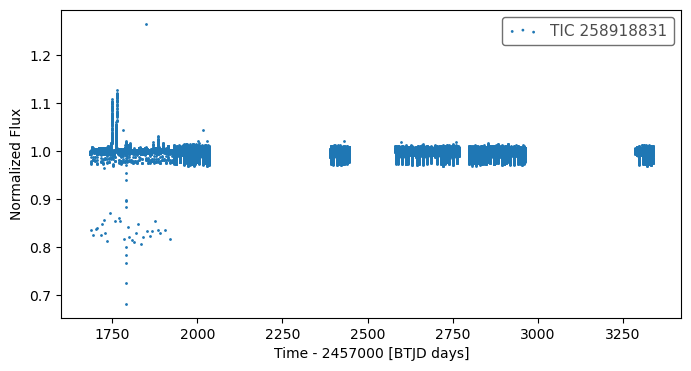

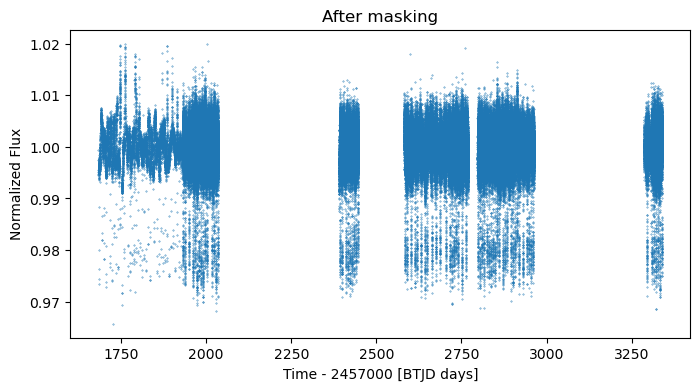

In [10]:
%matplotlib inline
# %matplotlib widget

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

# mask out data you don't like...

fig, ax = plt.subplots(figsize=figsize)
search_result.scatter(ax = ax)

# mask = time < 0  #( time > 54950) & (time < 54963)  #  truncate weird spikes at the beginning of Kepler data  
mask = (flux < 0.96) | (flux > 1.02)    # remove outliers in QLP

time = time[~mask]
flux = flux[~mask]
fluxerr = fluxerr[~mask]

# make sure that therte are no nans!

finite_mask = np.isfinite(time) * np.isfinite(flux) * np.isfinite(fluxerr)

# make a dictionary of the data 

data = pd.DataFrame({'time': time[finite_mask], 'flux': flux[finite_mask], 'err': fluxerr[finite_mask]})

ax2 = plt.figure(figsize=figsize).gca()
ax2.scatter(data.time, data.flux, s=0.1);
ax2.set_ylabel(ax.get_ylabel())
ax2.set_xlabel(ax.get_xlabel())
ax2.set_title("After masking");

In [ ]:
do_bls = False

if do_bls:
    if not "../.." in sys.path:
        sys.path.append("../..")
    import lightkurve_ext_pg_runner as lke_pg_runner  # at ../../

    bls_result = lke_pg_runner.run_bls(
        search_result.remove_nans(),
        pg_kwargs=dict(
            minimum_period=1, maximum_period=20,
            frequency_factor=1,            
            duration=[3.4957 / 24 * f for f in [0.975, 1, 1.025, 1.05, 1.1, 1.15,]],  # based on observed primary eclipse duration for better fit
        ),
    )
    !$NOTIFY_CMD  "BLS Done"

In [ ]:
# Visaully compare different candidate period

# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418132651611877).truncate(-0.1, 0.1).scatter(label="BLS period, frequency_factor=10");  # HWHM 0.001571020094789155
# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418147).truncate(-0.1, 0.1).scatter(label="s0001-s0009:TCE1");

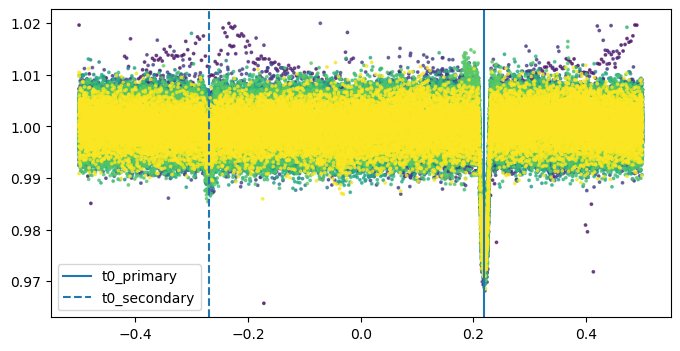

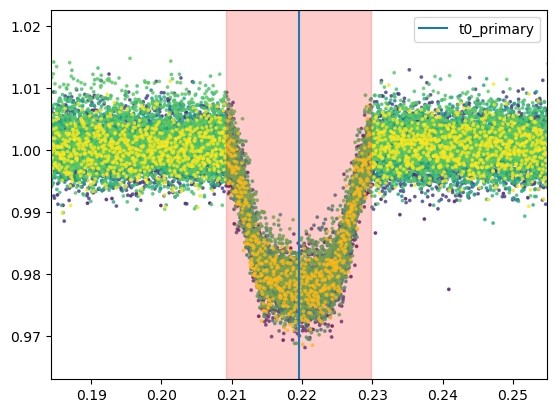

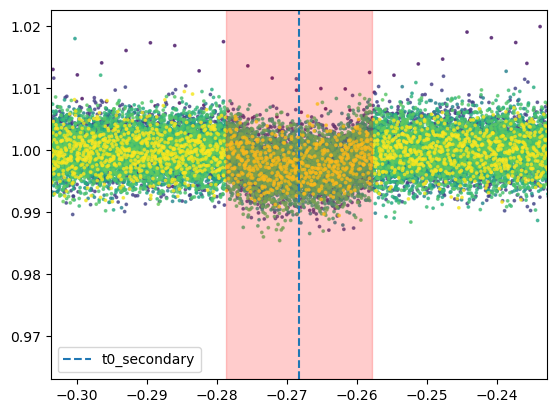

In [30]:
%matplotlib inline
# %matplotlib widget

from astropy.time import Time

# define the orbital period and the t0 

# epoch=1931.78, duration_hr=2.95538, period=5.98559, label="s0014s0060tce1", transit_depth_percent=2.2696,
# epoch=1928.86, duration_hr=2.99706, period=5.98557, label="s0014s0060tce2", transit_depth_percent=0.2864,
# TESS EB:  5.9856044  (Sectors 23-26)
# MCMC on df_primary: 5.985591915160649

# FILL-IN THE eclipse epoch / period, 
period = 5.98559  # TCE1
period = 5.985592 # MCMC 

t0_primary = 1931.78
t0_secondary = 1928.86


# convert epoch from BTJD to commonly mjd used here
# t0_primary = Time(t0_primary, format="btjd").to_value("mjd")
# t0_secondary = Time(t0_secondary, format="btjd").to_value("mjd")

# Move t0 to the first dip in the data (some of the subsequent codes, espically fit_each_eclipse(), assumes that)
t0_primary = t0_primary - int((t0_primary - data['time'][0]) / period) * period
if t0_secondary is not None:
    t0_secondary = t0_secondary - int((t0_secondary - data['time'][0]) / period) * period

duration_hr_primary = 2.95538 
duration_hr_secondary = 3.0

t0_for_plotting = 0  # keep 0 for plotting purposes
if t0_secondary is not None:
    t0_for_plotting = t0_primary - np.abs(t0_primary - t0_secondary) * 0.45  # use a custom one so that the eclipses are not near the edge (-0.5 or +0.5)

phase = etv_functions.phase_data(data['time'], t0_for_plotting, period)

fig, ax = plt.subplots(figsize = (8,4))

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])

# add the phase to the dataframe
data['phase'] = phase

plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
if t0_secondary is not None:
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.legend()
# plt.ylim(0.535, 0.55)
# plt.xlim(-0.5, 0.1)
plt.show();

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
t1_p, t4_p = etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.5 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.5 * duration_hr_primary / 24/ period 
plt.xlim(t1_p - 0.025, t4_p + 0.025);
plt.axvspan(t1_p, t4_p, color="red", alpha=0.2);plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

if t0_secondary is not None:
    plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
    t1_s, t4_s = etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.5 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.5 * duration_hr_secondary / 24/ period 
    plt.xlim(t1_s - 0.025, t4_s + 0.025);
    plt.axvspan(t1_s, t4_s, color="red", alpha=0.2);plt.legend();
    plt.legend();
    # plt.ylim(0.975, 1.005);
    plt.show()

### Compare folded plots across sectors

In [ ]:
with plt.style.context(lk.MPLSTYLE):
    fig, axs = plt.subplots(1, len(lcc_tess), figsize=(4 * len(lcc_tess), 3), sharey=True);
    if isinstance(axs, plt.Axes):
        axs = [axs]
    for i, lc in enumerate(lcc_tess):
        lc_f = lc.select_flux("flux").normalize(unit="percent").fold(period=period, epoch_time=t0_primary)
        lc_f = lc_f.truncate(-duration_hr_primary * 2 / 24, duration_hr_primary * 2 / 24)
        ax = lc_f.scatter(ax=axs[i], s=1, label=f"S.{lc_f.sector}");
        ax.legend(loc="lower right");
        if i > 0: 
            ax.set_ylabel(None)
            ax.set_xlabel(None)
    fig.suptitle(f"{lc.label}, folded around primary eclipses");
plt.tight_layout();

# ---
with plt.style.context(lk.MPLSTYLE):
    fig, axs = plt.subplots(1, len(lcc_tess), figsize=(4 * len(lcc_tess), 3), sharey=True);
    if isinstance(axs, plt.Axes):
        axs = [axs]
    for i, lc in enumerate(lcc_tess):
        lc_f = lc.select_flux("flux").normalize(unit="percent").fold(period=period, epoch_time=t0_secondary)
        lc_f = lc_f.truncate(-duration_hr_secondary * 2 / 24, duration_hr_secondary * 2 / 24)
        ax = lc_f.scatter(ax=axs[i], s=1, label=f"S.{lc_f.sector}");
        ax.legend(loc="lower right");
        if i > 0: 
            ax.set_ylabel(None)
            ax.set_xlabel(None)
    fig.suptitle(f"{lc.label}, folded around secondary eclipses");
plt.tight_layout();

### Detrend (optional)

- detrended flux is in `flux_detrended`, and won't be used in subsequent work by default

In [ ]:
# show data to visualize what's changed in each step below
data  

In [ ]:
# phase fold the data and create an appoximate binary model (top) and subtract it from the data (bottom)
#_, _ , flux_sub_binary, model, _, _ = etv_functions.trend_removal_interact(period, 0, data['time'], data['flux'], data['time'], data['flux'])

data = etv_functions.trend_removal_interact(period, t0_for_plotting, data)
data

In [ ]:
# if you want to detrend the data run this line!

data = etv_functions.detrend_suz(data, T_dur = 10, plot = True)
data

In [ ]:
# plot the phase folded data here so that you know at what phase you want to cut the data to model 
fig, ax = plt.subplots(figsize = figsize)
plt.scatter(data.phase, data.flux_detrended, s = 1, label="flux_detrended")
plt.legend()
plt.show()

plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
plt.xlim(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.6 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.6 * duration_hr_primary / 24/ period);
plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.xlim(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.6 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.6 * duration_hr_secondary / 24/ period);
plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

<span style="background-color: rgba(255, 0, 0, 0.6);"> NOTE: </span> The zoom windows below for the eclipses are made **smaller**, an attempt to reduce the complications of EW variability outside the minima (and some assymetery)

### Now that the data is ready we can start 

Primary:   1686.3707279999999 0.21952715788180666
window_width_p (phase): 0.024687449461974688
Secondary: 1683.4507279999998 -0.26831097074441346
window_width_s (phase): 0.025060177840387384


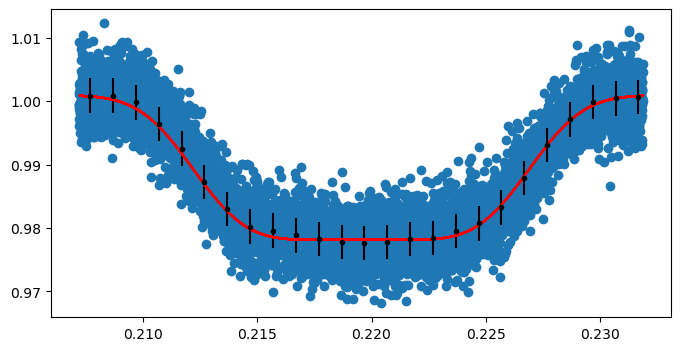

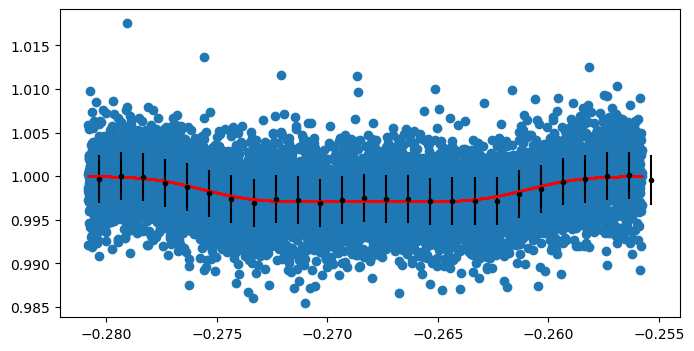

In [33]:
# define the midpoints of the primary and secondary eclipses and the window width

# if these don't look central - change them!! the eclipses should be central
midpoint_p =  etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0]  # convet to time in phase
# midpoint_p -= 0.004  # the offset is added back to t0_primary (& secondary above
print('Primary:  ', t0_primary, midpoint_p)

# change depending on the width of the eclipses, default to be slightly larger than the primary eclipse
window_width_p = 1.2 * duration_hr_primary / 24 / period   # it seems to be difficult to bit model the flat bottom and the curves outside, focus on the overall shape for now
# use a shoter duration to avoid fitting the out-of-eclipse LC, which has its own variability that the model is not equipped to hanlde
# window_width_p = 0.095
print("window_width_p (phase):", window_width_p)

data_primary = data[(data['phase'] > midpoint_p - window_width_p / 2) & (data['phase'] < midpoint_p + window_width_p / 2) ]
ph_binned,flux_binned,err_binned = etv_functions.run_binning_phased(data_primary.phase, data_primary.flux, yerr=data_primary.err,nbins=1000)


if t0_secondary is not None:
    midpoint_s =  etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0]
    print('Secondary:', t0_secondary, midpoint_s)

    # the coshgauss model seems problematic, try to use a larger width to give it more shape to fit
    window_width_s = 1.2 * duration_hr_secondary / 24 / period  
    # window_width_s = 0.22
    print("window_width_s (phase):", window_width_s)
    
    data_secondary = data[(data['phase'] > midpoint_s - window_width_s / 2) & (data['phase'] < midpoint_s + window_width_s / 2) ]
    ph_binned_s,flux_binned_s,err_binned_s = etv_functions.run_binning_phased(data_secondary.phase, data_secondary.flux, yerr=data_secondary.err,nbins=1000)


### # you need initial guesses!! The order is :
# alpha0, alpha1, t0, d, Tau - CHANGE THESE TO YOUR OWN INITIAL GUESSES
# median flux, -eclipse depth, t0, related to duration, related to shape (U or V) 
# t0 in normalixed phase
start_vals = [1.001, -0.0228, midpoint_p, 0.00447, 3.4990]
start_vals_s = [1.00, -0.0029, midpoint_s, 0.00447, 3.5]
    
# -- -- -- -- -- -- -- -- -- 
etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *start_vals)
if t0_secondary is not None:
    etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *start_vals_s)    

In [ ]:
if False: 
    # Export the data around primary eclipses, for period analysis outside of notebook
    data_primary[["time", "flux", "err"]].to_csv(f"tmp/data_primary_{ticid}.csv", index=False)

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [03:42<00:00,  4.50it/s]


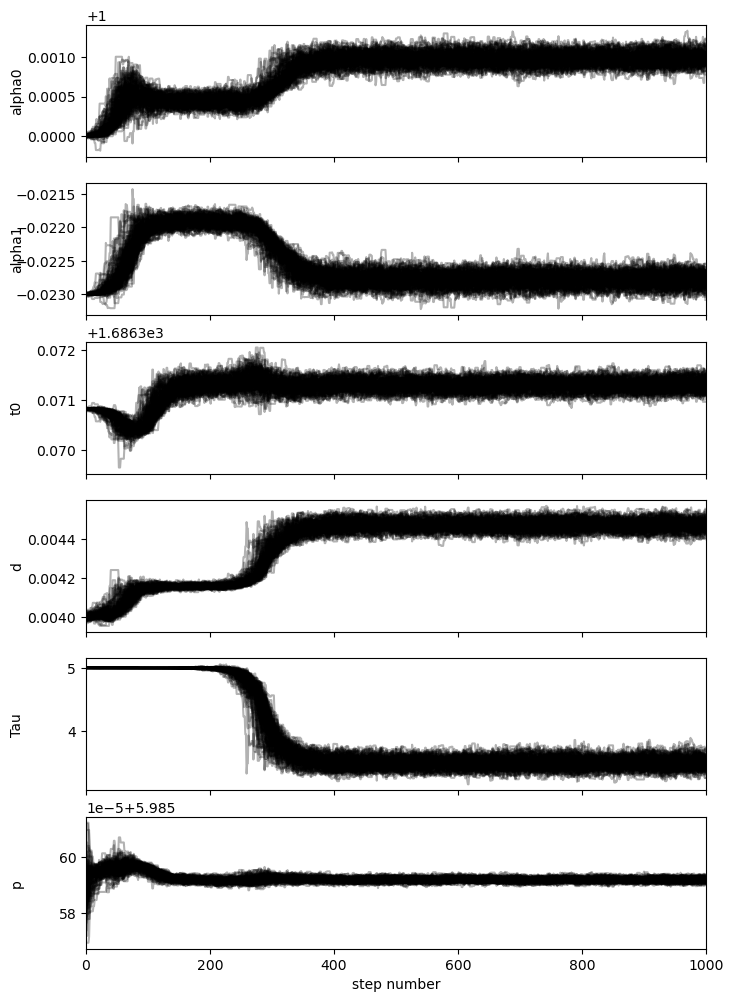

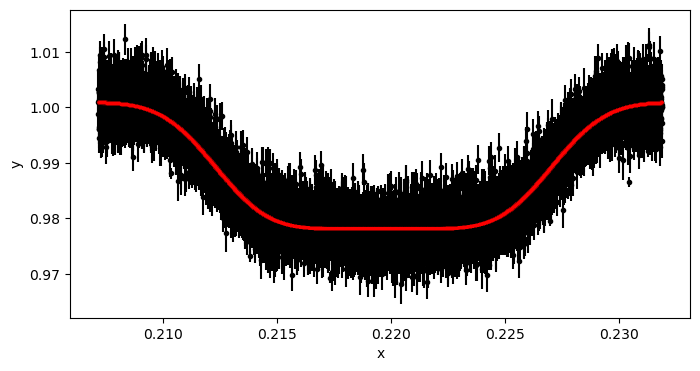

mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = 1.0009795475389585, -0.022777750260811223, 1686.3712924611618, 0.004471616808648968, 3.499026270769109, 5.985591915160649
std_p: 7.514399675954421e-07


In [29]:
# use MCMC to refine the period

use_mcmc_to_fit_period = True


if use_mcmc_to_fit_period:
    import etv_functions_with_period as etvp

    etv_functions.enable_info_log_for_jupyter()
        
    # MCMC result
    # mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = 1.0009795475389585, -0.022777750260811223, 1686.3712924611618, 0.004471616808648968, 3.499026270769109, 5.985591915160649
    # std_p: 7.514399675954421e-07
    mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p, fit_params_p_stats = etvp.run_mcmc_initial_fit_p(
        data_primary[:],
        [1.00, -0.023, t0_primary, 0.004, 5.0, 5.985590],
        nruns=1000, discard=600, 
        # nruns=20, discard=1, 
        pool=-2,
        plot_chains=True,
        plot=True,
        also_return_stats=True,
    )
    print("mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p]]))
    print("std_p:", fit_params_p_stats["std_p"])
    !$NOTIFY_CMD "Fitting period done."

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [01:21<00:00, 12.26it/s]


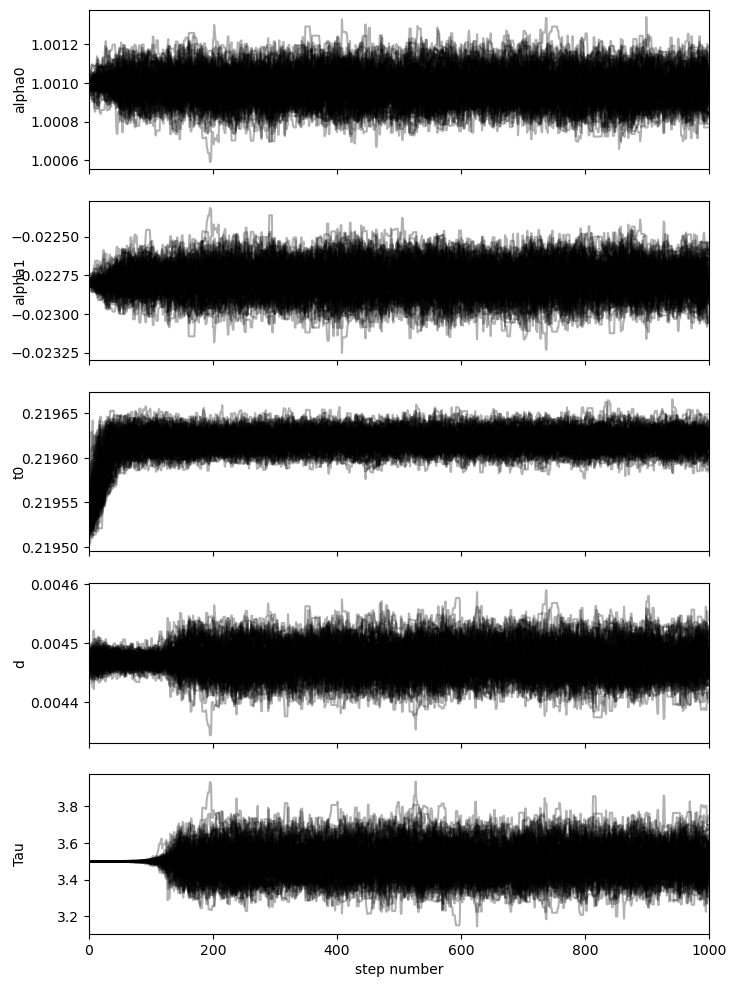

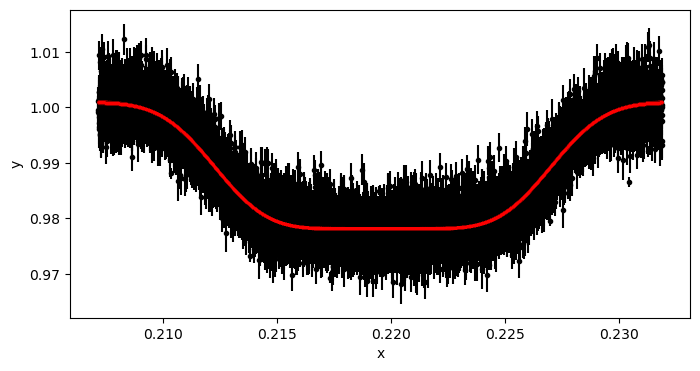

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [01:24<00:00, 11.81it/s]


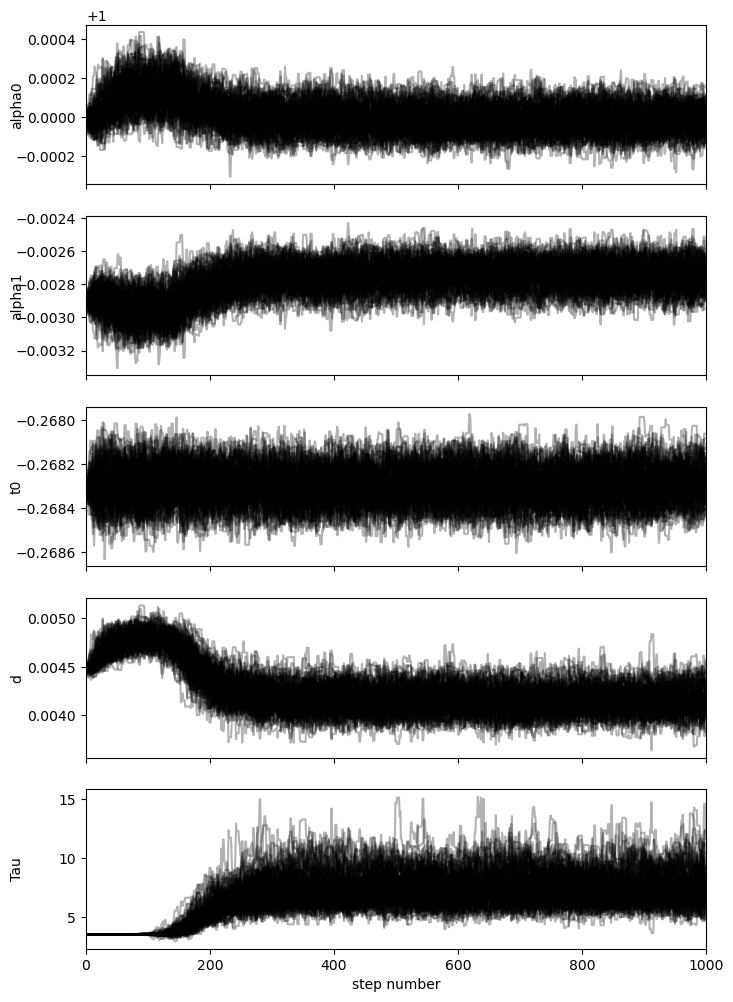

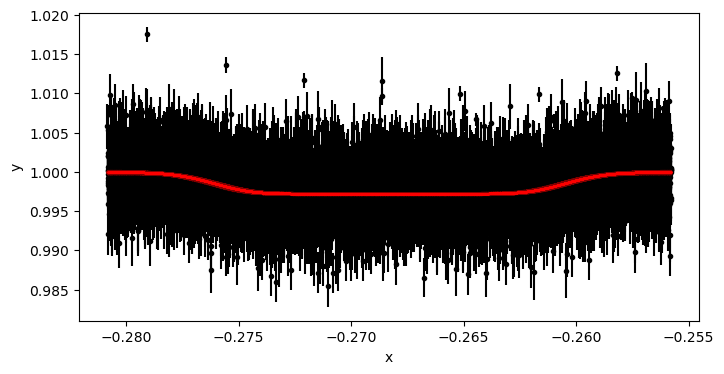

In [34]:
# run the initial model fit using MCMC for the primary and secondary eclipses 
run_init_fit = True

if run_init_fit:
    etv_functions.enable_info_log_for_jupyter()
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = etv_functions.run_mcmc_initial_fit(data_primary, start_vals, nruns = 1000, pool=-2, plot_chains = True, plot = True)
    if t0_secondary is not None:
        mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = etv_functions.run_mcmc_initial_fit(data_secondary, start_vals_s, nruns = 1000, pool=-2, plot_chains = True, plot = True)
    !$NOTIFY_CMD "Initial fit done"

In [ ]:
if not run_init_fit:  # case init fit has been previously saved and to be reussed
    print("Use pre-defined inital model params:")
    # initial fit params from TESS data
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.0009784718755586, -0.022773140717388562, 0.2196196601513669, 0.0044708133483979725, 3.497801743464475
    mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 0.9999850276440103, -0.0027378907631026204, -0.2682994537877083, 0.004150948345879533, 7.297641256471173

    etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *[mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau])
    etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *[mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s])    

In [35]:
print("Initial model params:")  # For information, and they can be copied to the cell above for future reuse

print("mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau]]))
if t0_secondary is not None:
    print("mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = " + ", ".join([str(v) for v in [mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s]]))

Initial model params:
mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.0009784718755586, -0.022773140717388562, 0.2196196601513669, 0.0044708133483979725, 3.497801743464475
mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 0.9999850276440103, -0.0027378907631026204, -0.2682994537877083, 0.004150948345879533, 7.297641256471173


276

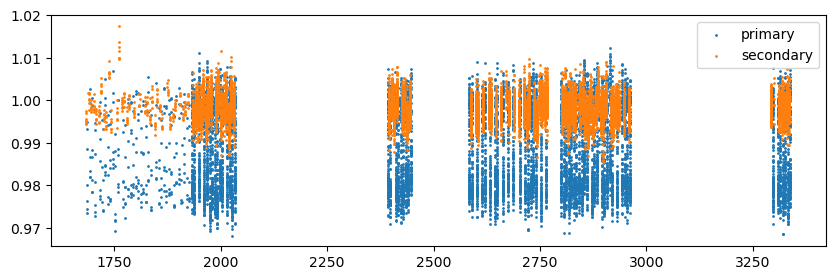

In [36]:
fig = plt.subplots(figsize=(10, 3), sharex=True)
plt.scatter(data_primary.time,data_primary.flux , s = 1, label = 'primary')
if t0_secondary is not None:
    plt.scatter(data_secondary.time,data_secondary.flux , s = 1, label = 'secondary')
plt.legend()

# calculate the number of transits there are within the data 
n_transits = int((max(data_primary.time) - min(data_primary.time)) / period)
n_transits

1686.3707279999999 5.985592 1686.3707279999999


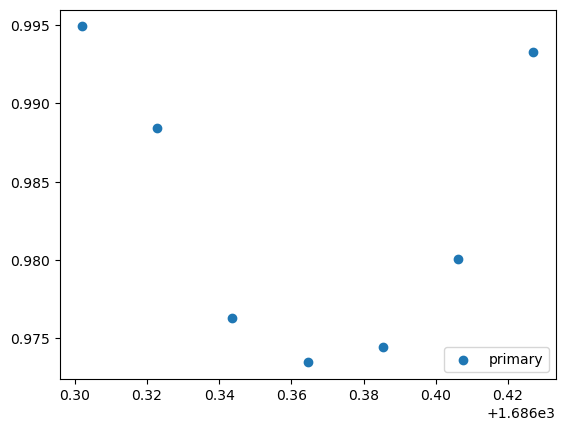

1686.3707279999999 5.985592 1692.3563199999999


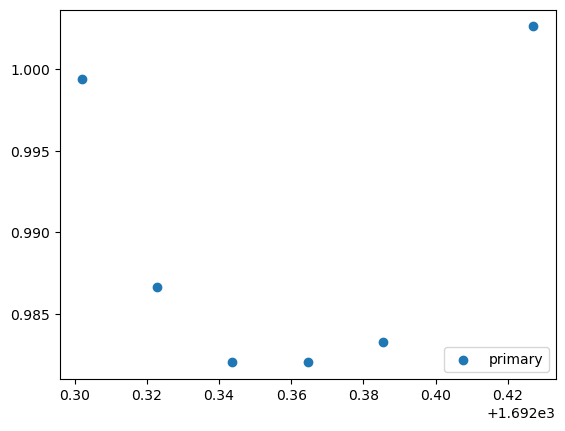

1686.3707279999999 5.985592 1698.3419119999999


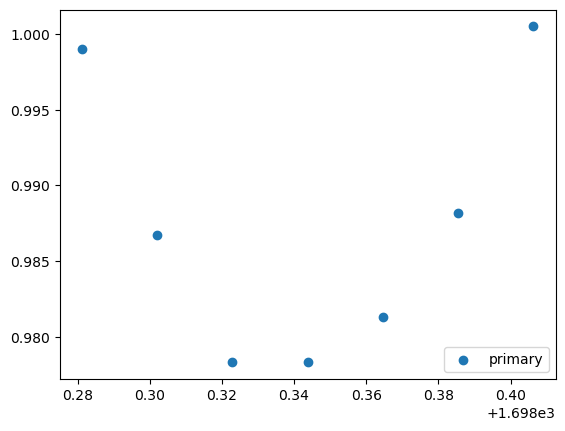

1683.4507279999998 5.985592 1683.4507279999998


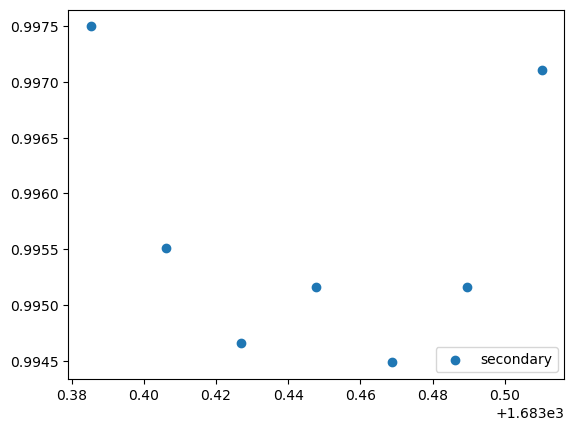

1683.4507279999998 5.985592 1689.4363199999998


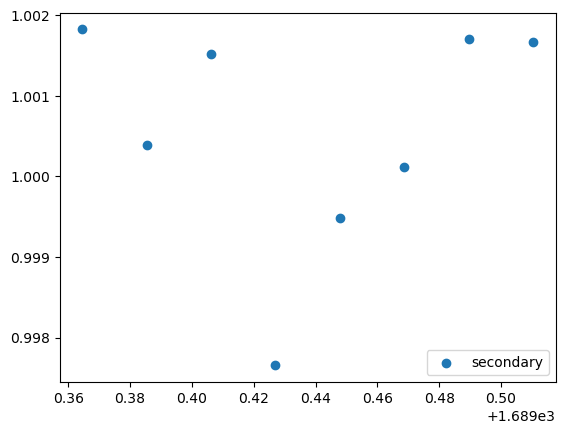

1683.4507279999998 5.985592 1695.4219119999998


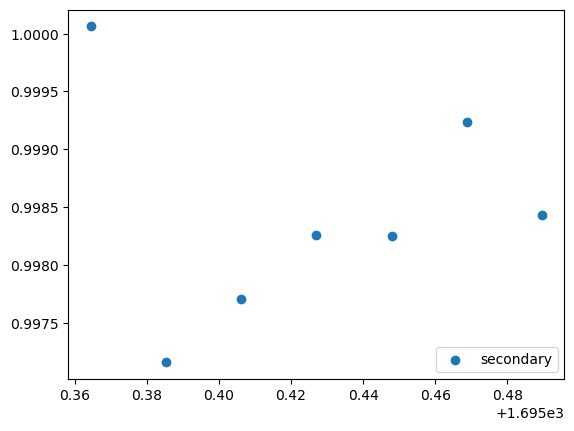

In [37]:
tr_index = range(0,n_transits)

for i in tr_index[0:3]:        
    transit_time = t0_primary+(period*i)
    x = np.array(data_primary.time)
    y = np.array(data_primary.flux) 
    yerr = np.array(data_primary.err)
    
    print (t0_primary, period, transit_time)
    
    mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
    
    x = np.array(x[mask])
    y = np.array(y[mask]) 
    yerr = np.array(yerr[mask])
    fig, ax = plt.subplots()
    plt.scatter(x,y, label="primary")
    plt.legend(loc="lower right")
    plt.show()
    

if t0_secondary is not None:
    for i in tr_index[0:3]:        
        transit_time = t0_secondary+(period*i)
        x = np.array(data_secondary.time)
        y = np.array(data_secondary.flux) 
        yerr = np.array(data_secondary.err)
        
        print (t0_secondary, period, transit_time)
        
        mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
        
        x = np.array(x[mask])
        y = np.array(y[mask]) 
        yerr = np.array(yerr[mask])
        fig, ax = plt.subplots()
        plt.scatter(x,y, label="secondary")
        plt.legend(loc="lower right")
        plt.show()

Fitting individual primary eclipses...
Existing manifest file found, will skip previously processed LCs and append to end of manifest file
Number 0 has already been completed -- skip
Number 1 has already been completed -- skip
1698.3419119999999 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 427.00it/s]


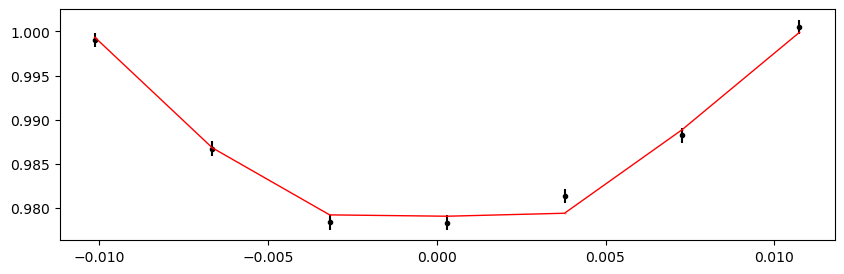

1704.3275039999999 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 437.32it/s]


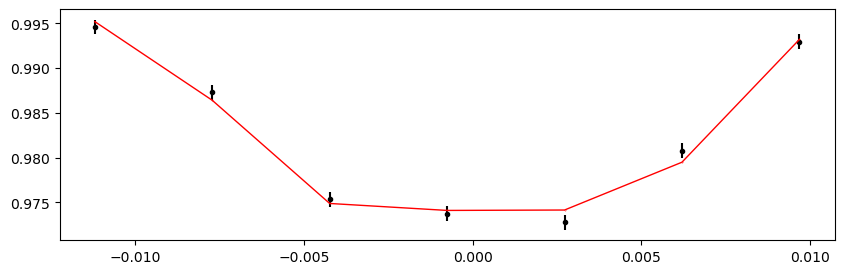

1716.2986879999999 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 442.29it/s]


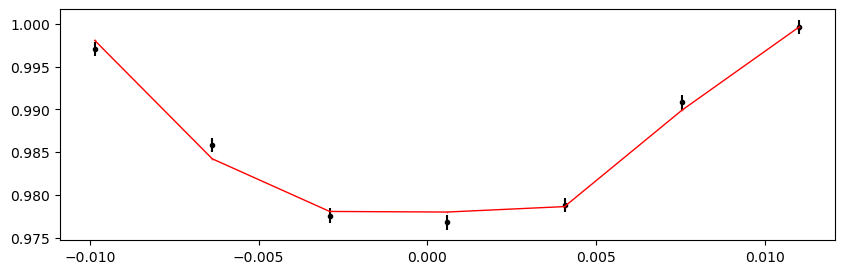

1722.2842799999999 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 445.46it/s]


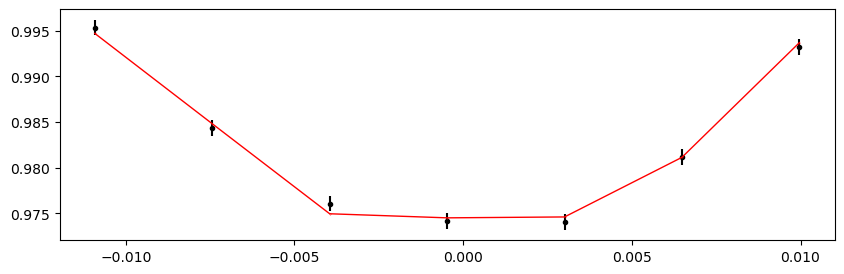

1728.2698719999999 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 439.36it/s]


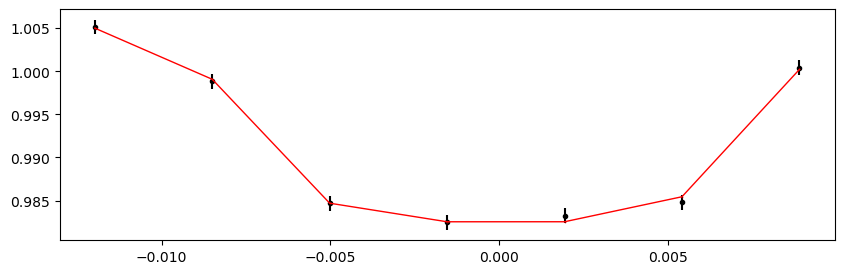

1734.2554639999998 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 430.52it/s]


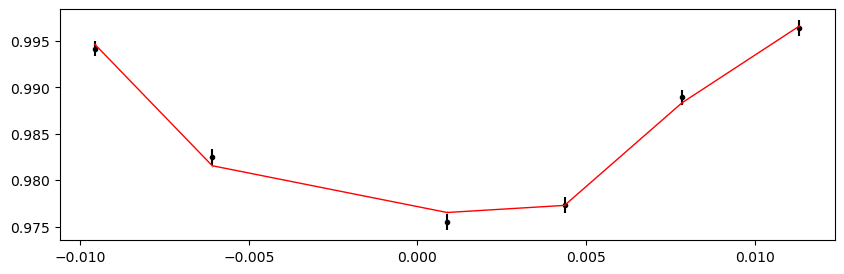

1740.2410559999998 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 441.52it/s]


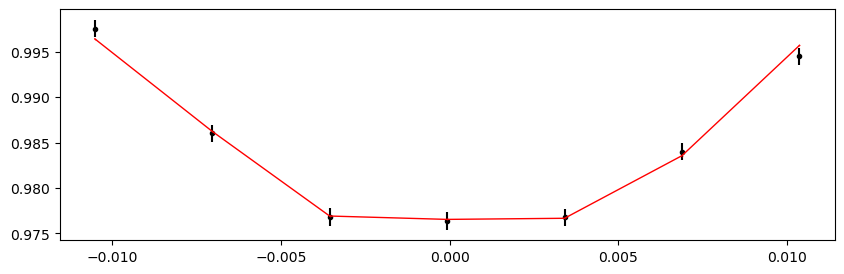

1746.2266479999998 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 441.66it/s]


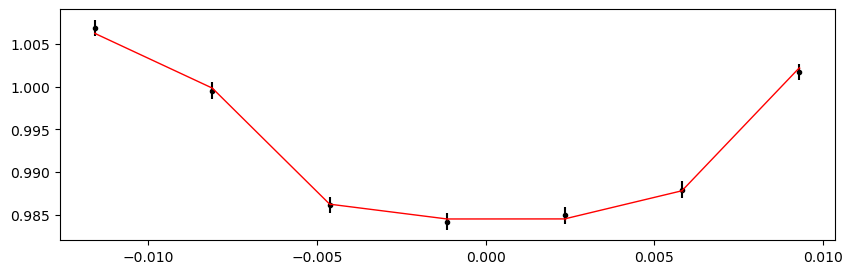

1752.2122399999998 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 438.11it/s]


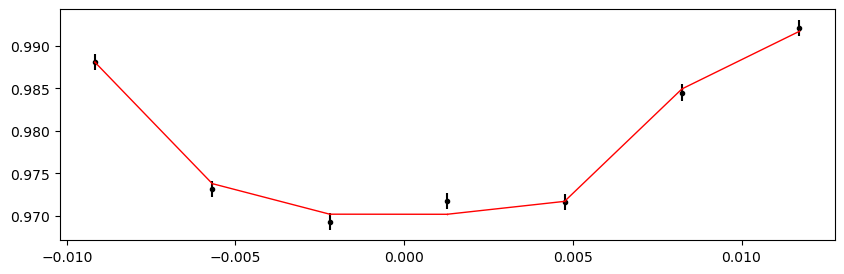

1758.1978319999998 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 430.99it/s]


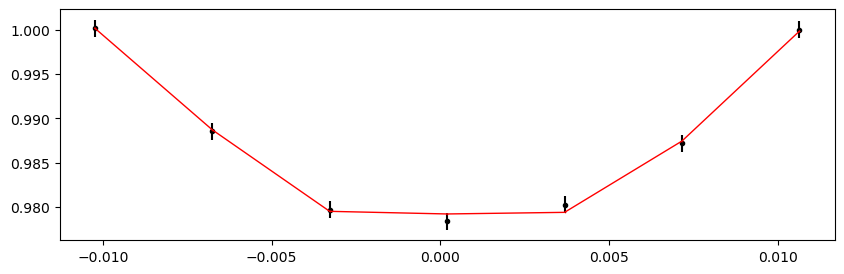

1770.1690159999998 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 450.62it/s]


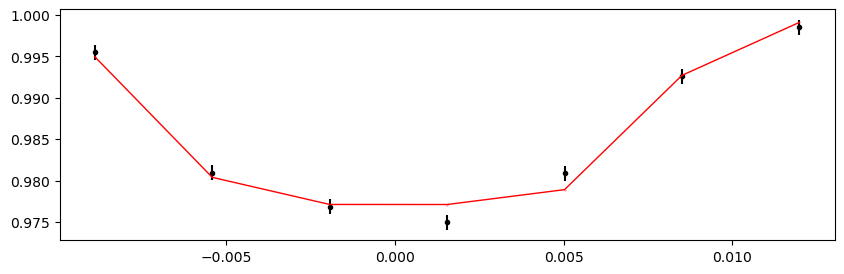

1776.1546079999998 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 442.78it/s]


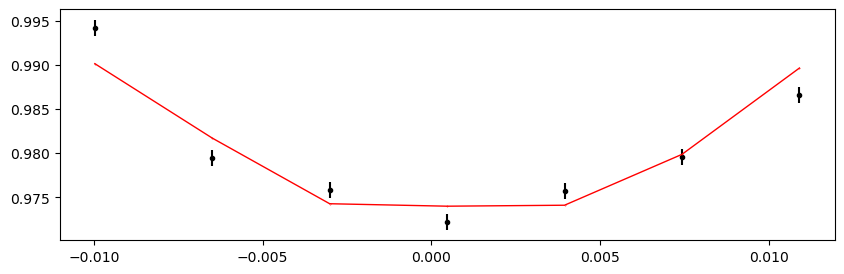

1782.1401999999998 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 443.48it/s]


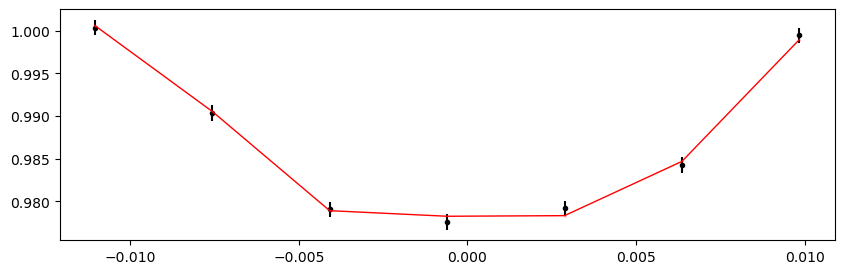

1788.1257919999998 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 445.74it/s]


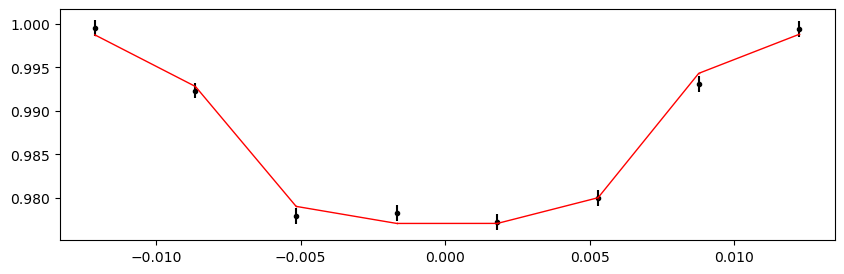

1794.1113839999998 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 449.68it/s]


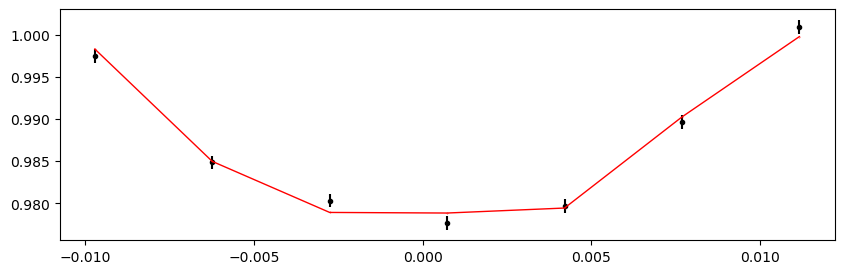

1800.0969759999998 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 447.19it/s]


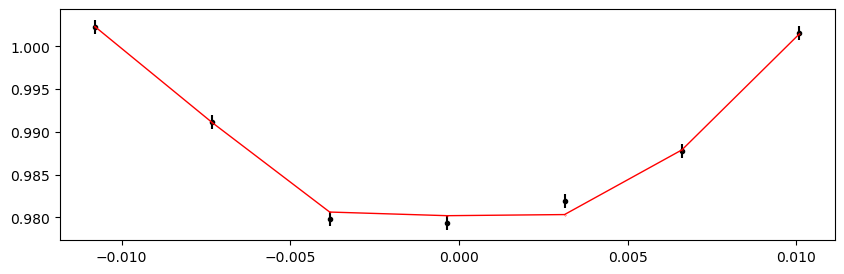

1806.0825679999998 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 439.14it/s]


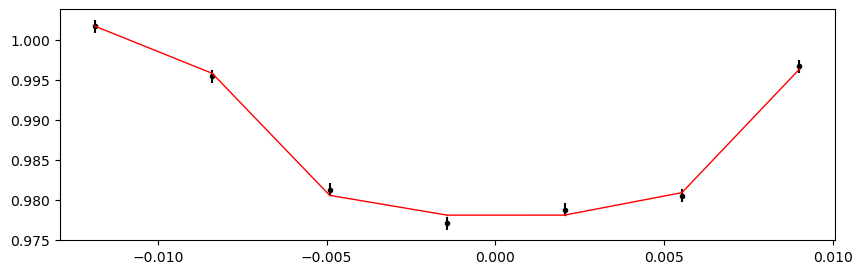

1812.0681599999998 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 438.75it/s]


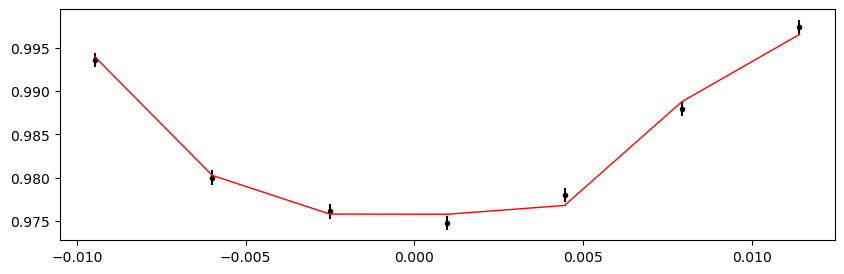

1818.0537519999998 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 443.50it/s]


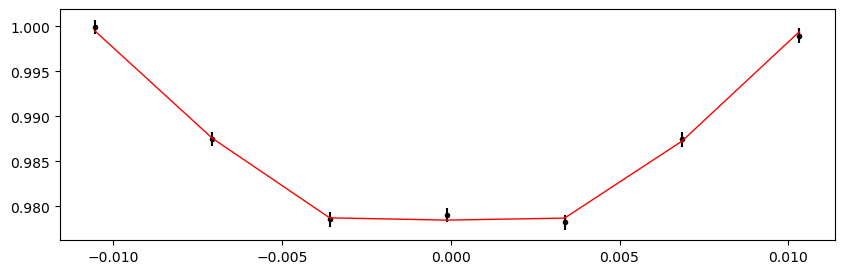

1824.0393439999998 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 448.12it/s]


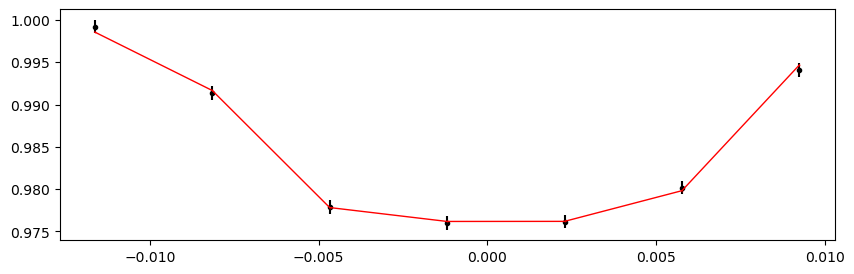

1830.0249359999998 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 448.90it/s]


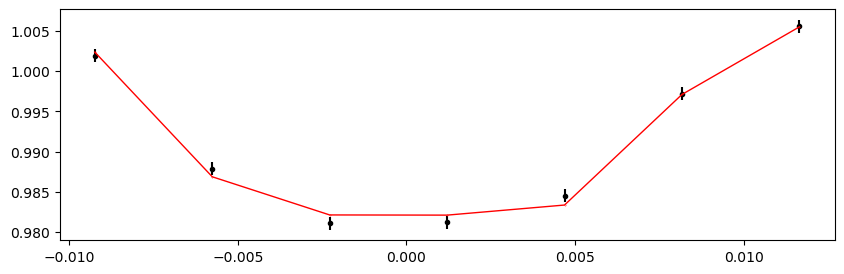

1836.0105279999998 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 451.17it/s]


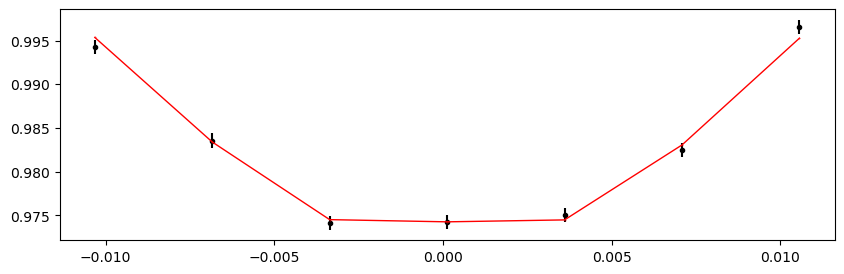

1847.9817119999998 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 446.38it/s]


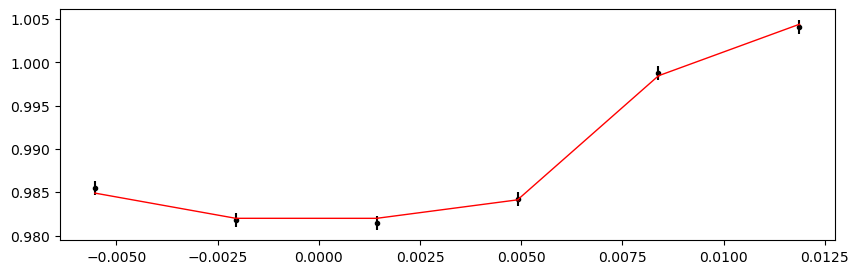

1853.9673039999998 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 440.10it/s]


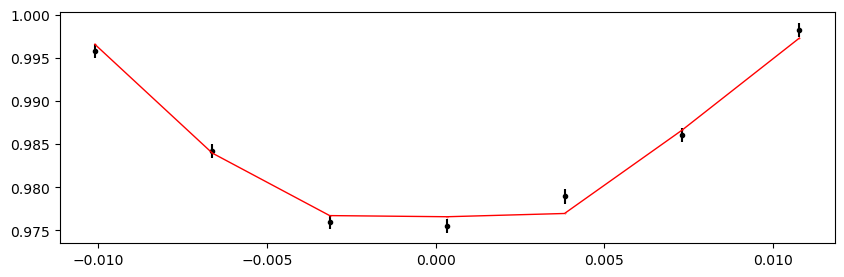

1859.9528959999998 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 442.92it/s]


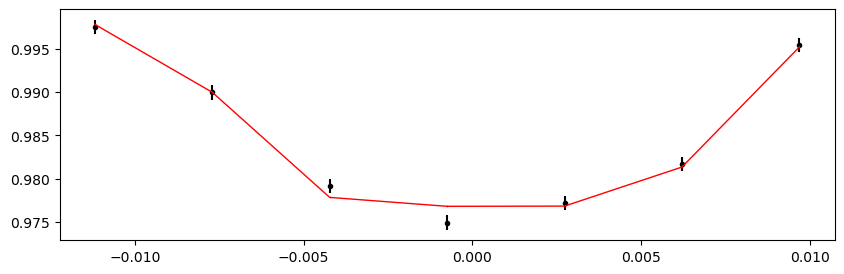

1865.9384879999998 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 445.86it/s]


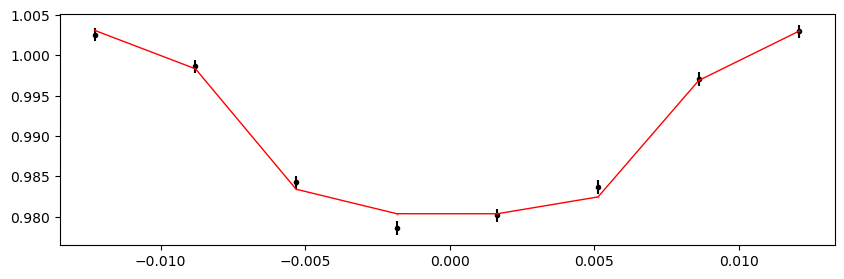

1871.9240799999998 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 430.11it/s]


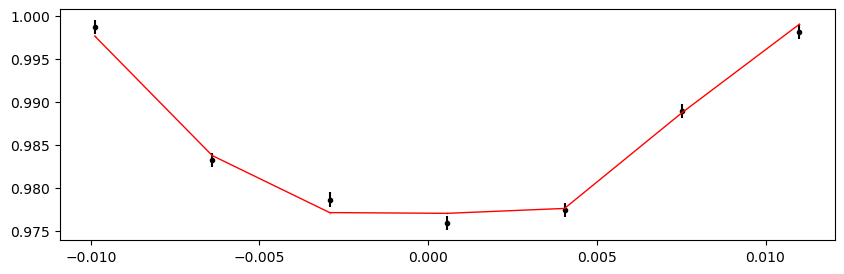

1877.9096719999998 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 429.45it/s]


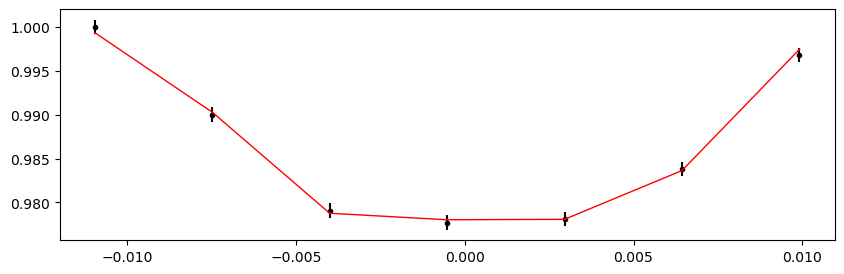

1883.8952639999998 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 437.68it/s]


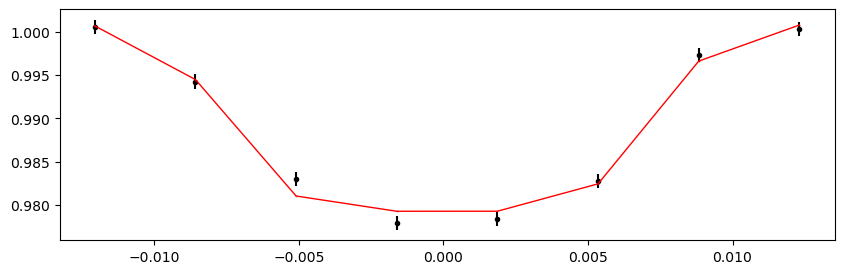

1889.8808559999998 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 446.10it/s]


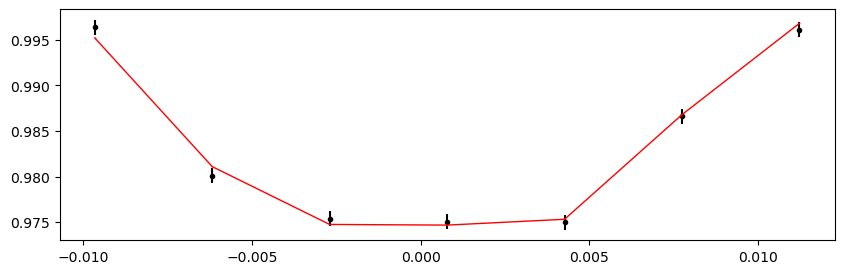

1895.8664479999998 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 436.84it/s]


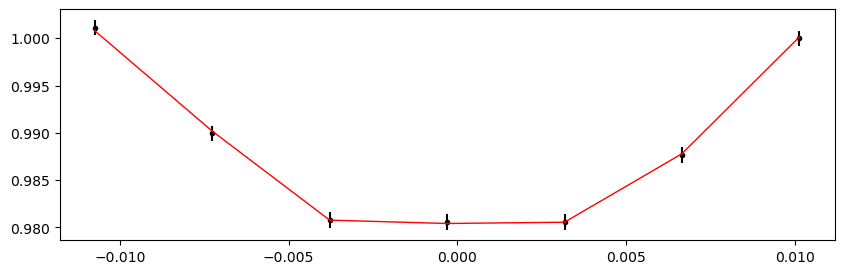

1901.8520399999998 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 443.22it/s]


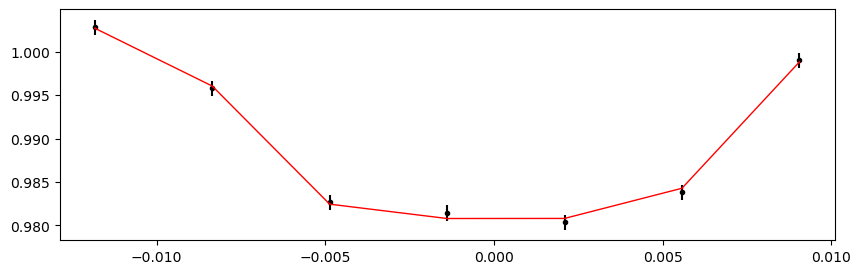

1907.8376319999998 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 448.10it/s]


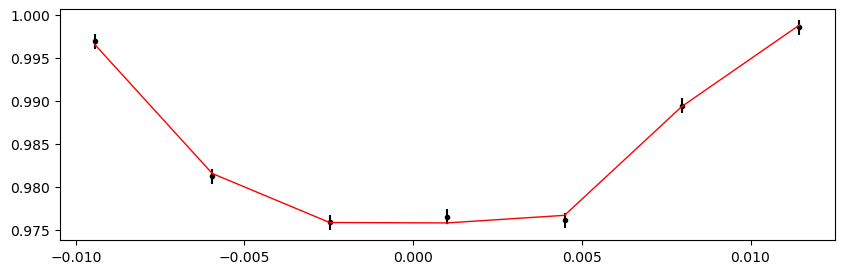

1913.8232239999998 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 448.73it/s]


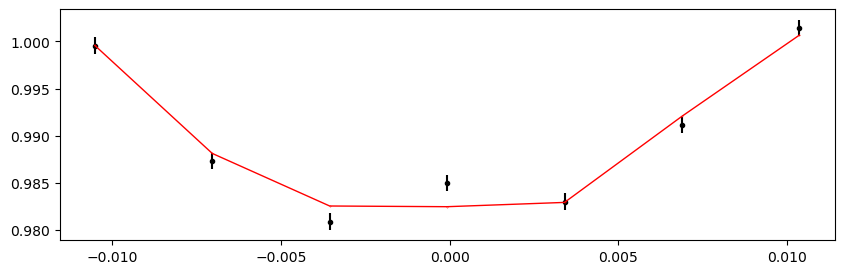

1919.8088159999998 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 448.27it/s]


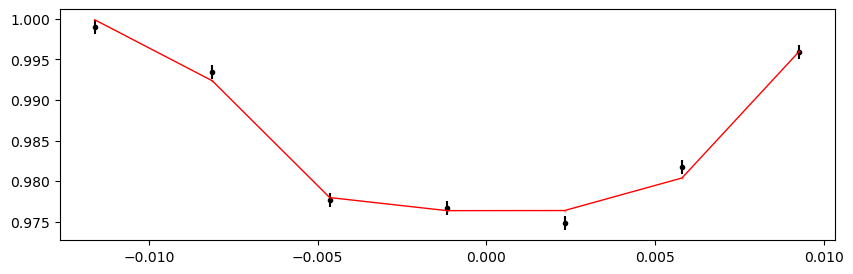

1925.7944079999997 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 443.89it/s]


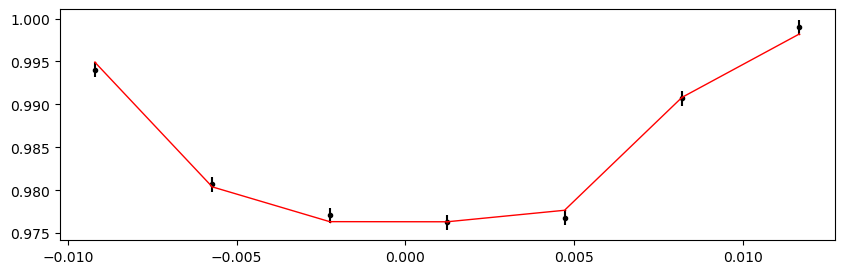

1931.7799999999997 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 387.94it/s]


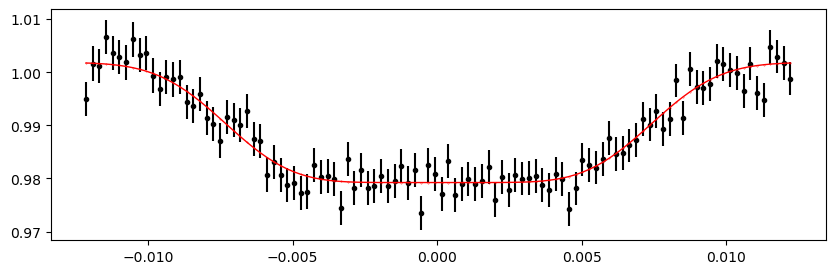

1937.7655919999997 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 388.89it/s]


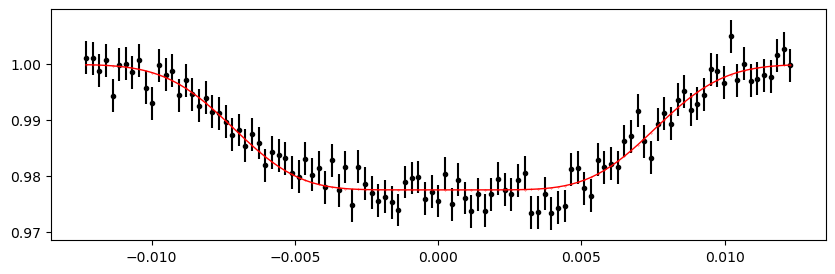

1949.7367759999997 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 390.10it/s]


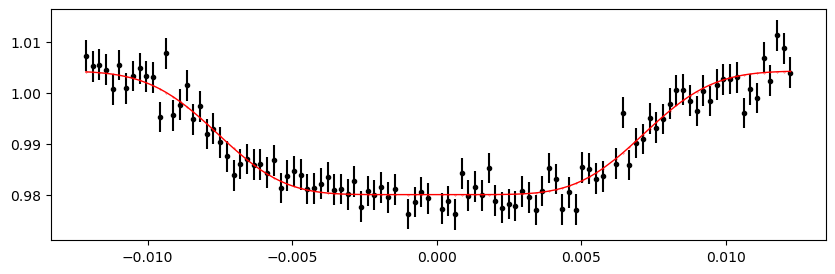

Time 1955.7223679999997 does not have enough data points: 2
1961.7079599999997 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 388.81it/s]


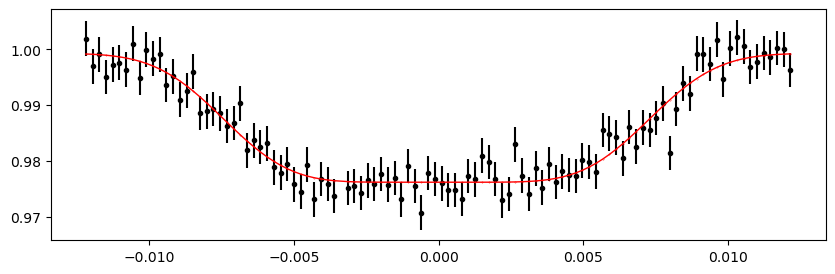

1967.6935519999997 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 388.91it/s]


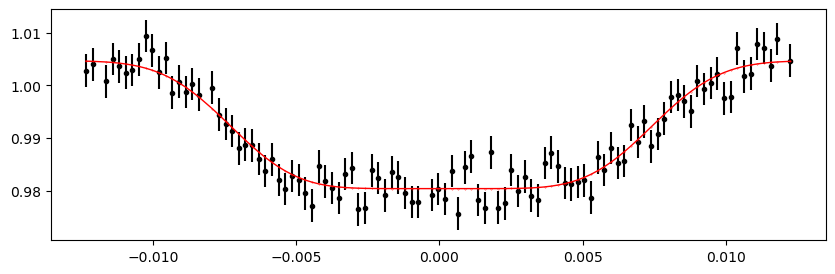

1973.6791439999997 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 387.36it/s]


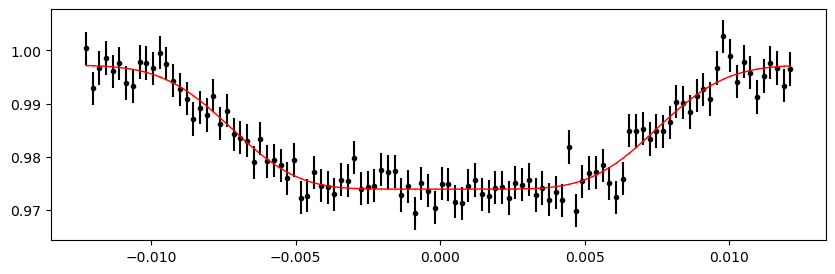

1979.6647359999997 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 385.88it/s]


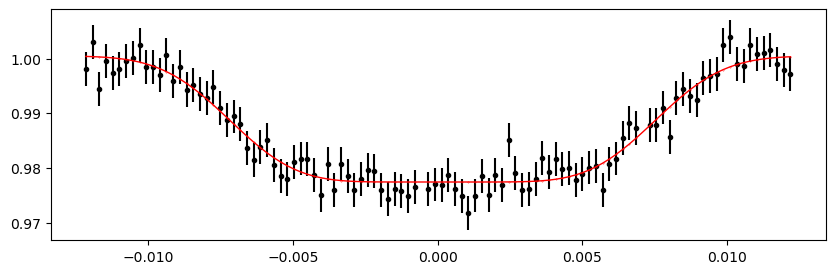

1985.6503279999997 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 379.19it/s]


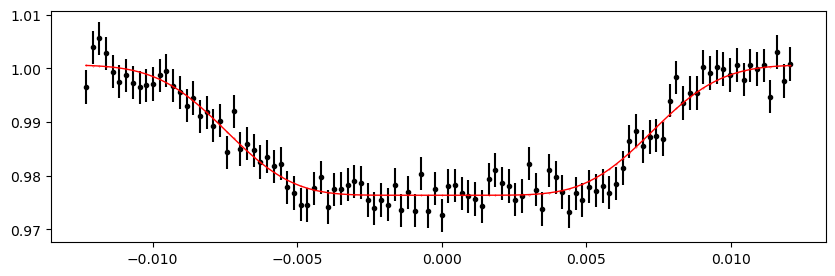

1991.6359199999997 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 377.49it/s]


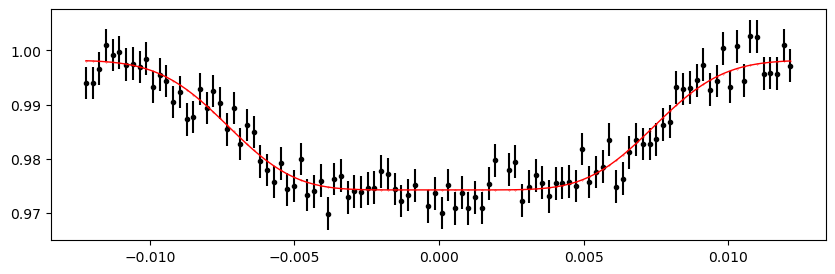

1997.6215119999997 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 379.40it/s]


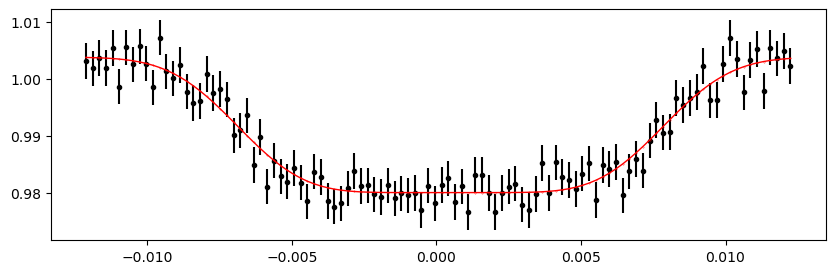

2003.6071039999997 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 388.40it/s]


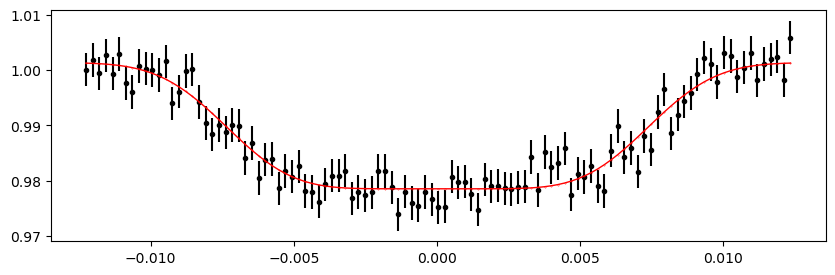

2015.578288 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 376.57it/s]


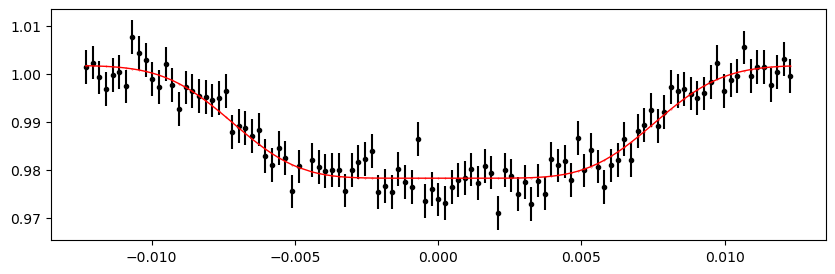

2021.56388 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 379.10it/s]


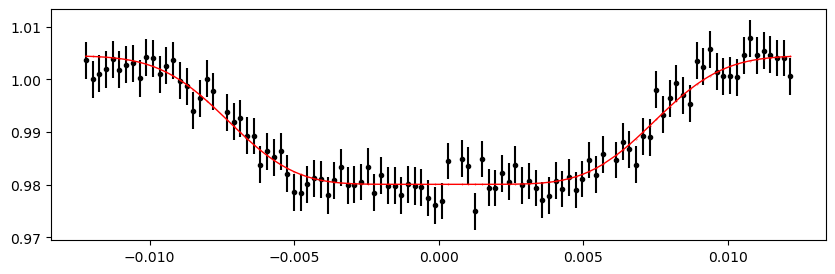

2027.549472 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 371.62it/s]


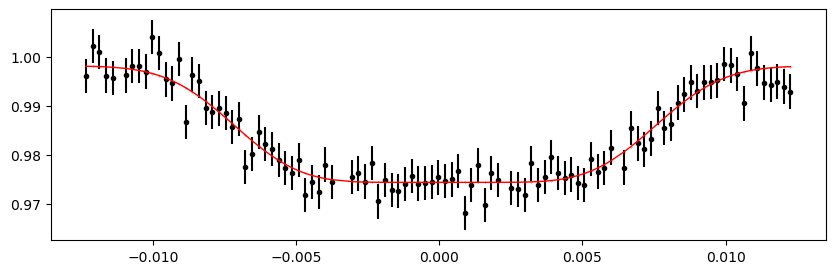

2033.535064 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 348.52it/s]


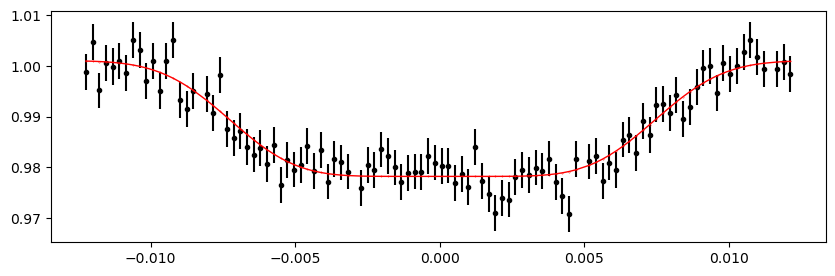

2392.670584 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 388.14it/s]


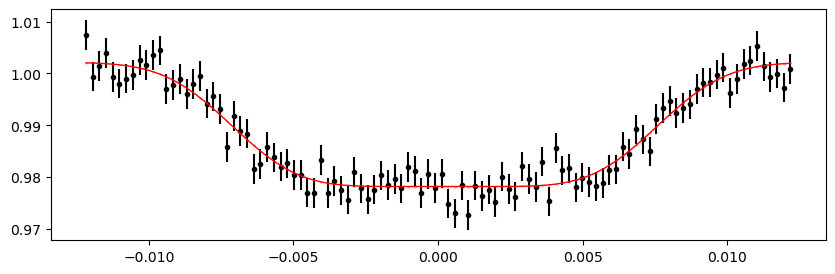

2398.656176 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 388.89it/s]


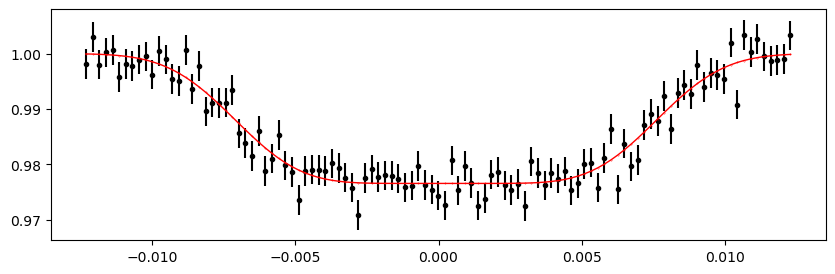

2410.62736 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 388.43it/s]


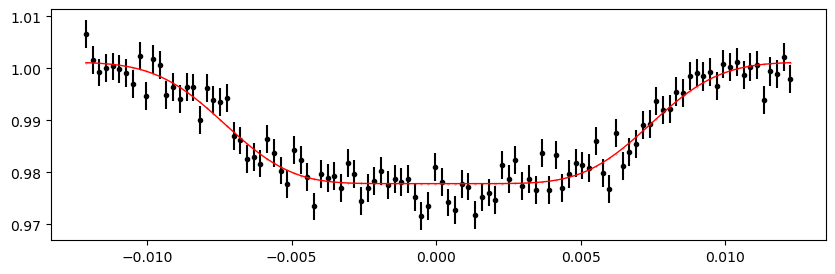

2416.612952 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 319.91it/s]


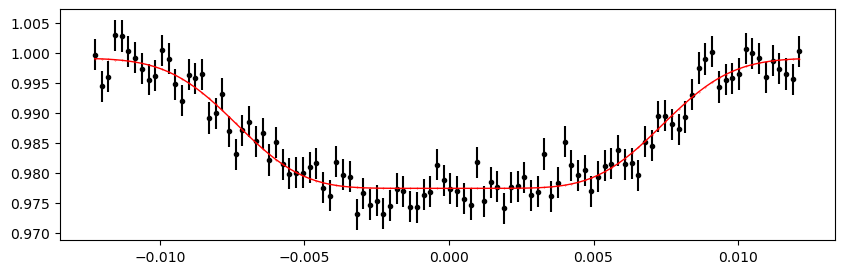

2422.598544 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 378.84it/s]


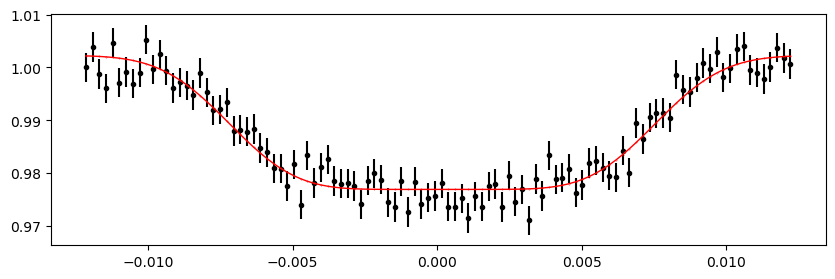

2428.584136 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 375.03it/s]


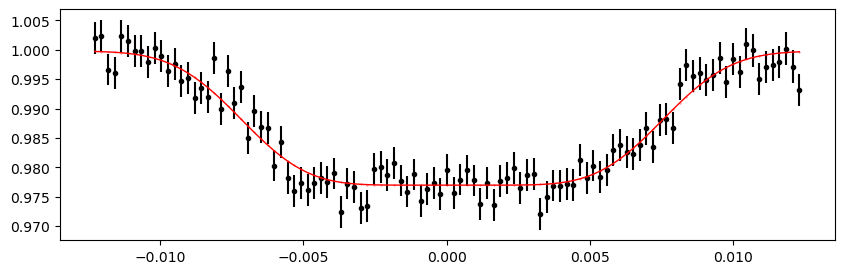

2434.569728 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 381.50it/s]


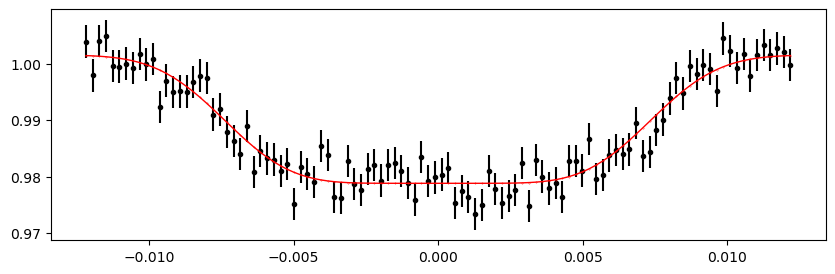

2440.55532 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 378.93it/s]


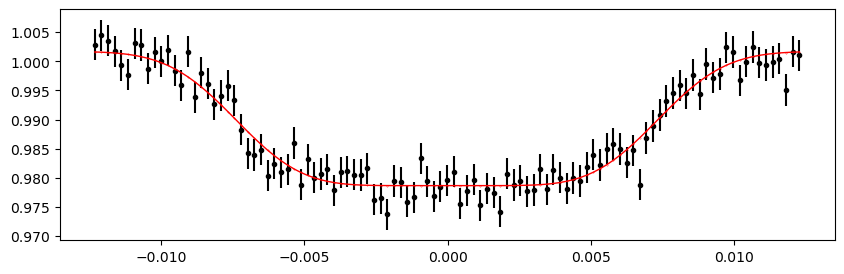

2446.540912 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 391.92it/s]


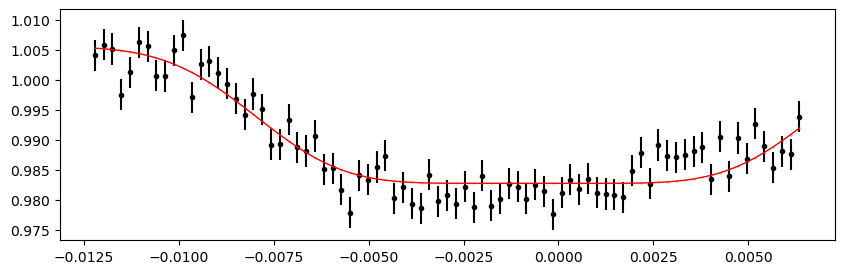

2584.209528 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 383.66it/s]


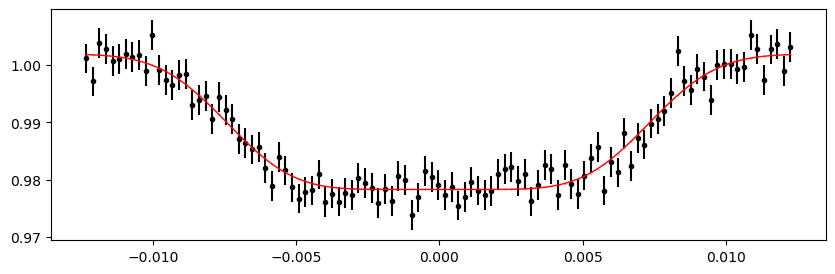

2590.19512 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 377.16it/s]


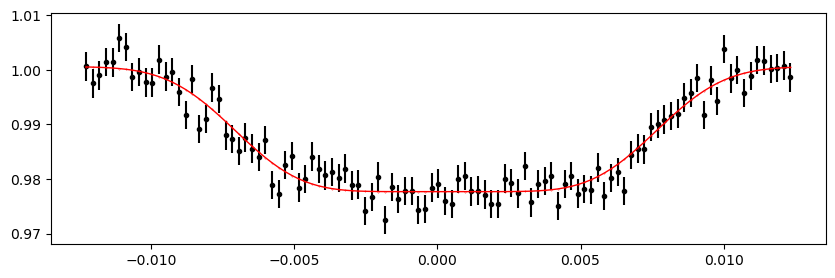

2602.166304 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 382.18it/s]


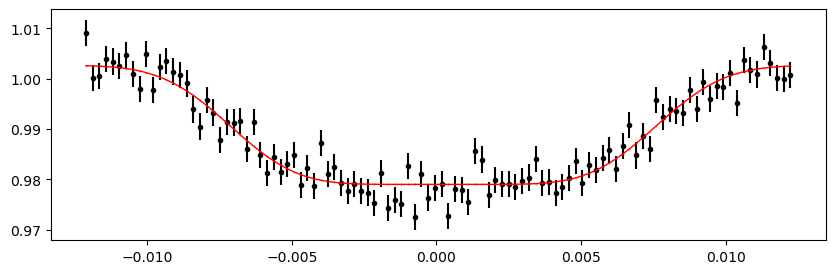

2614.137488 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 382.70it/s]


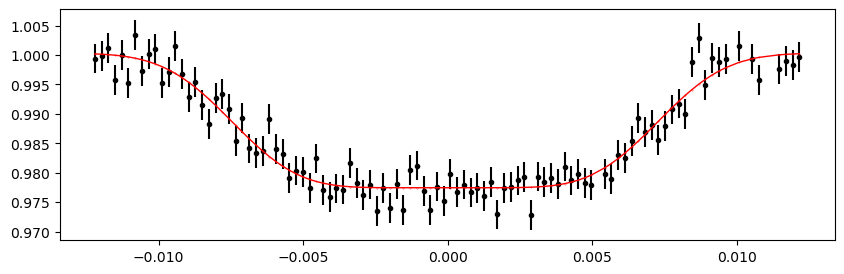

2620.12308 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 382.88it/s]


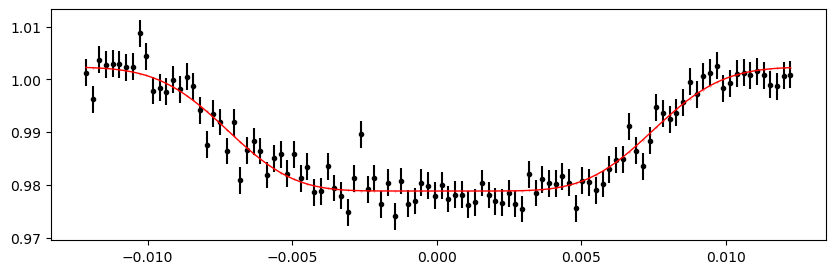

2632.094264 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 383.07it/s]


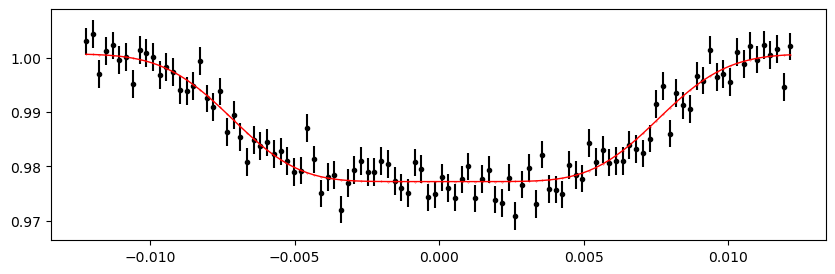

2644.065448 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 384.14it/s]


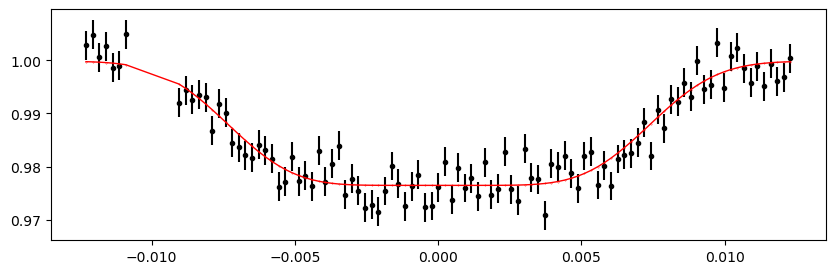

2650.05104 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 382.40it/s]


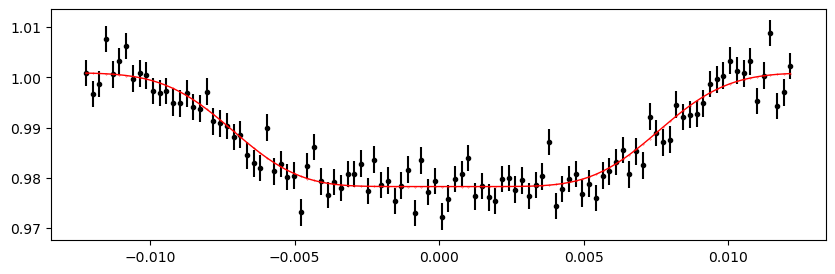

2662.022224 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 384.13it/s]


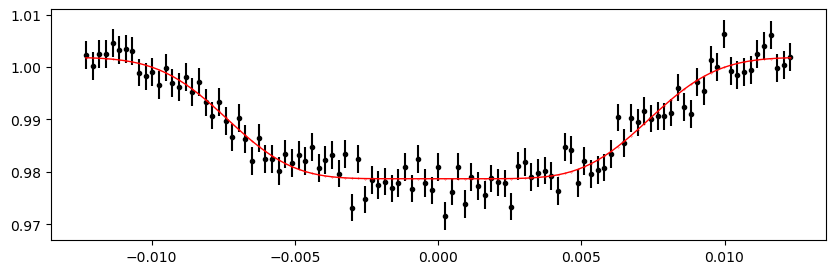

2673.993408 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 375.83it/s]


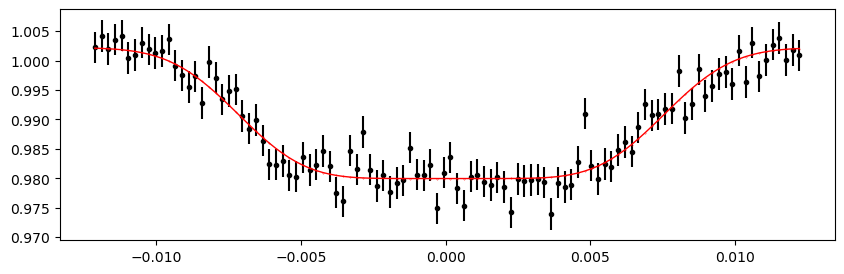

2685.964592 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 378.81it/s]


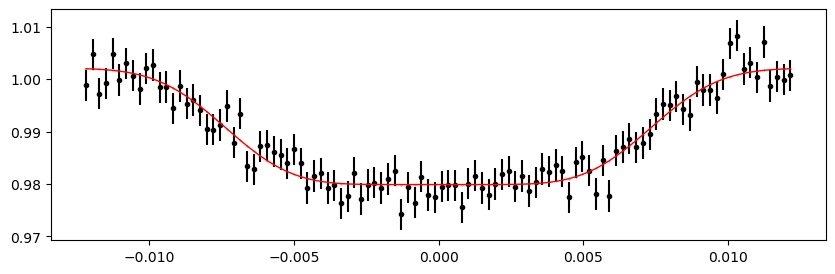

2703.921368 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 377.75it/s]


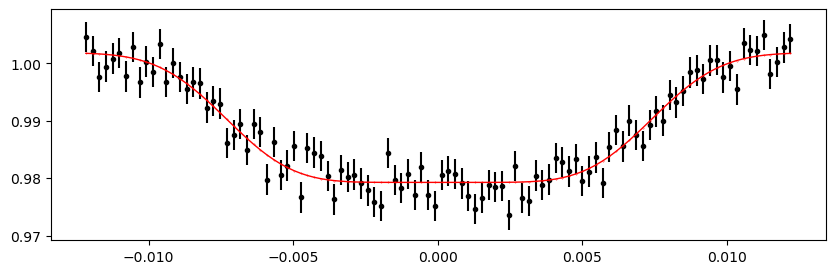

2715.892552 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 376.87it/s]


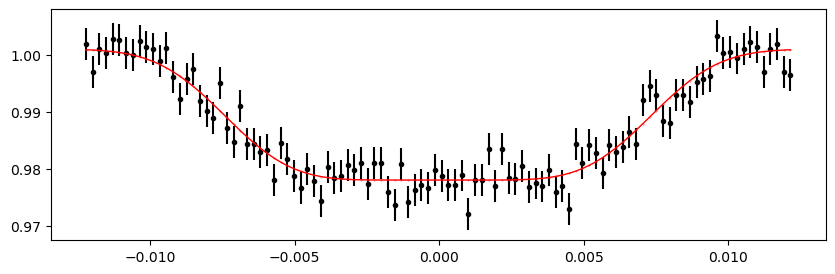

2721.878144 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 380.68it/s]


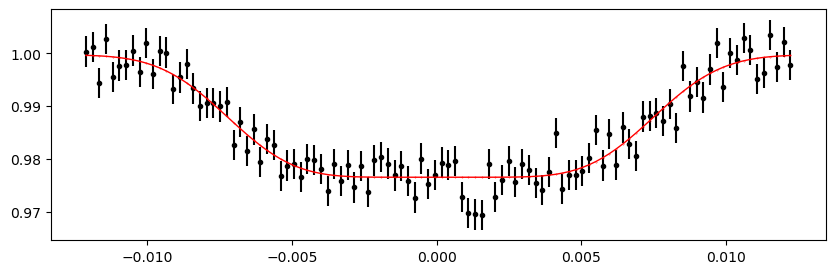

2727.863736 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 379.09it/s]


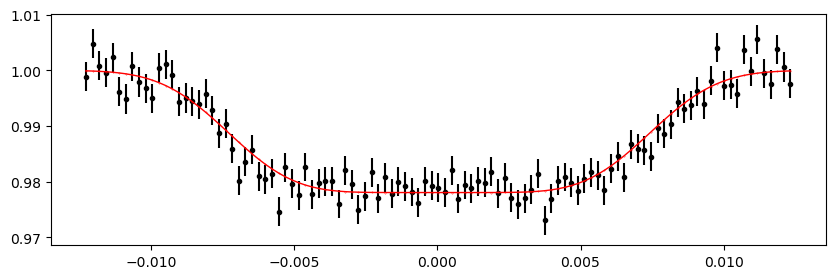

2733.849328 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 373.77it/s]


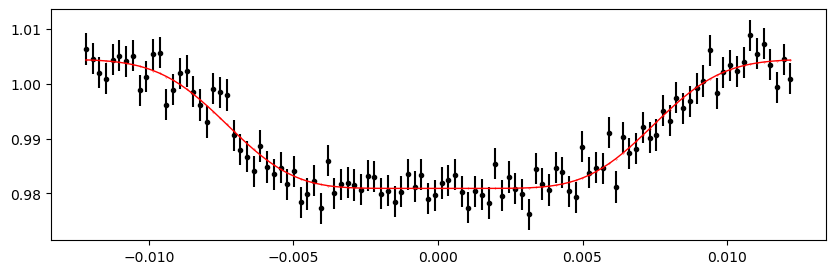

2739.83492 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 371.24it/s]


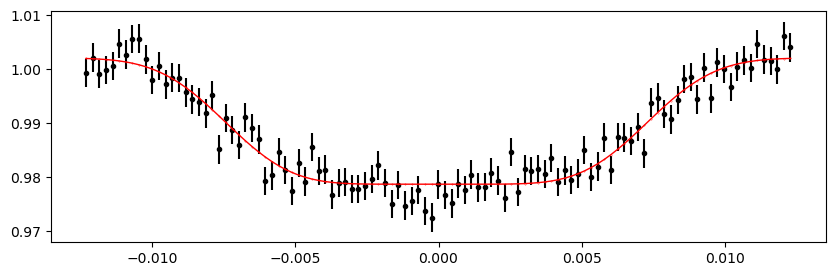

2751.806104 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 379.07it/s]


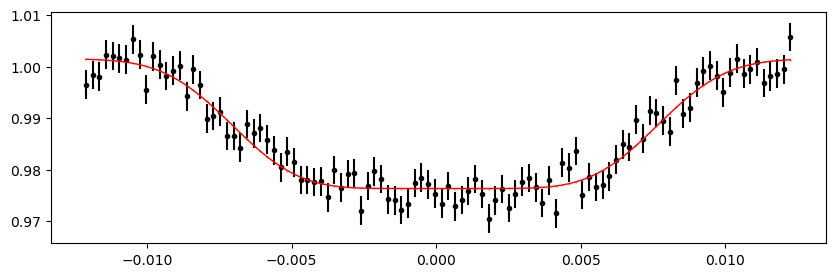

2763.7772879999998 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 381.68it/s]


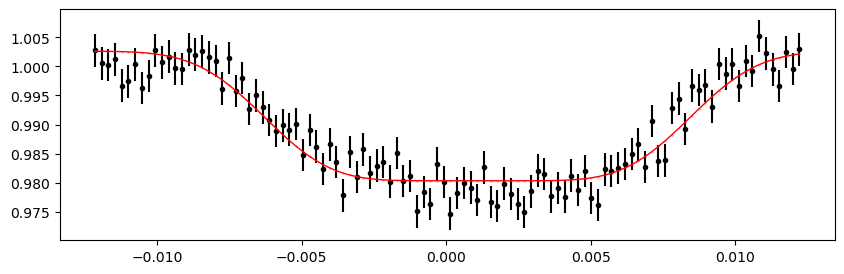

2799.6908399999998 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 380.25it/s]


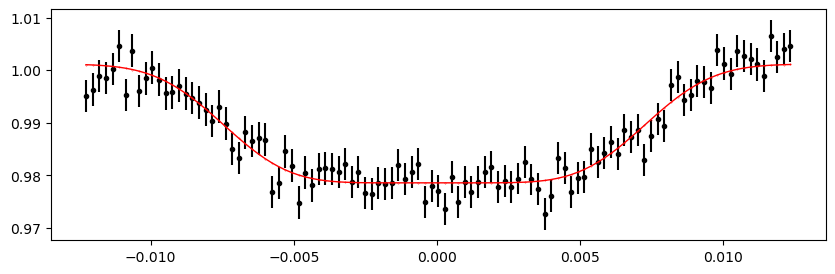

2805.6764319999997 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 386.09it/s]


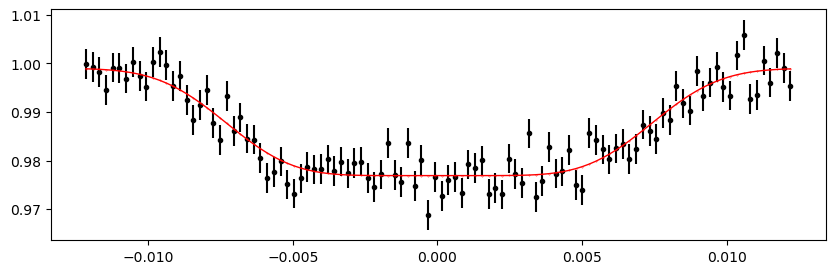

2811.6620239999997 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 377.45it/s]


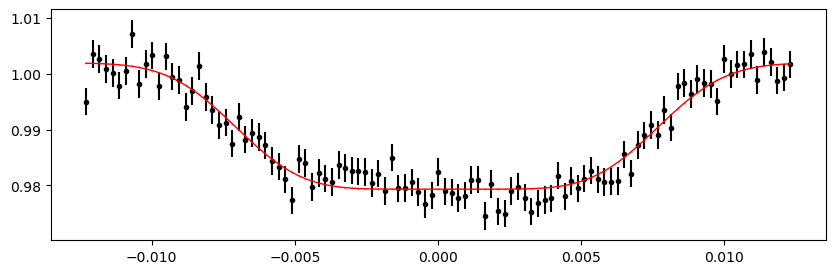

2817.6476159999997 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 378.45it/s]


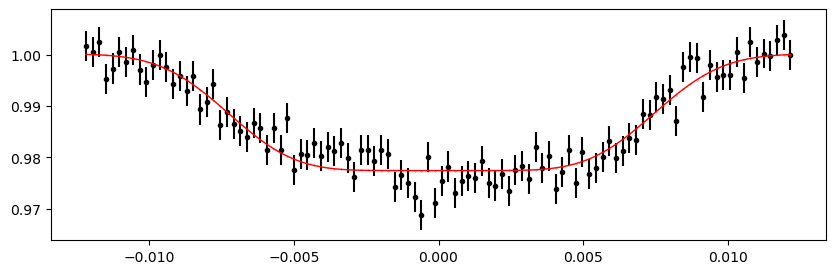

2823.6332079999997 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 376.93it/s]


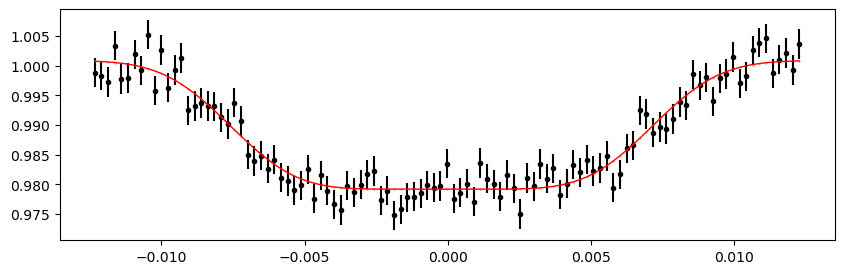

2829.6187999999997 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 381.76it/s]


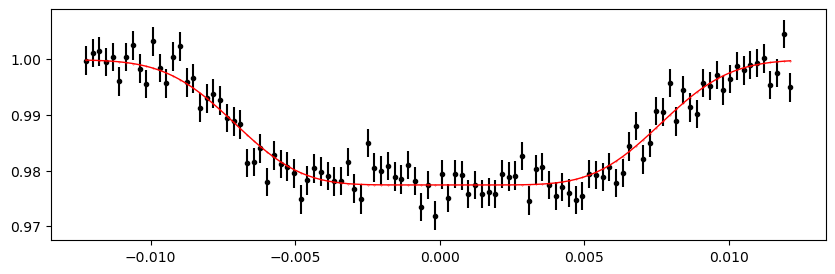

2835.6043919999997 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 383.51it/s]


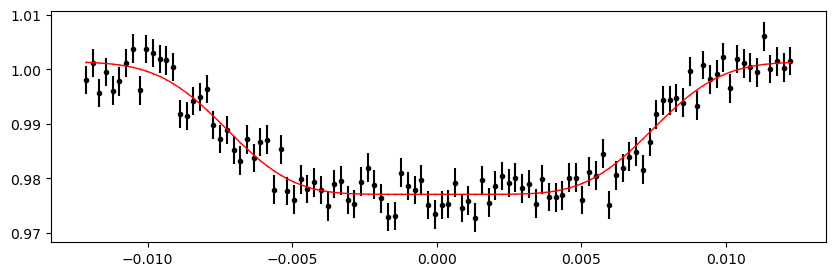

2841.5899839999997 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 380.34it/s]


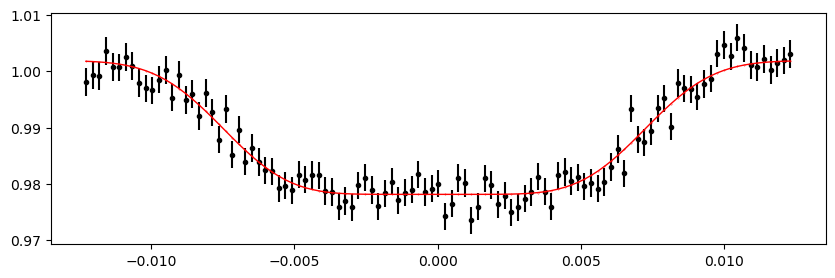

2847.5755759999997 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 384.96it/s]


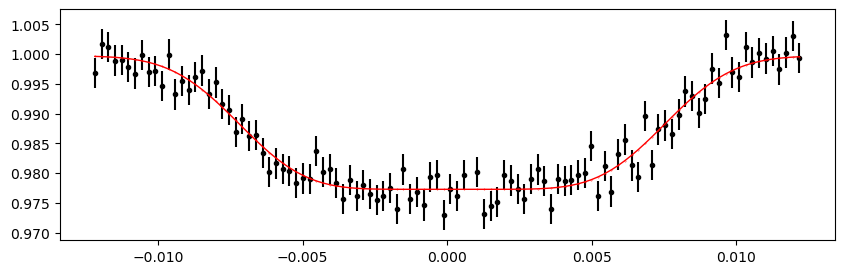

2853.5611679999997 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 382.34it/s]


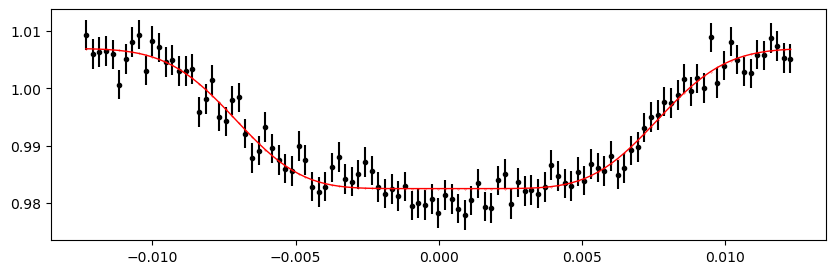

2859.5467599999997 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 375.29it/s]


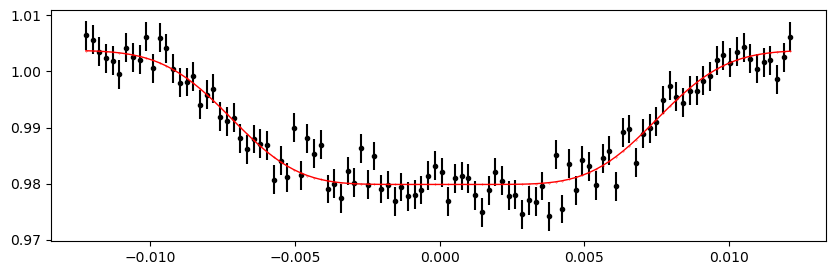

2871.5179439999997 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 375.78it/s]


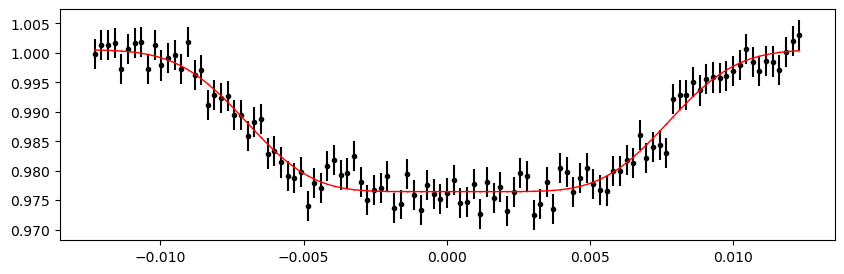

2877.5035359999997 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 379.13it/s]


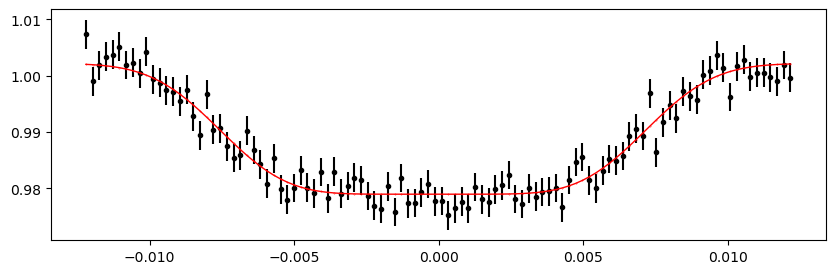

2883.4891279999997 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 376.45it/s]


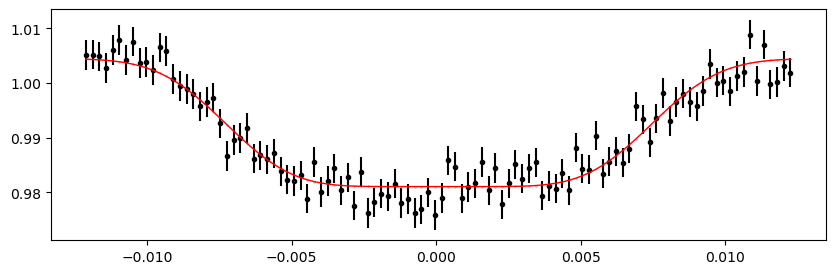

2889.4747199999997 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 484.23it/s]


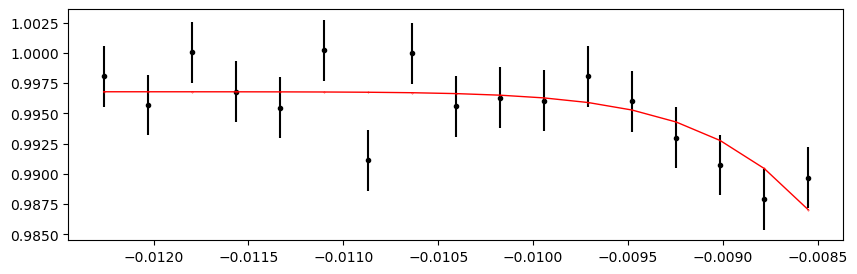

2895.4603119999997 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 377.97it/s]


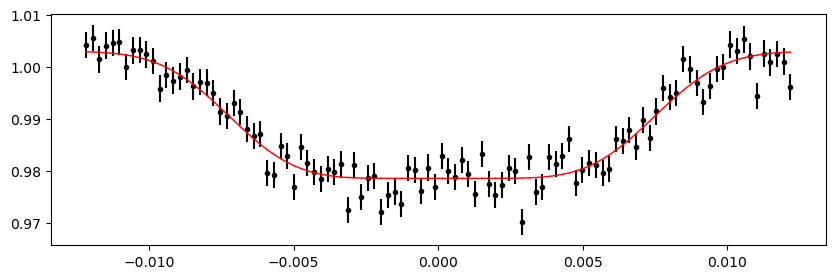

2901.4459039999997 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 372.74it/s]


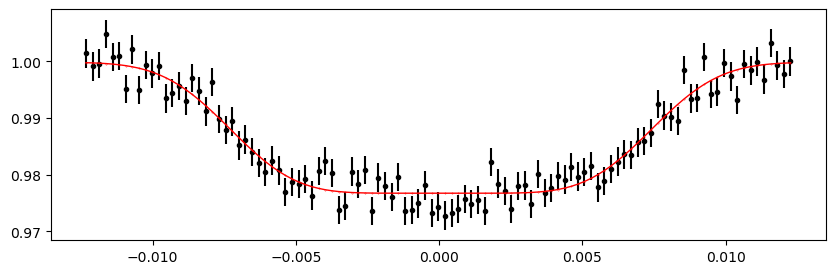

2907.4314959999997 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 378.22it/s]


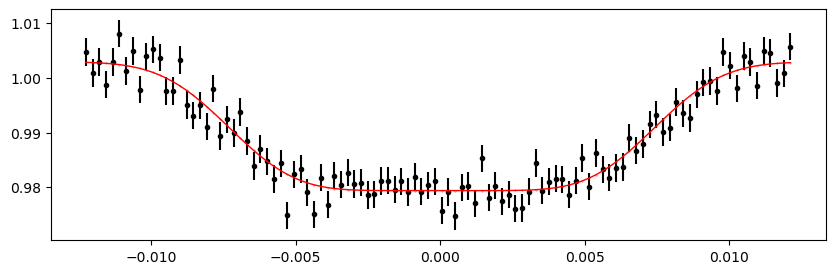

2913.4170879999997 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 377.11it/s]


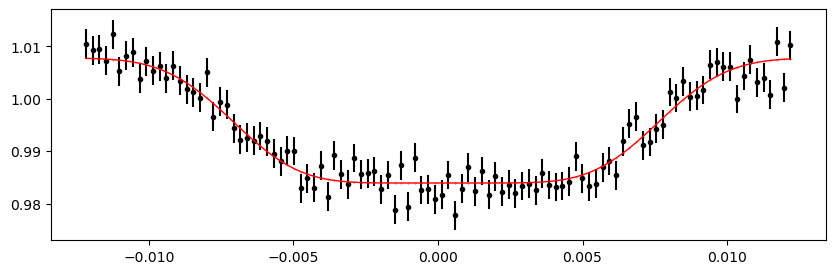

2919.4026799999997 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 380.82it/s]


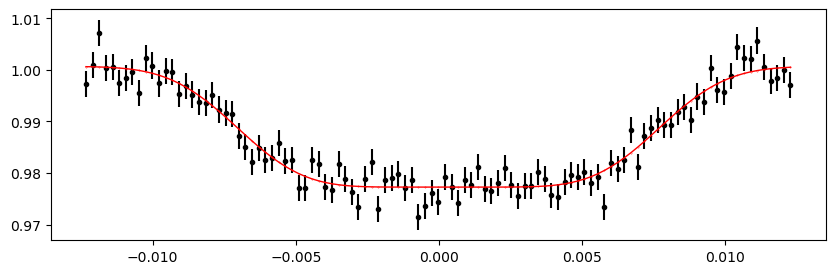

2931.3738639999997 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 383.87it/s]


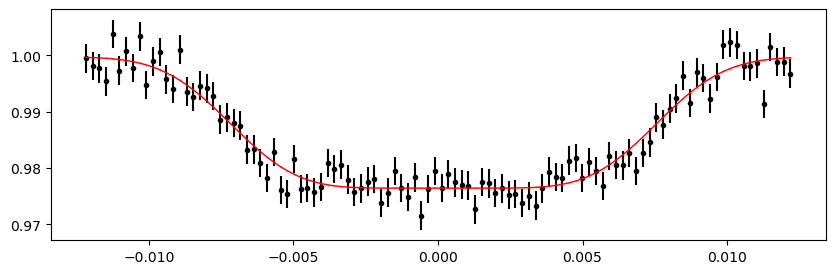

2943.3450479999997 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 381.22it/s]


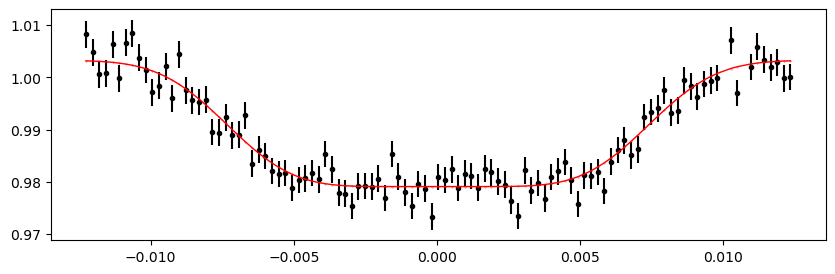

2949.3306399999997 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 379.36it/s]


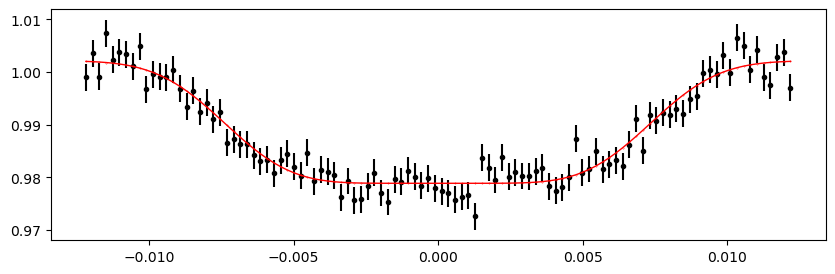

2955.3162319999997 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 379.57it/s]


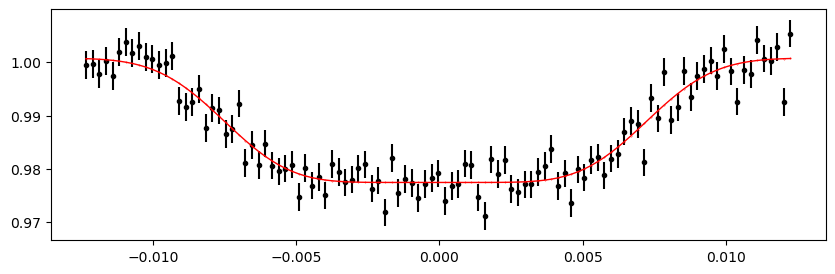

2961.3018239999997 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 376.85it/s]


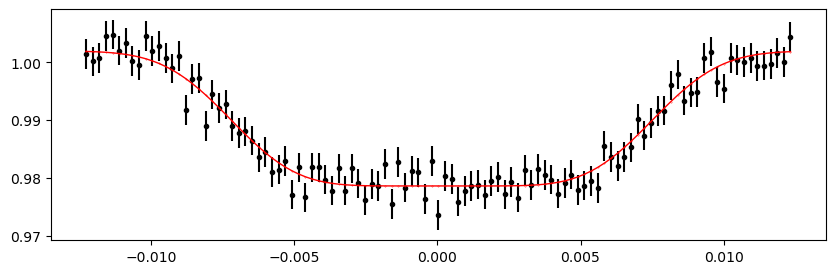

3296.494976 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 375.25it/s]


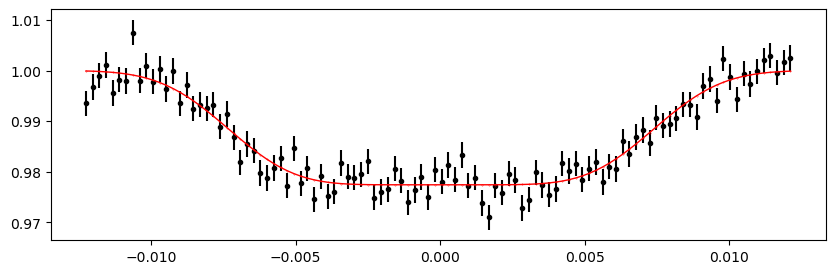

3308.46616 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 381.72it/s]


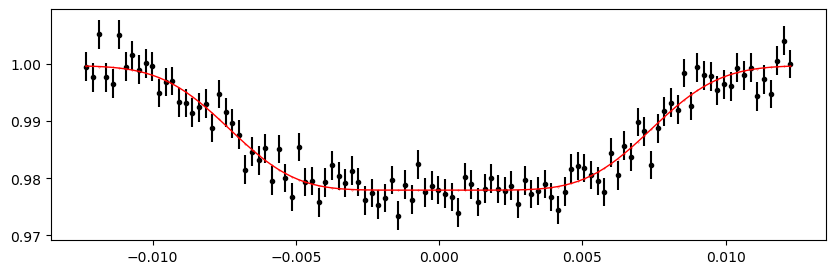

3314.451752 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 384.64it/s]


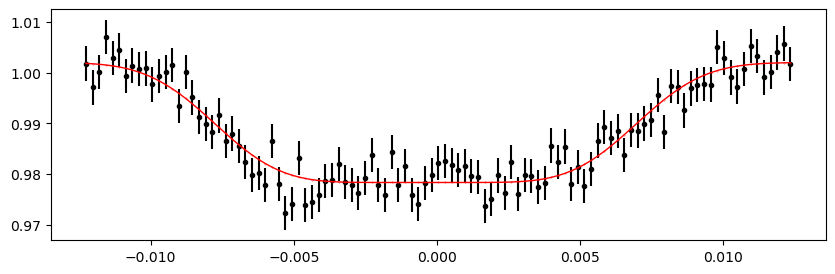

3320.437344 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 385.22it/s]


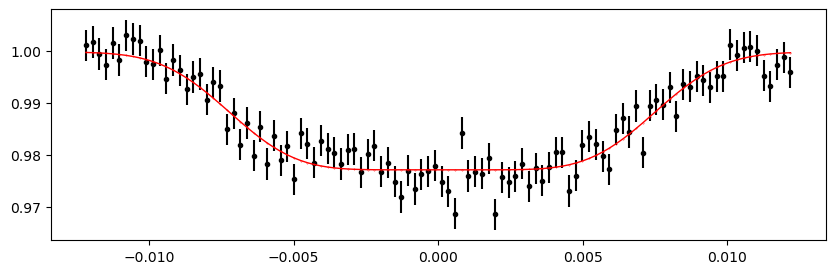

3326.422936 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 385.97it/s]


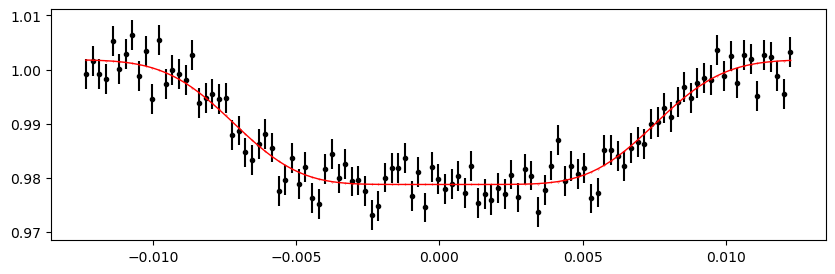

3332.408528 1.0009784718755586 -0.022773140717388562 0.2196196601513669


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 388.70it/s]


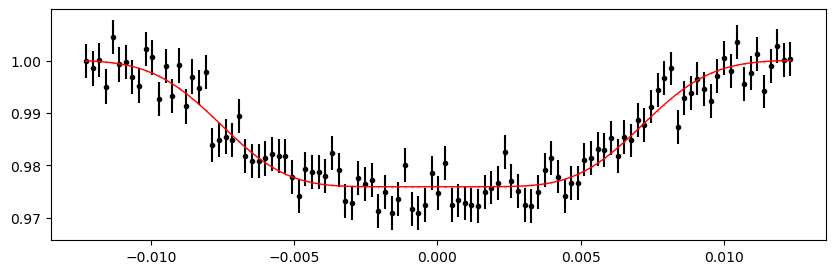

Fitting individual secondary eclipses...
Existing manifest file found, will skip previously processed LCs and append to end of manifest file
Number 0 has already been completed -- skip
Number 1 has already been completed -- skip
Number 2 has already been completed -- skip
Number 3 has already been completed -- skip
Number 4 has already been completed -- skip
Number 5 has already been completed -- skip
Number 6 has already been completed -- skip
Number 7 has already been completed -- skip
Number 8 has already been completed -- skip
Number 9 has already been completed -- skip
Number 10 has already been completed -- skip
Number 12 has already been completed -- skip
Number 13 has already been completed -- skip
Number 14 has already been completed -- skip
Number 15 has already been completed -- skip
1779.2201999999997 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:18<00:00, 531.57it/s]


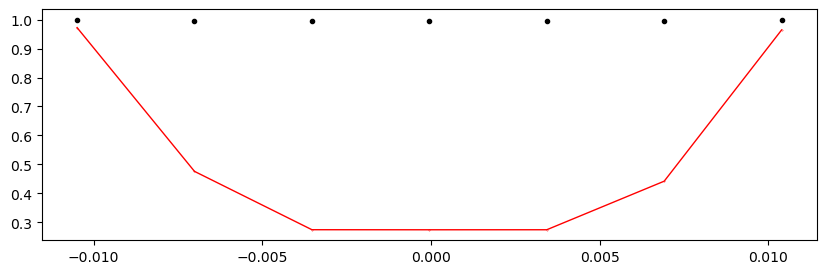

1785.2057919999997 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:18<00:00, 547.24it/s]


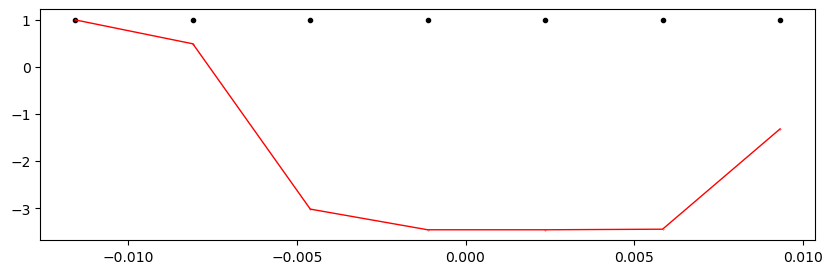

1797.1769759999997 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:18<00:00, 535.43it/s]


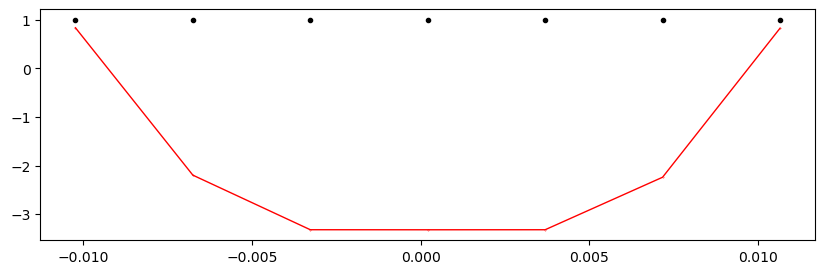

1809.1481599999997 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 448.64it/s]


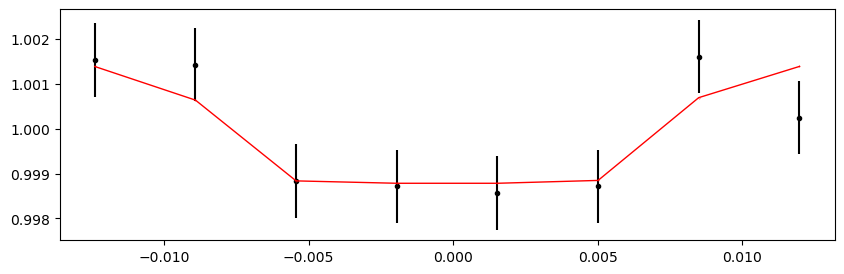

1821.1193439999997 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 462.74it/s]


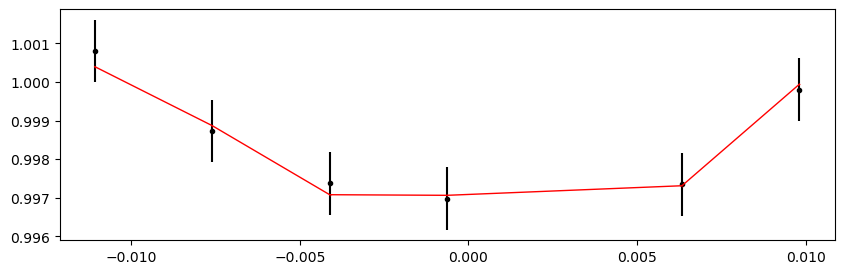

1827.1049359999997 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 443.39it/s]


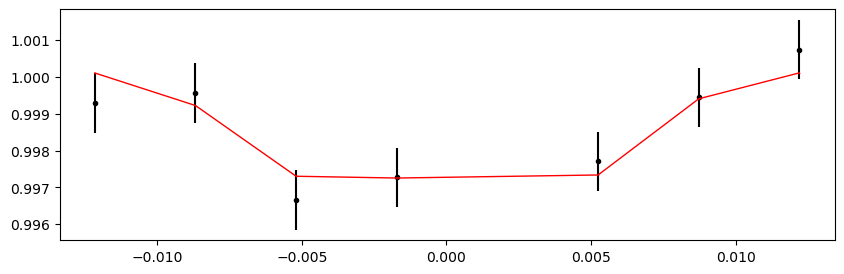

1833.0905279999997 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 449.40it/s]


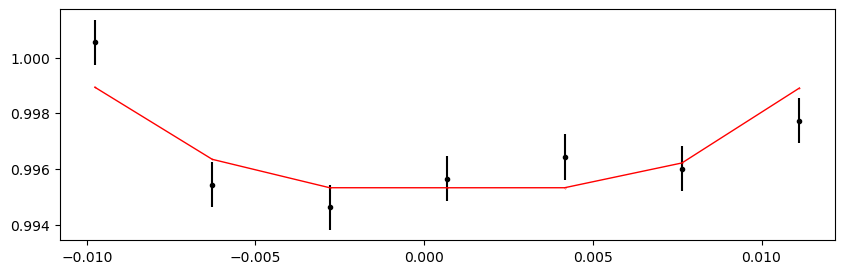

1839.0761199999997 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 448.04it/s]


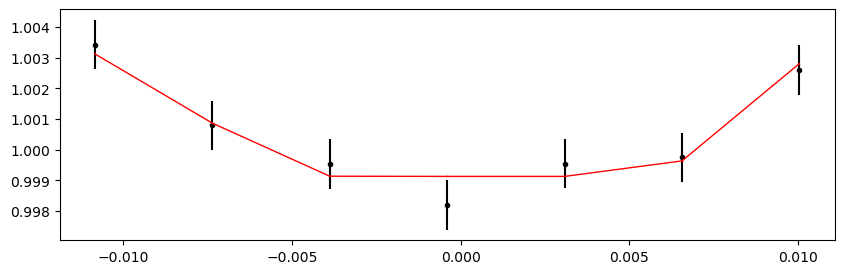

1845.0617119999997 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:18<00:00, 536.89it/s]


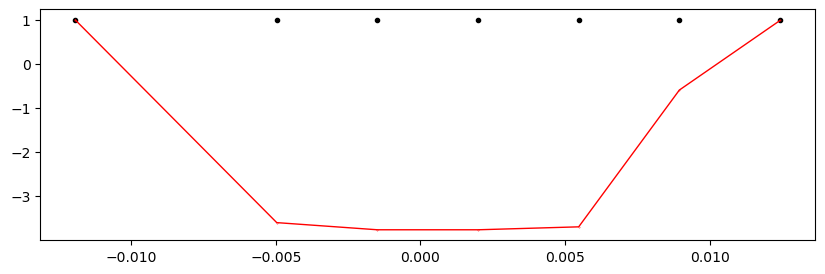

1851.0473039999997 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 522.81it/s]


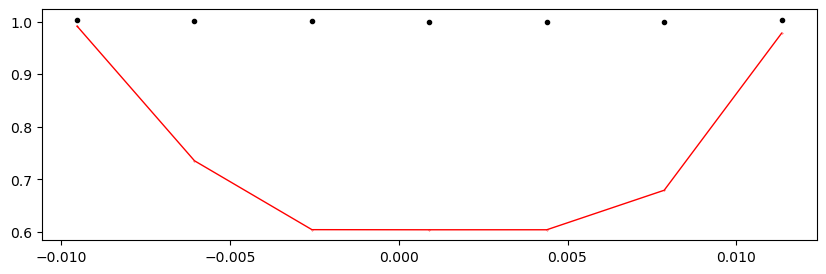

1857.0328959999997 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:18<00:00, 541.49it/s]


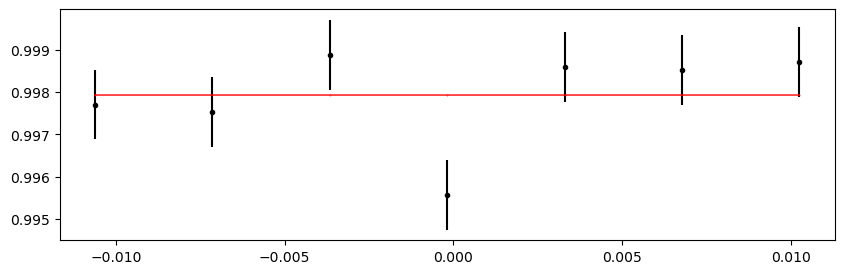

1863.0184879999997 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 449.02it/s]


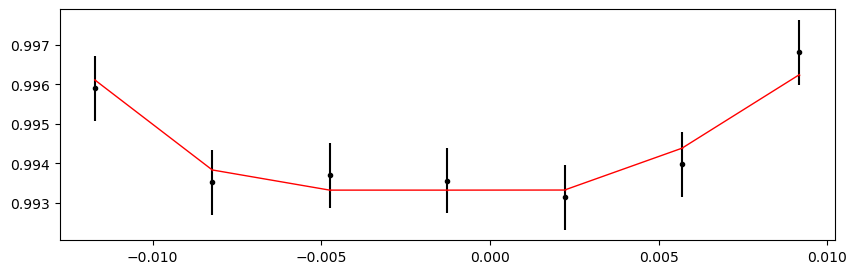

1874.9896719999997 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:17<00:00, 556.34it/s]


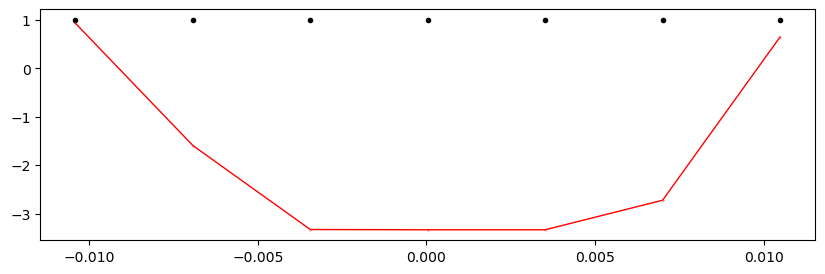

1880.9752639999997 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:18<00:00, 540.98it/s]


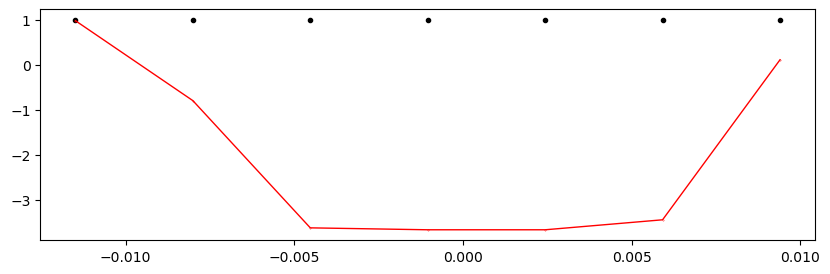

1886.9608559999997 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:18<00:00, 547.81it/s]


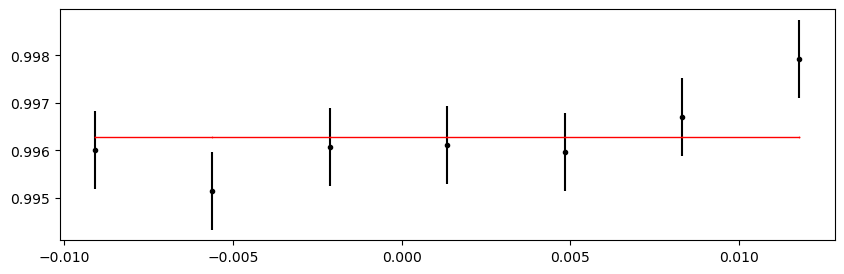

1892.9464479999997 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:18<00:00, 548.92it/s]


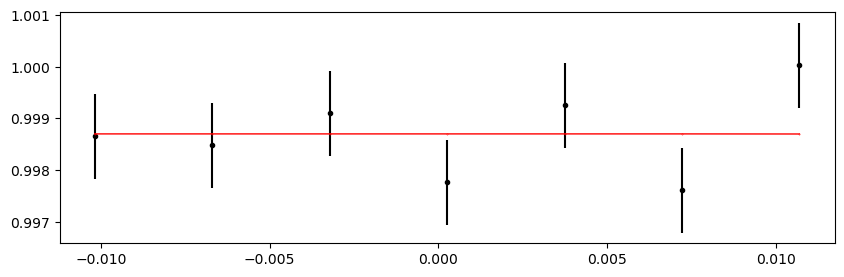

1904.9176319999997 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:18<00:00, 527.34it/s]


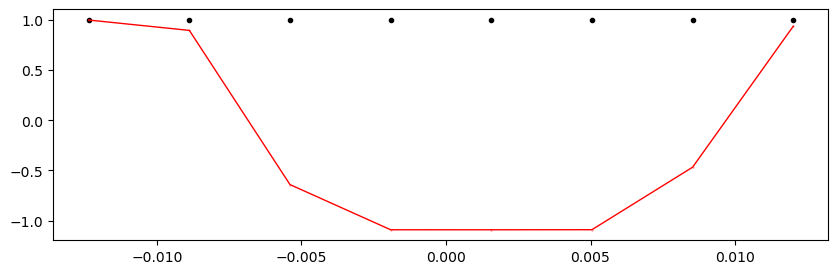

1910.9032239999997 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:18<00:00, 550.58it/s]


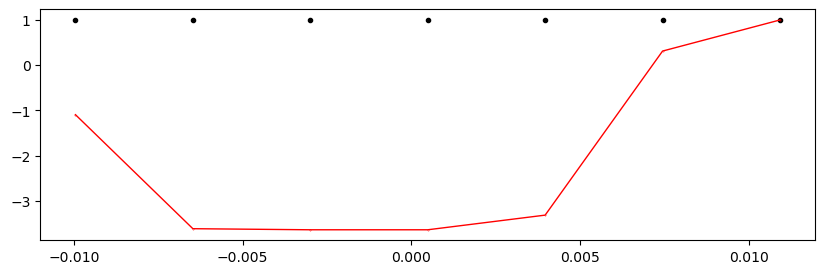

1916.8888159999997 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:18<00:00, 547.85it/s]


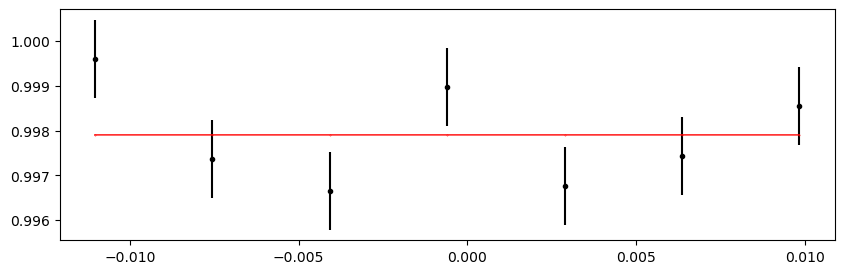

1922.8744079999997 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 508.81it/s]


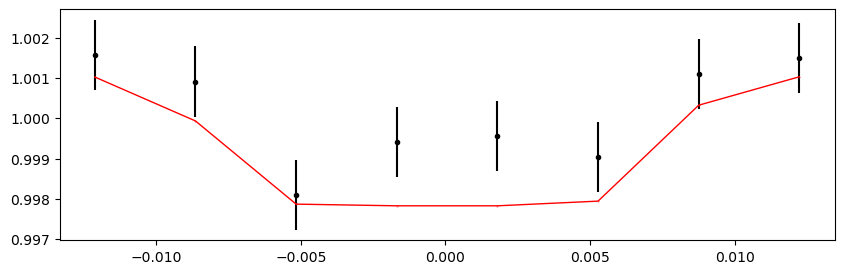

1934.8455919999997 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 482.98it/s]


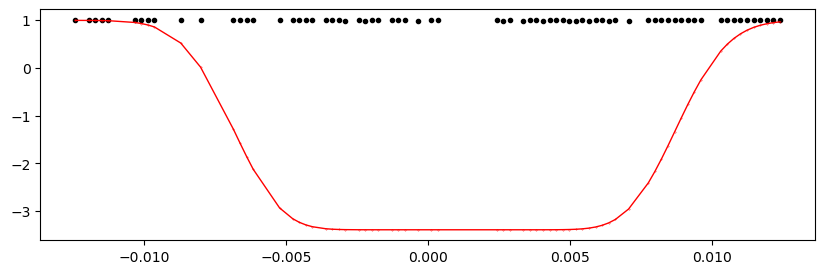

1940.8311839999997 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 438.31it/s]


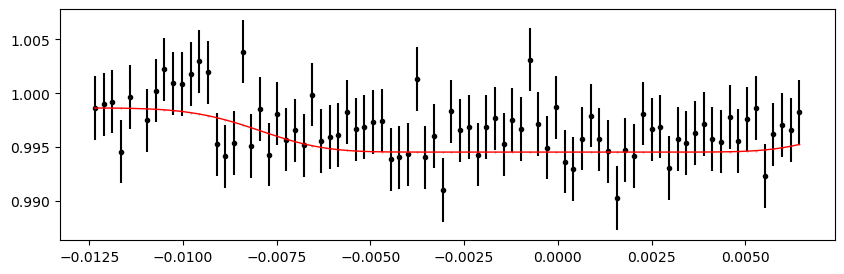

1946.8167759999997 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 460.05it/s]


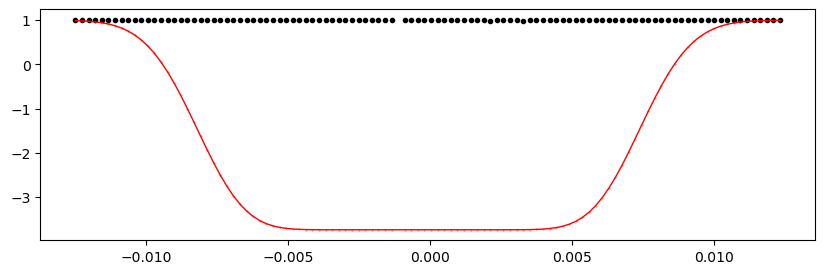

1952.8023679999997 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 376.93it/s]


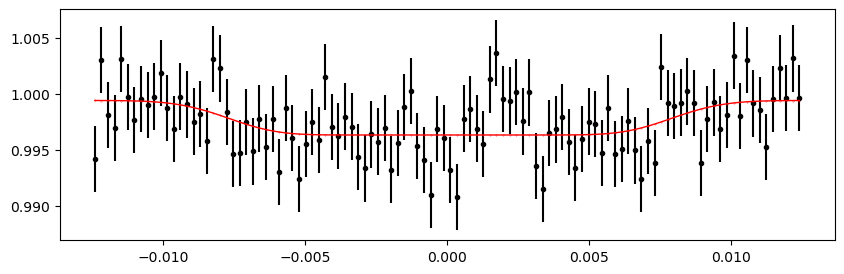

1958.7879599999997 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 458.77it/s]


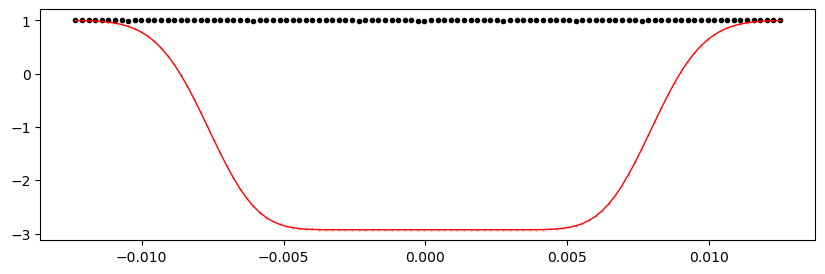

1964.7735519999997 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 456.58it/s]


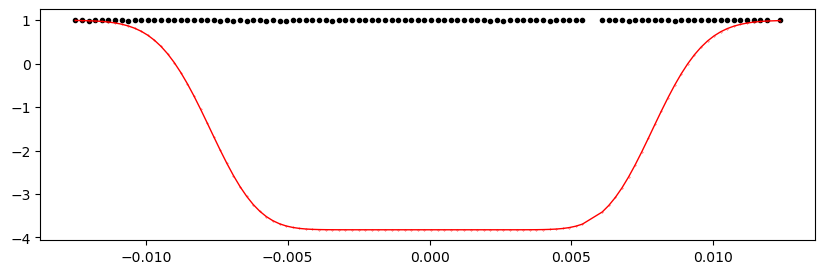

1970.7591439999997 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 463.63it/s]


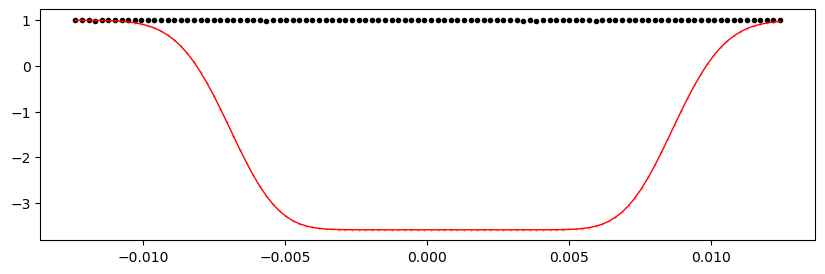

1976.7447359999996 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 412.80it/s]


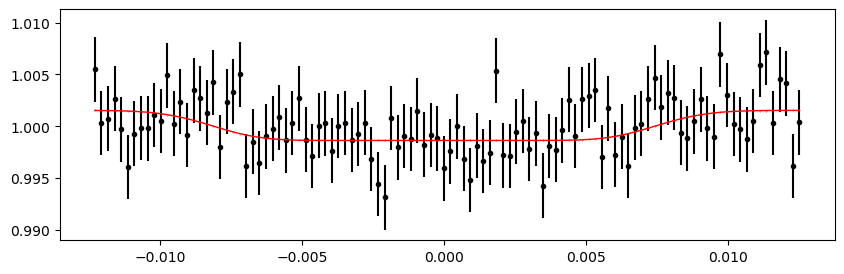

1988.7159199999996 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 377.48it/s]


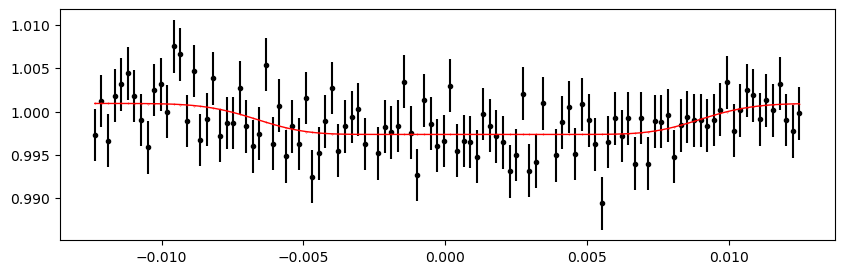

1994.7015119999996 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 463.73it/s]


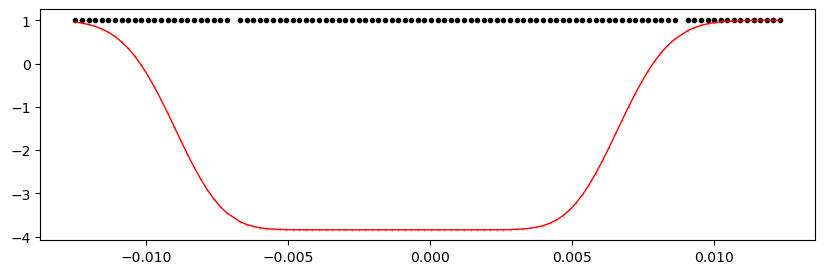

2000.6871039999996 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 465.87it/s]


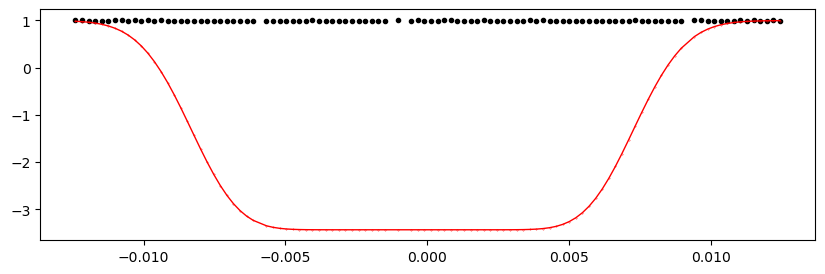

2006.6726959999999 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 375.03it/s]


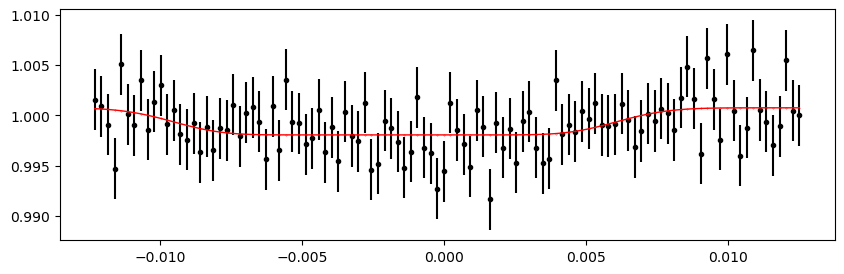

2012.6582879999999 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 420.09it/s]


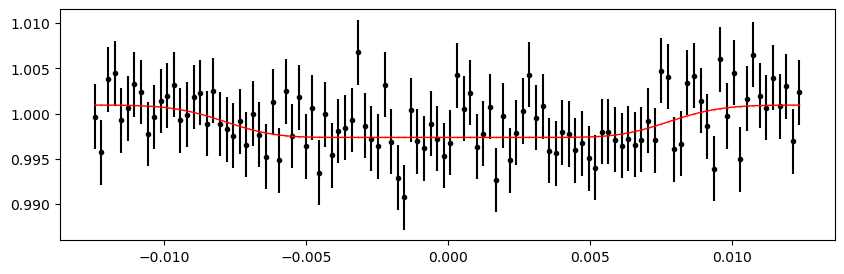

2018.6438799999999 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 379.71it/s]


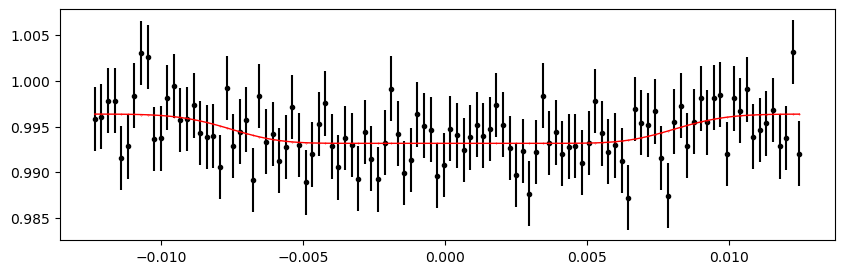

2024.6294719999999 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 431.91it/s]


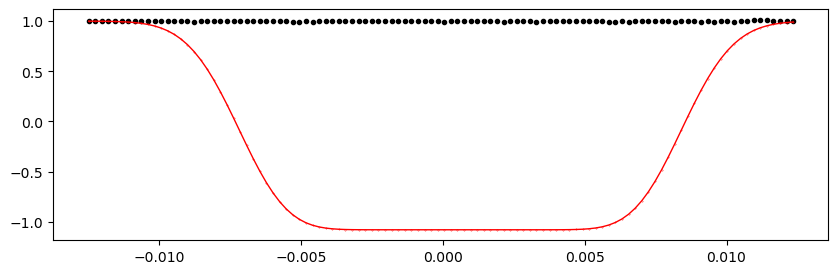

2030.6150639999998 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 372.13it/s]


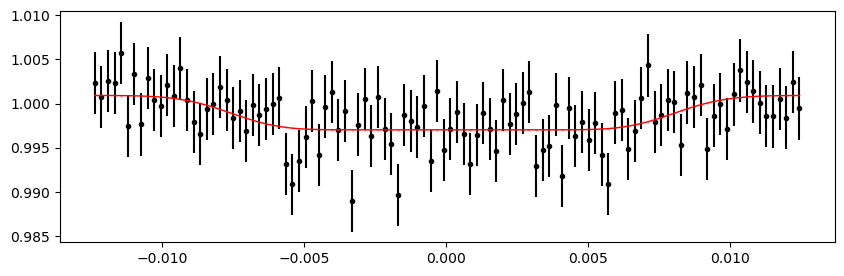

2395.736176 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 378.59it/s]


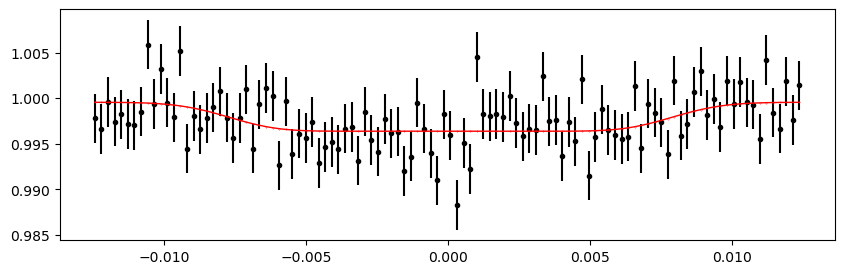

2401.721768 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 378.24it/s]


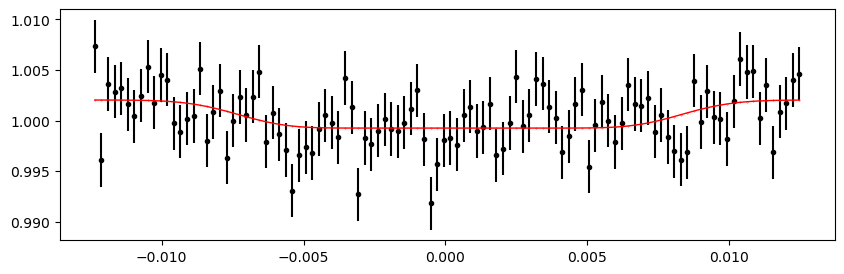

2407.70736 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 382.42it/s]


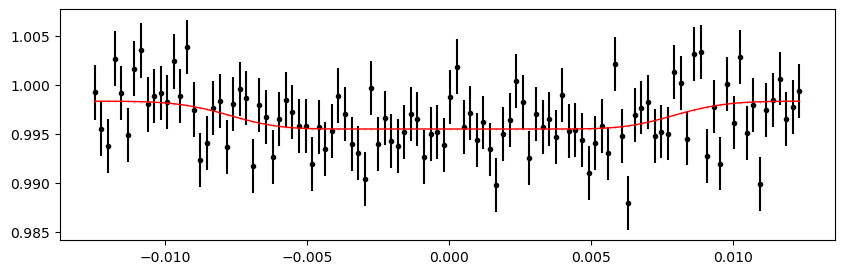

2413.692952 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 380.53it/s]


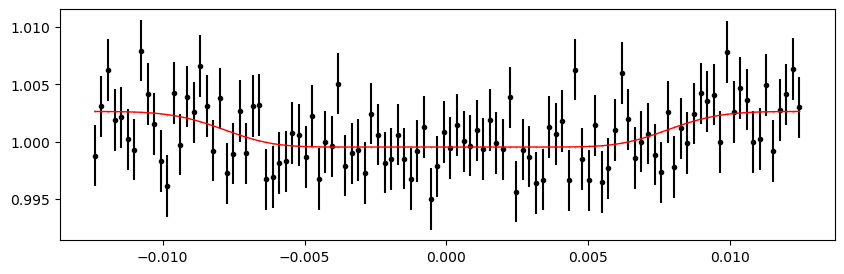

2425.664136 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 377.86it/s]


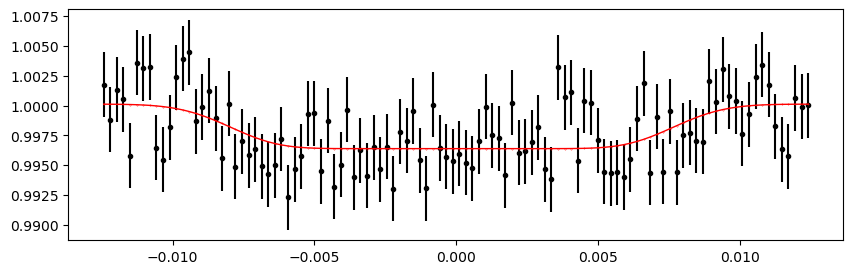

2431.649728 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 380.35it/s]


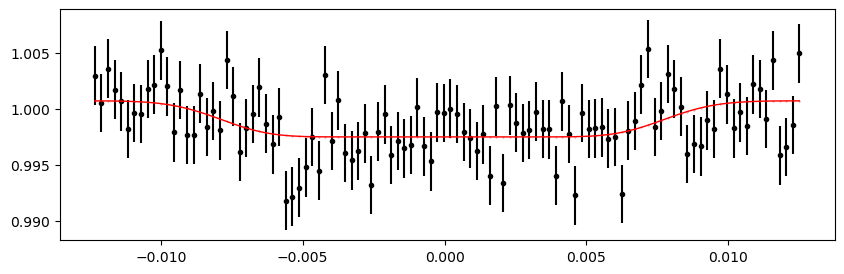

2437.63532 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 384.00it/s]


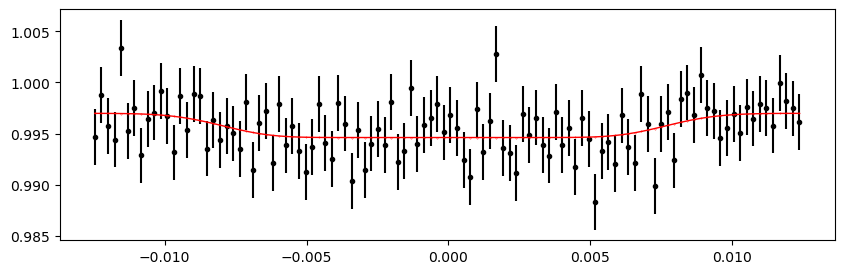

2443.620912 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 436.07it/s]


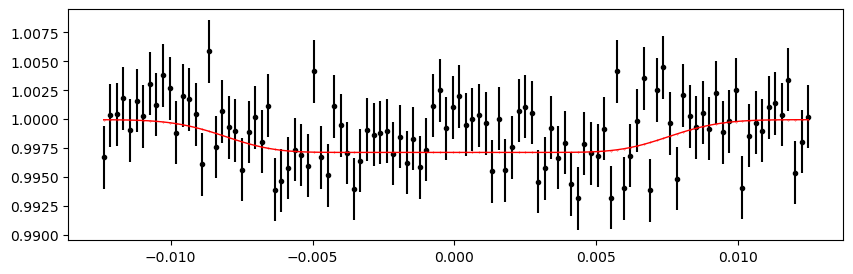

2587.27512 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 385.33it/s]


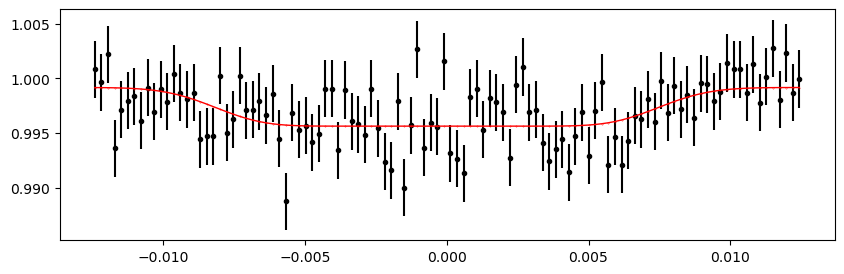

2599.246304 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 385.13it/s]


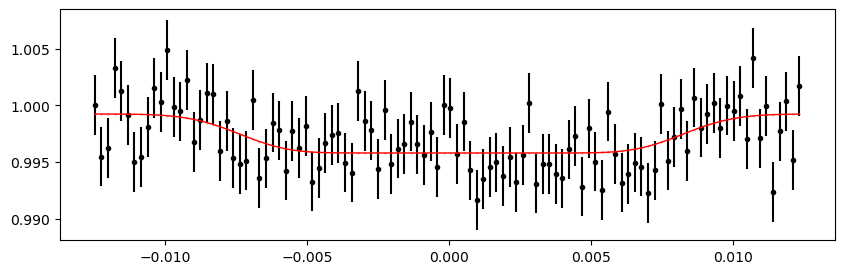

2605.231896 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 387.45it/s]


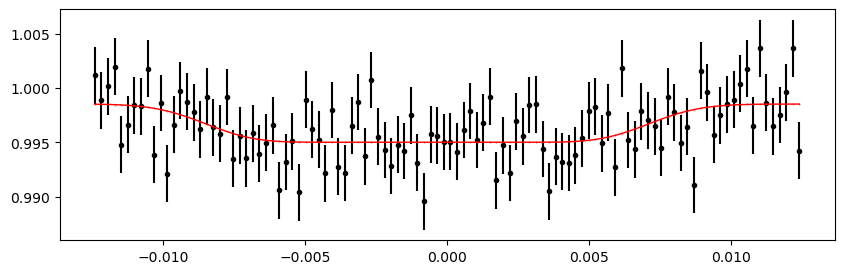

2617.2030799999998 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 387.48it/s]


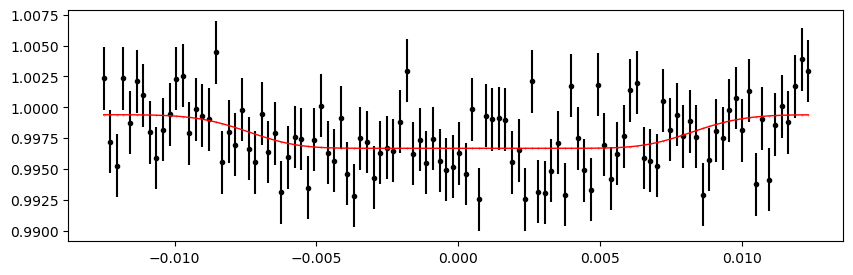

2629.1742639999998 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 411.75it/s]


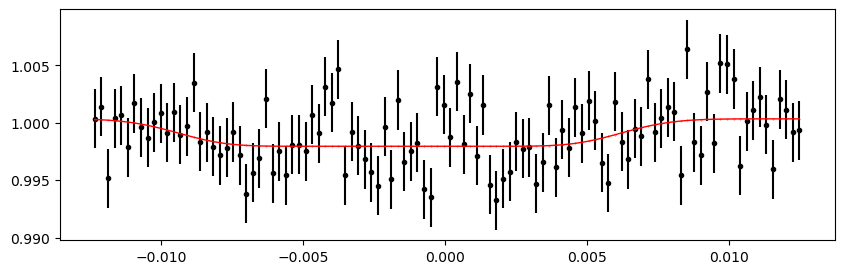

2635.1598559999998 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 389.10it/s]


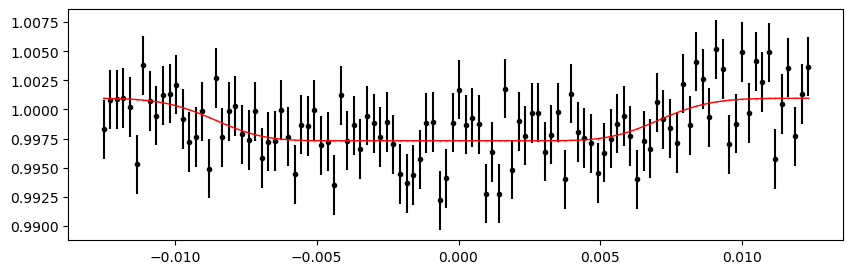

2647.1310399999998 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 459.16it/s]


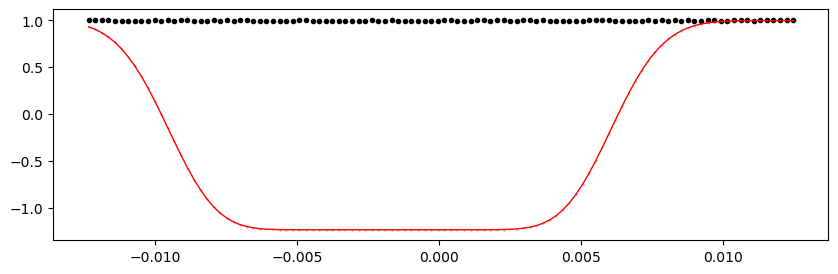

2659.1022239999998 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 387.04it/s]


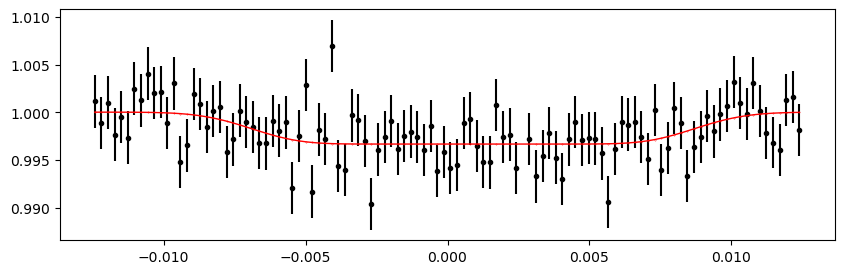

2671.0734079999997 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 524.41it/s]


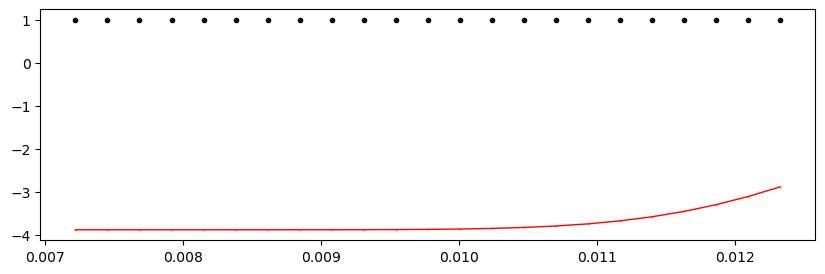

2677.0589999999997 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 465.29it/s]


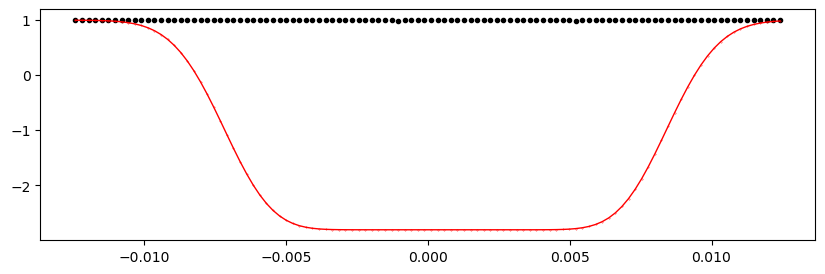

2689.0301839999997 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 391.03it/s]


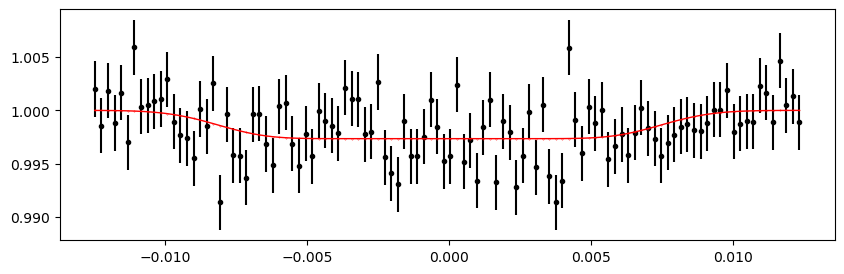

2701.0013679999997 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 393.22it/s]


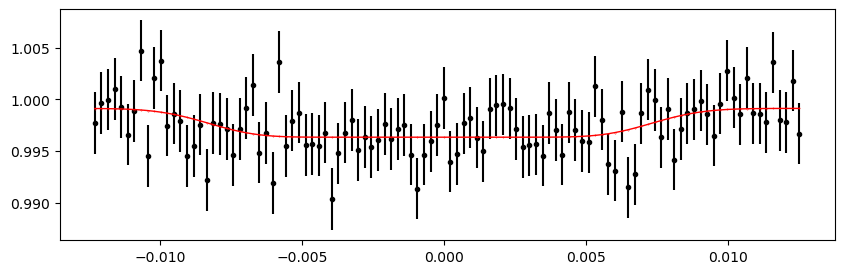

2712.9725519999997 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 437.81it/s]


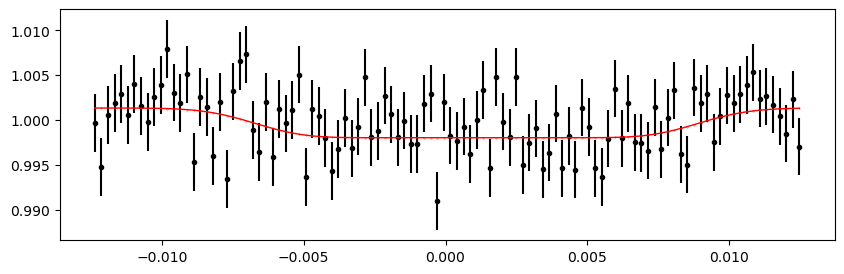

2718.9581439999997 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 474.36it/s]


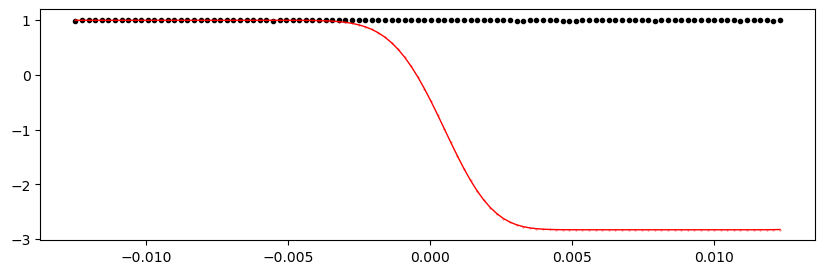

2724.9437359999997 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 387.78it/s]


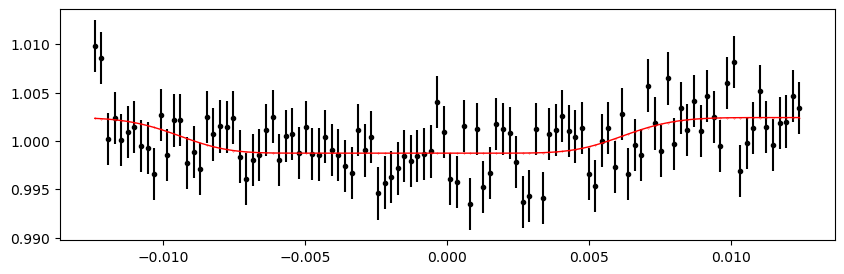

2736.9149199999997 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 381.69it/s]


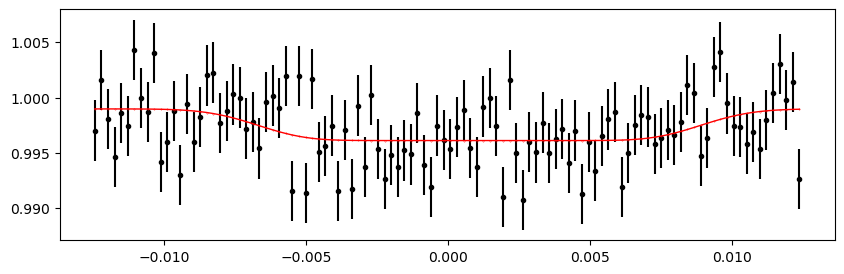

2742.9005119999997 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 384.12it/s]


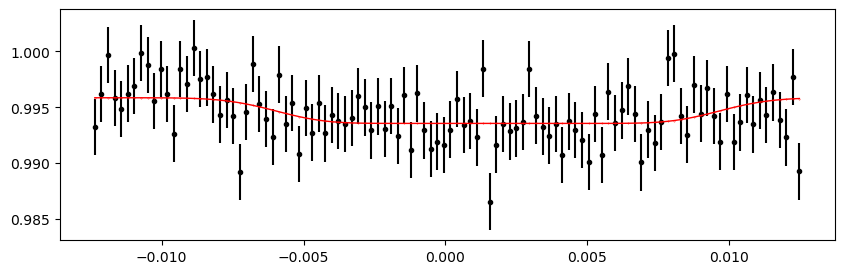

2748.8861039999997 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 457.55it/s]


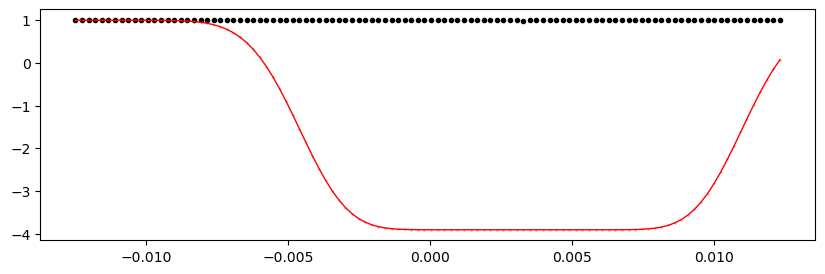

2754.8716959999997 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 386.96it/s]


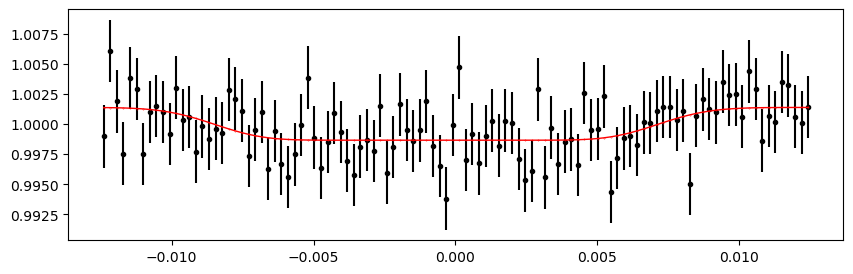

2760.8572879999997 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 463.83it/s]


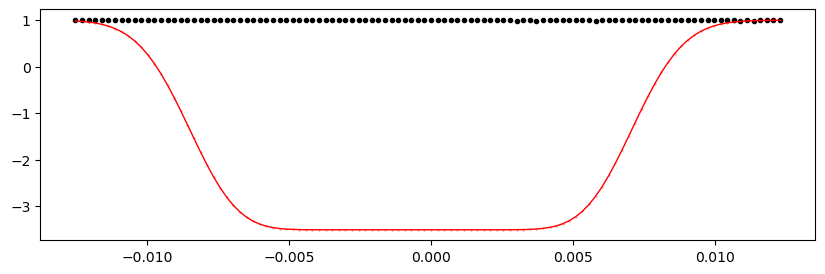

2766.8428799999997 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 379.30it/s]


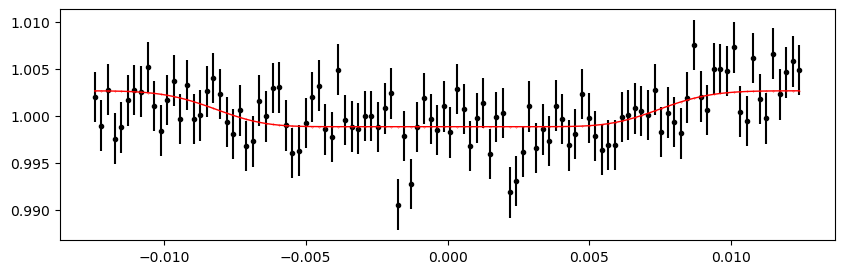

2802.7564319999997 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 386.30it/s]


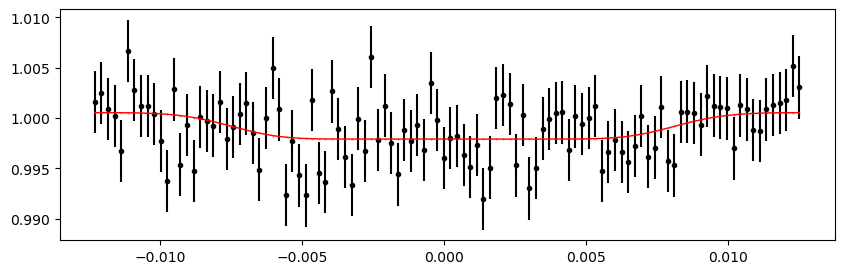

2808.7420239999997 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 386.60it/s]


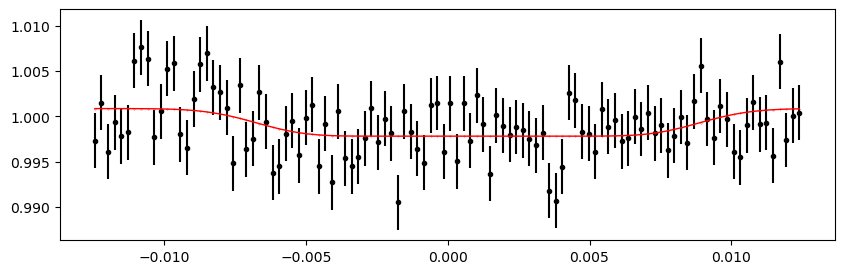

2814.7276159999997 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 469.27it/s]


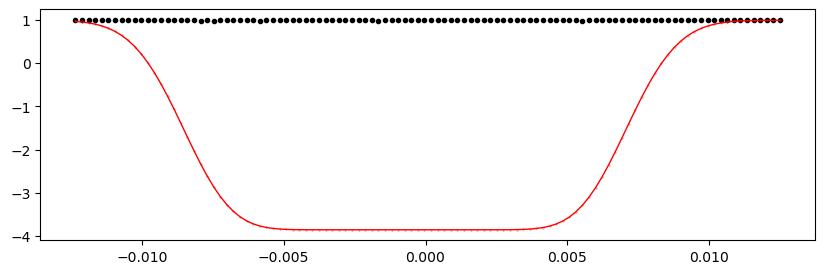

2820.7132079999997 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 417.97it/s]


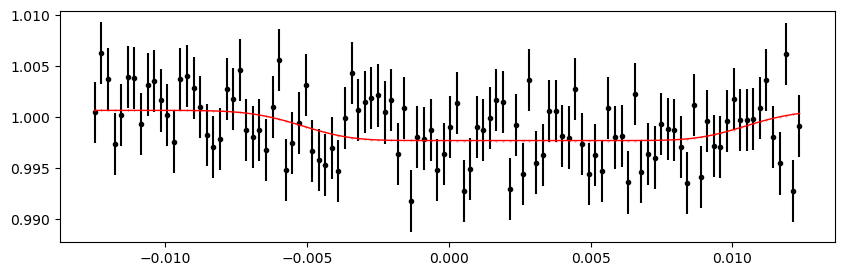

2826.6987999999997 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 383.07it/s]


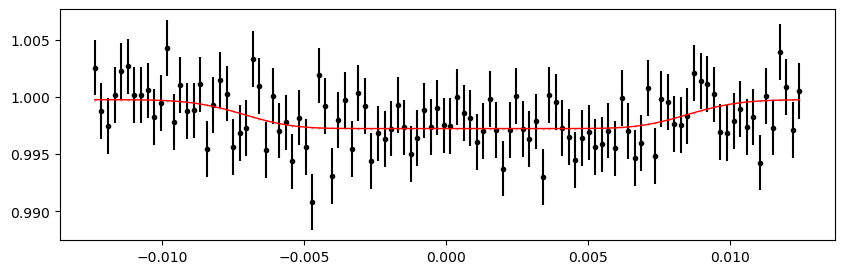

2832.6843919999997 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 384.64it/s]


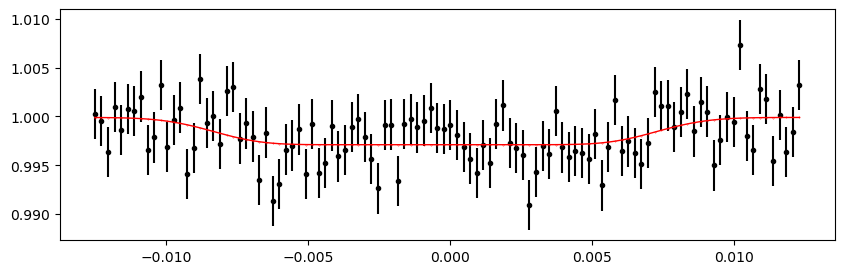

2838.6699839999997 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:18<00:00, 539.11it/s]


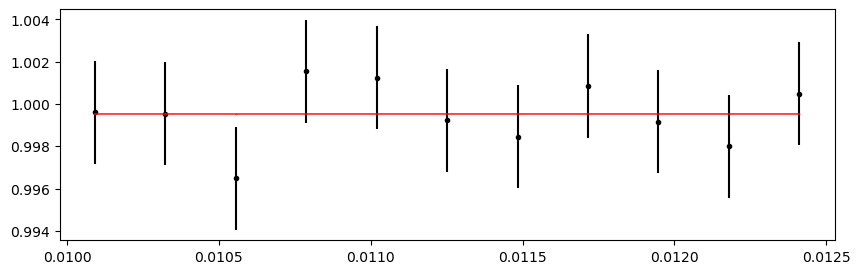

2844.6555759999997 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 388.07it/s]


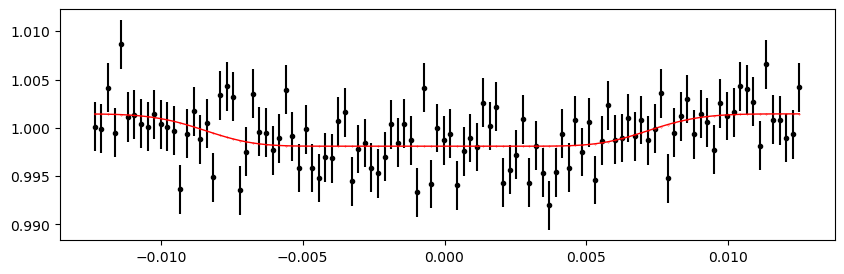

2850.6411679999997 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 384.53it/s]


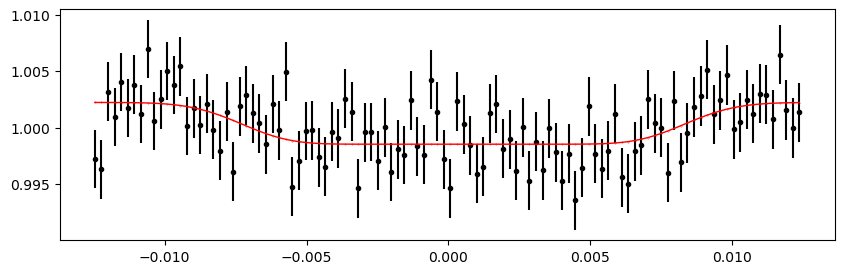

2856.6267599999996 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 377.33it/s]


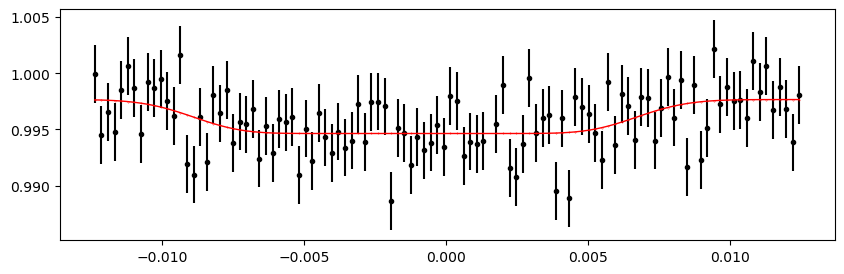

2862.6123519999996 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 387.08it/s]


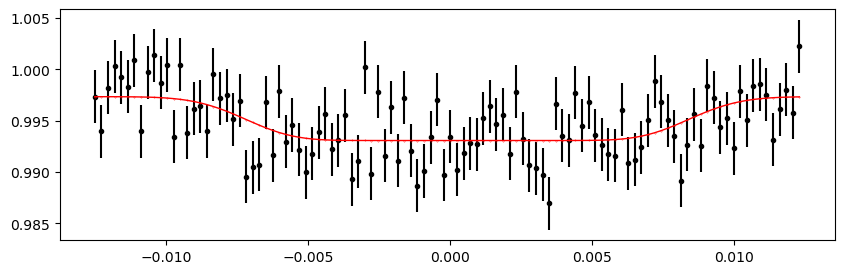

2868.5979439999996 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 381.97it/s]


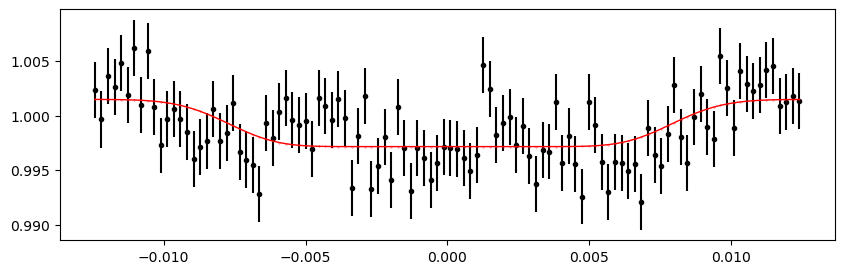

2874.5835359999996 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 492.80it/s]


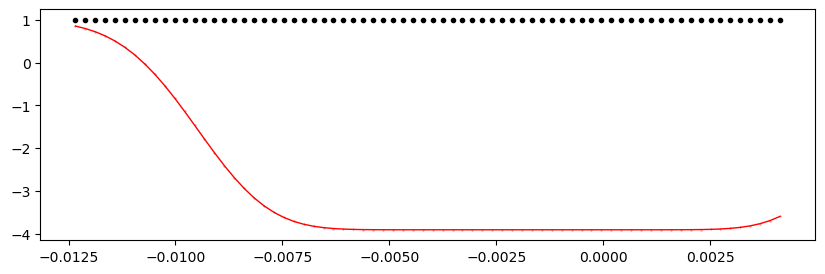

2880.5691279999996 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 383.29it/s]


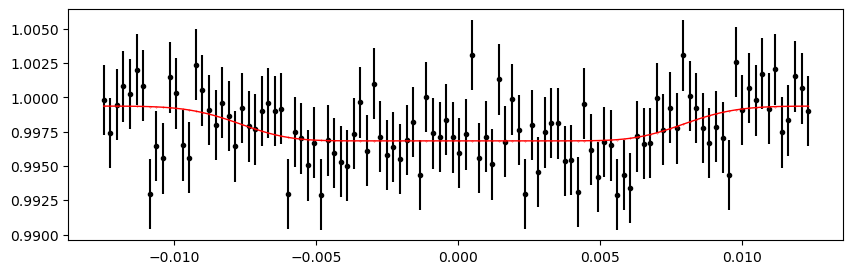

2886.5547199999996 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 481.30it/s]


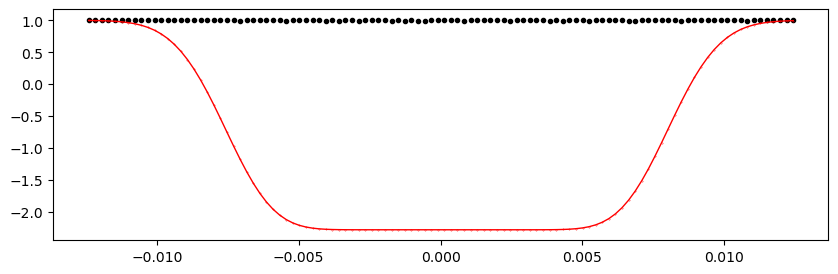

2892.5403119999996 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 466.64it/s]


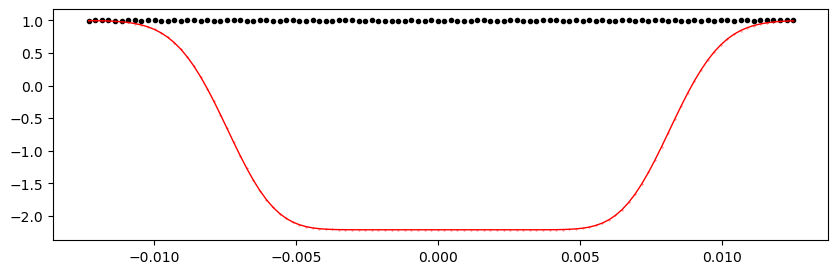

2898.5259039999996 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 384.60it/s]


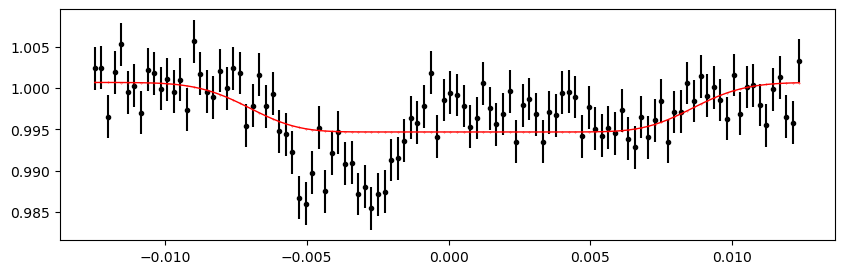

2904.5114959999996 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 388.38it/s]


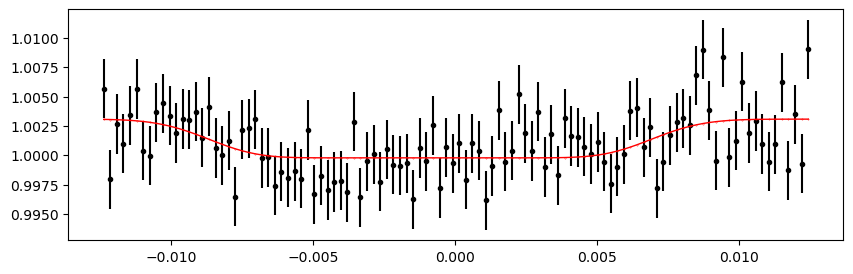

2916.4826799999996 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 387.23it/s]


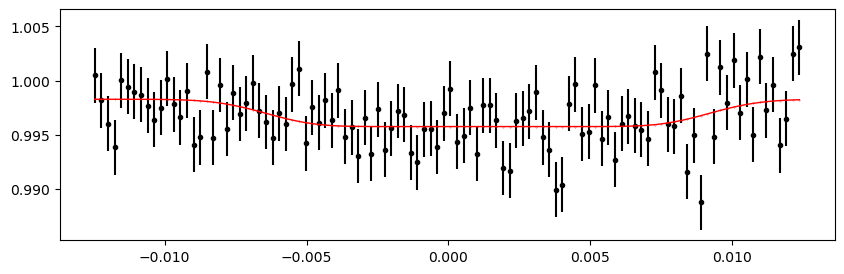

2922.4682719999996 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 387.47it/s]


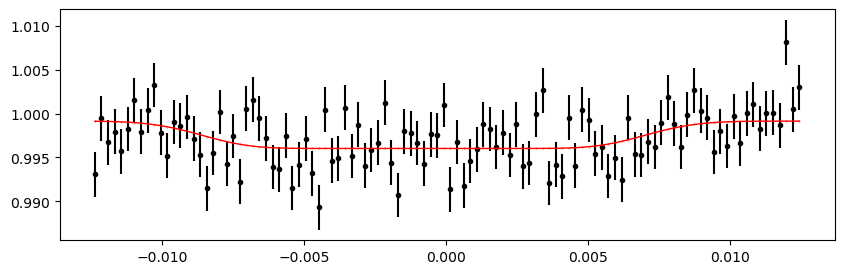

2928.4538639999996 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 386.50it/s]


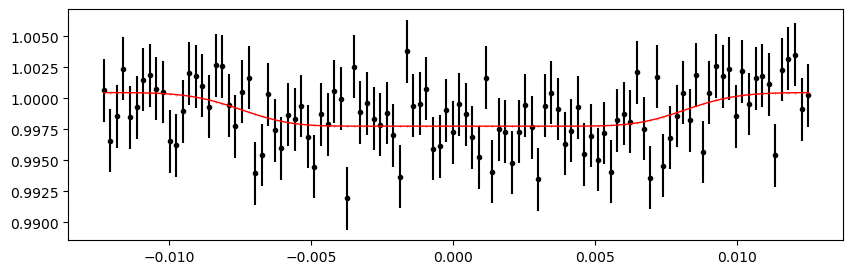

2934.4394559999996 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 387.92it/s]


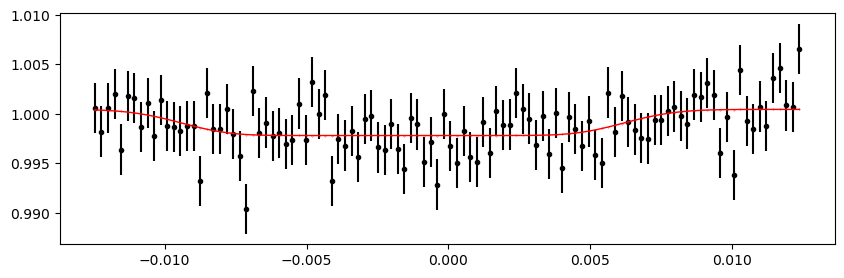

2946.4106399999996 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 449.50it/s]


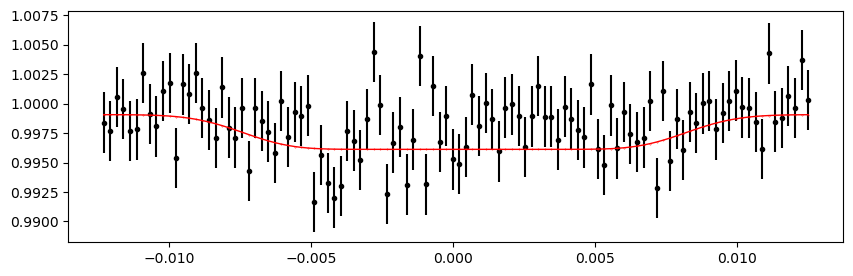

2958.3818239999996 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 386.72it/s]


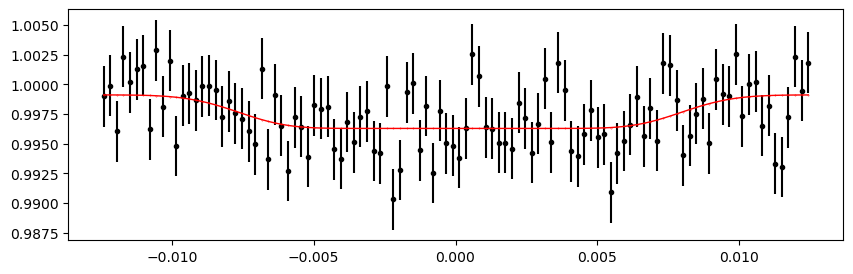

3293.574976 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 386.27it/s]


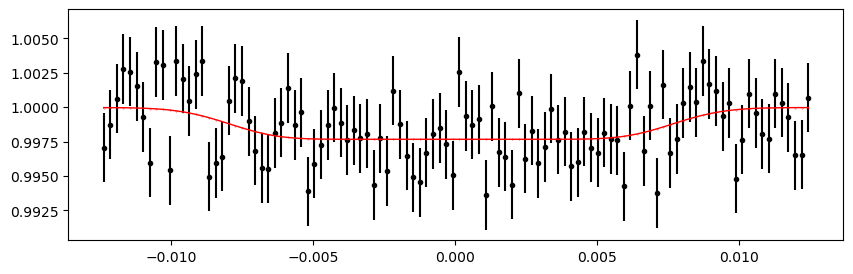

3299.560568 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:18<00:00, 549.77it/s]


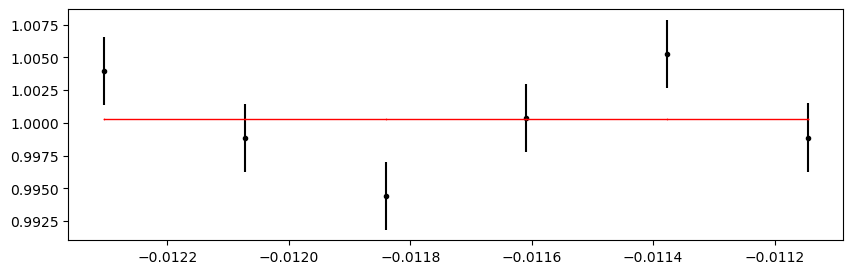

3311.531752 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 387.97it/s]


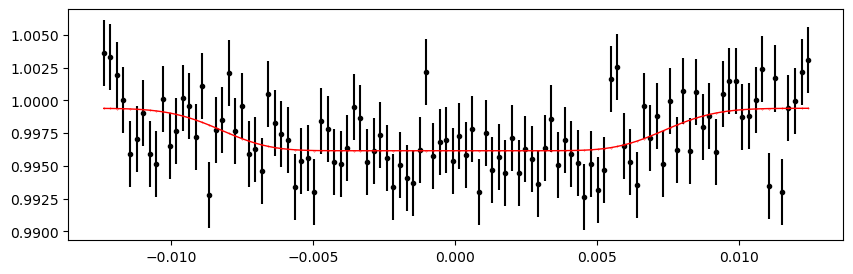

3317.517344 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 450.60it/s]


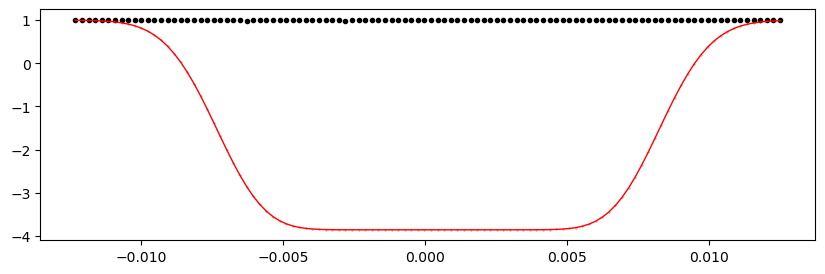

3323.502936 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 381.36it/s]


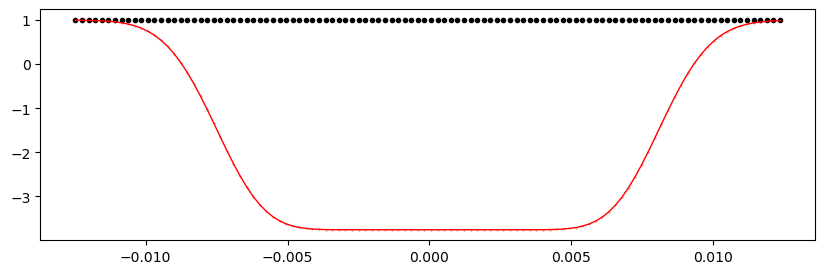

3329.488528 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 449.55it/s]


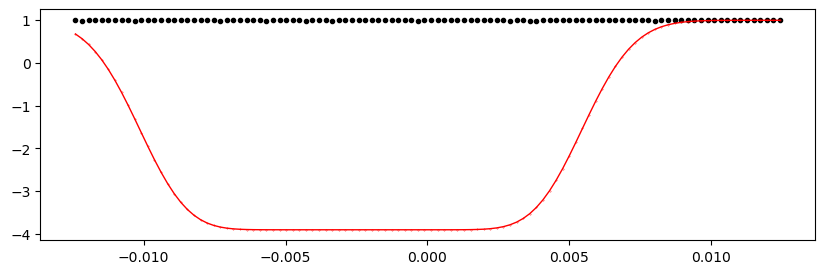

In [40]:
%matplotlib inline

# from importlib import reload
# reload(etv_functions)

print("Fitting individual primary eclipses...")
etv_functions.fit_each_eclipse(data_primary, n_transits, t0_primary, period, mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau, outfile_path,
                               min_number_data=5,  # to accomoodate 30 min cadence QLP data
                              )
!$NOTIFY_CMD "Individual primary eclipses fit done"

# ---

%matplotlib inline

if t0_secondary is not None:
    print("Fitting individual secondary eclipses...")
    etv_functions.fit_each_eclipse(data_secondary, n_transits, t0_secondary, period, mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s, outfile_path_s,
                                   min_number_data=5,  # to accomoodate 30 min cadence QLP data
                                  )
    !$NOTIFY_CMD "Individual secondary eclipses fit done"
else:
    print("No secondary eclipses defined. No-Op.")

Fitting individual secondary eclipses...
Creating new manifest file
1683.4507279999998 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 517.27it/s]


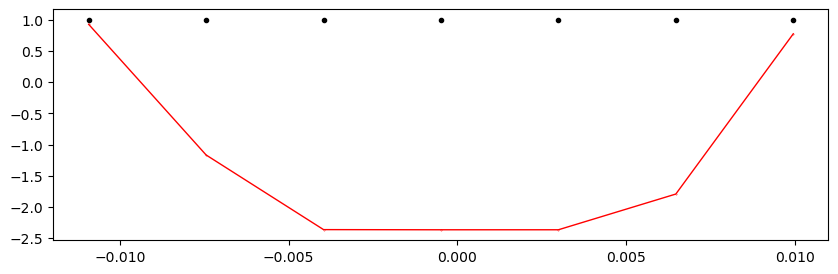

1689.4363199999998 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 517.78it/s]


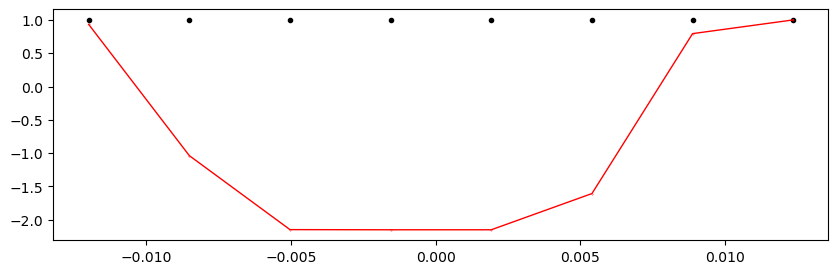

1695.4219119999998 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 475.29it/s]


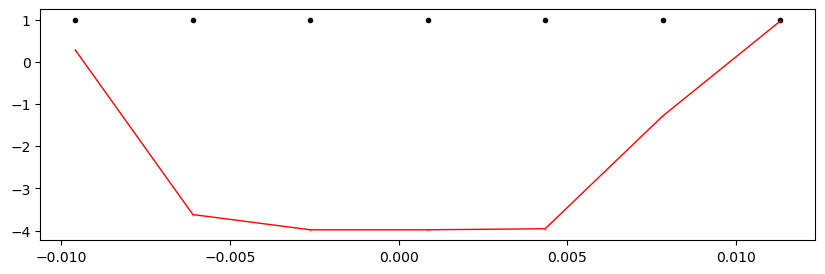

1701.4075039999998 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 437.26it/s]


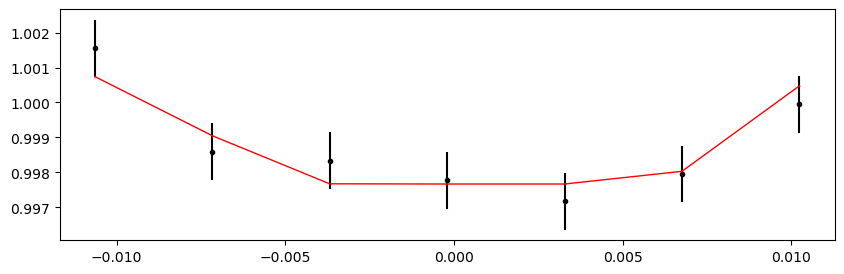

1707.3930959999998 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 506.19it/s]


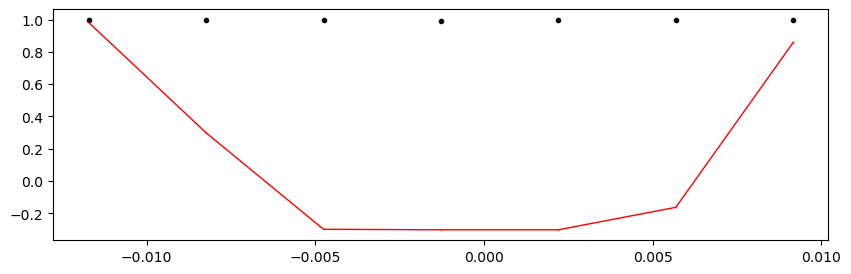

1713.3786879999998 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 440.53it/s]


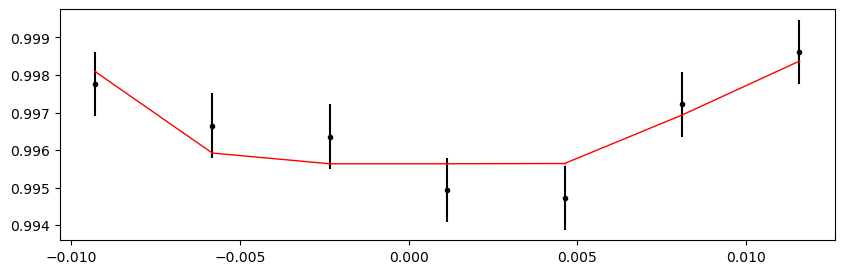

1719.3642799999998 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:18<00:00, 542.41it/s]


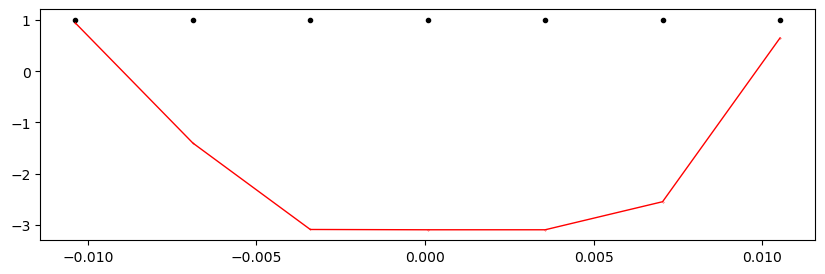

1725.3498719999998 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 522.93it/s]


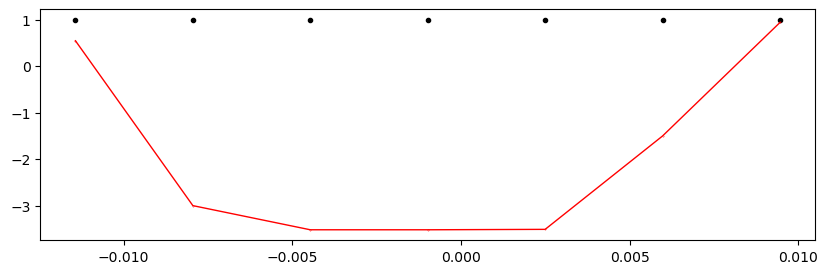

1731.3354639999998 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 457.31it/s]


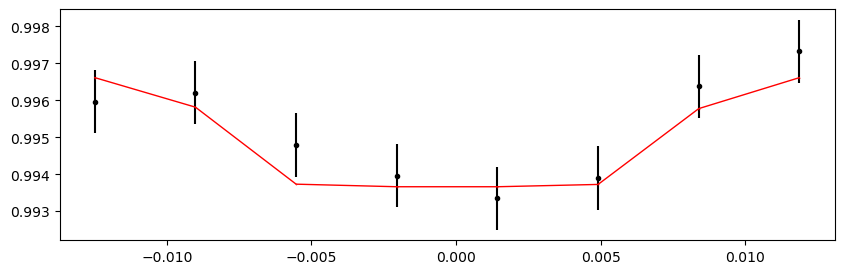

1737.3210559999998 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:18<00:00, 540.96it/s]


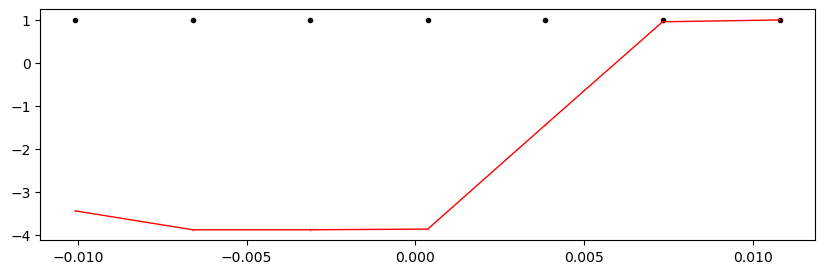

1743.3066479999998 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 444.82it/s]


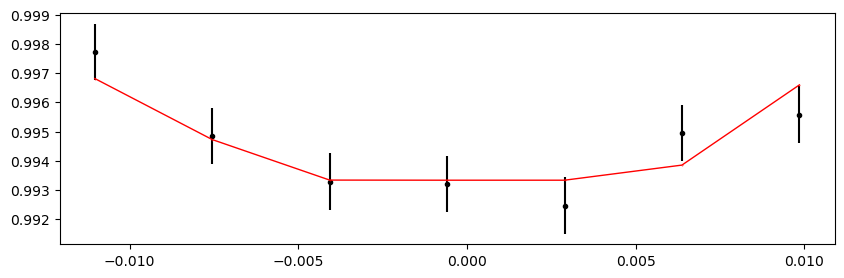

1755.2778319999998 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 440.42it/s]


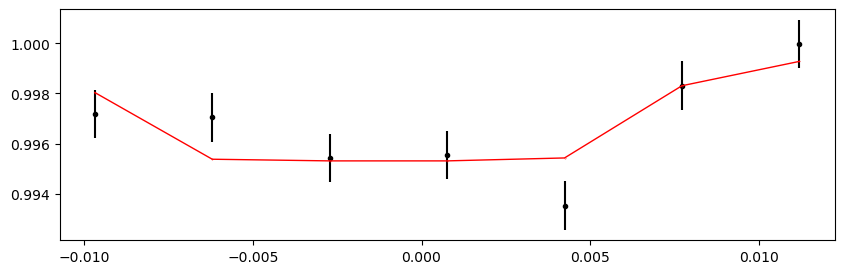

1761.2634239999998 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:18<00:00, 543.63it/s]


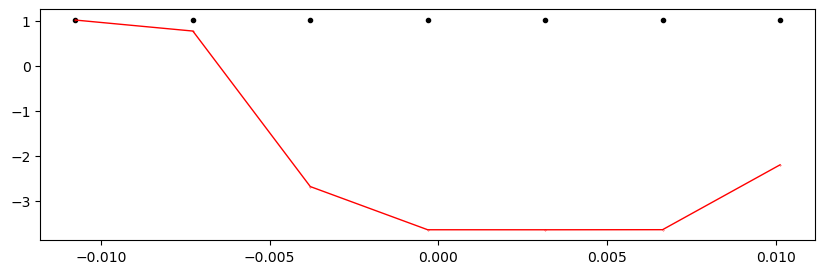

1767.2490159999998 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:18<00:00, 538.24it/s]


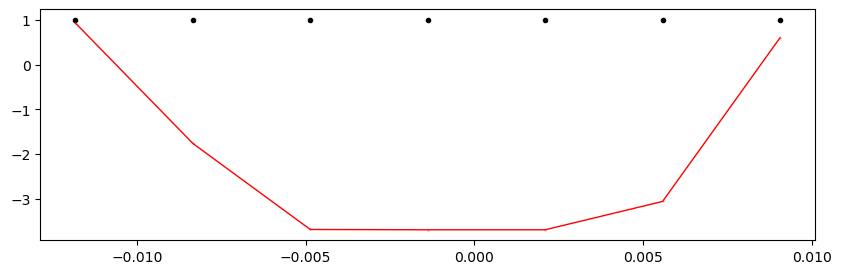

1773.2346079999998 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


100%|███████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 526.05it/s]


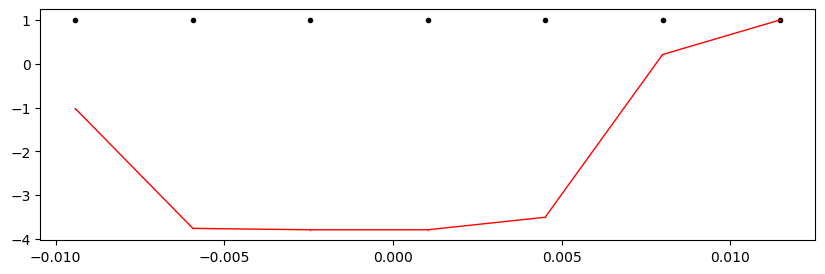

1779.2201999999997 0.9999850276440103 -0.0027378907631026204 -0.2682994537877083


 84%|███████████████████████████████████████████████         | 8407/10000 [00:18<00:03, 464.59it/s]


KeyboardInterrupt: 

## ETV O-C plot

data points with huge errors (> 10 minutes) have been filtered

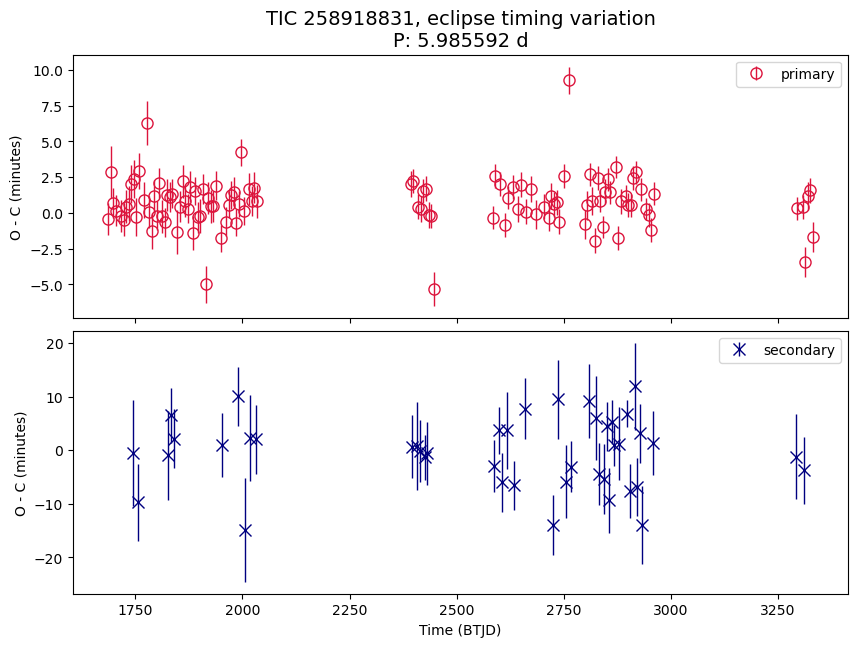

In [59]:
%matplotlib inline
# %matplotlib widget

#plot the extracted transit times to check for ETVs

num_rows = 2 if t0_secondary is not None else 1
figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5
# num_rows = 1  # force to plot primary only
# figsize_y = 3.3

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

in_df_primary = pd.read_csv(outfile_path)
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60

in_df_primary_all = in_df_primary
in_df_primary = in_df_primary[in_df_primary['std_mins'] < 10]

# axs[0].plot(in_df_primary['epoch'], in_df_primary['shift_mins'], 
#              lw = 1, color = 'crimson', )
# axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'], 
#              marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
axs[0].errorbar(in_df_primary['epoch'], in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'], 
             lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")

# if False:
if t0_secondary is not None:
    in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60
    
    in_df_secondary_all = in_df_secondary
    in_df_secondary = in_df_secondary[in_df_secondary['std_mins'] < 10]

    # axs[1].plot(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              lw = 1, color = 'navy', )
    # axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
    axs[1].errorbar(in_df_secondary['epoch'], in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'], 
                 lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );
else:
    in_df_secondary = None

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel(f"Time ({search_result.time.format.upper()})")
axs[0].set_title(f"TIC {ticid}, eclipse timing variation\nP: {period} d", fontsize=14)

plt.subplots_adjust(hspace=0.05)
# plt.ylim(-3, 8)
plt.show()

### O-C Plot, Zoom In

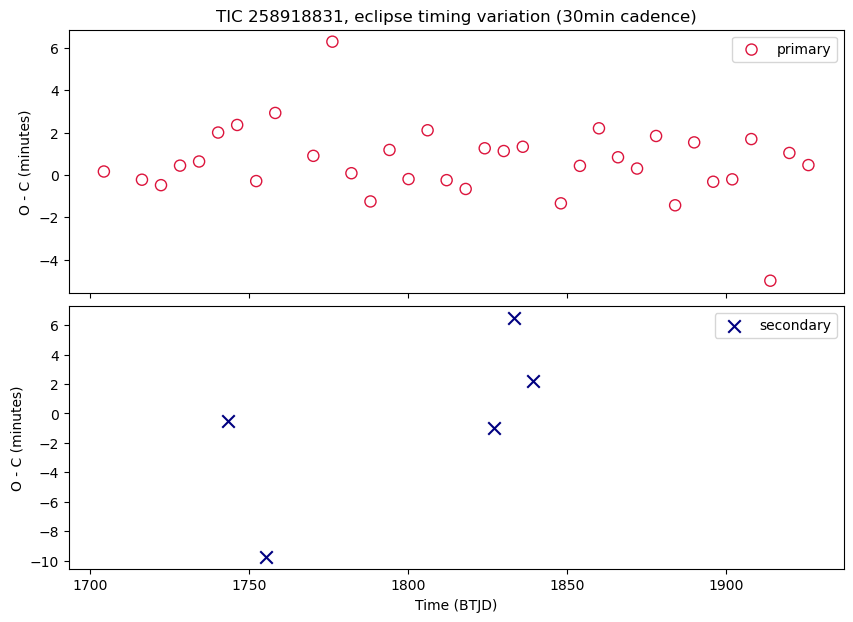

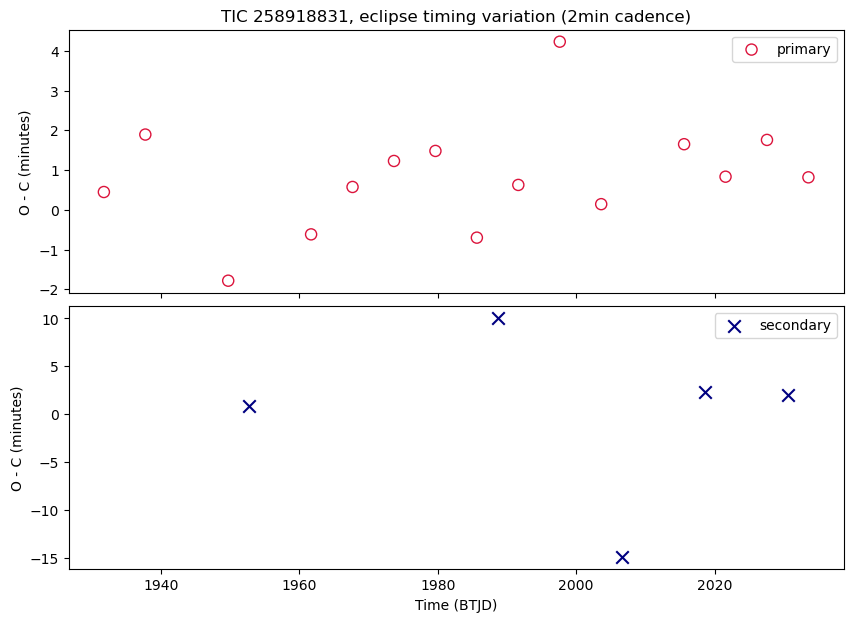

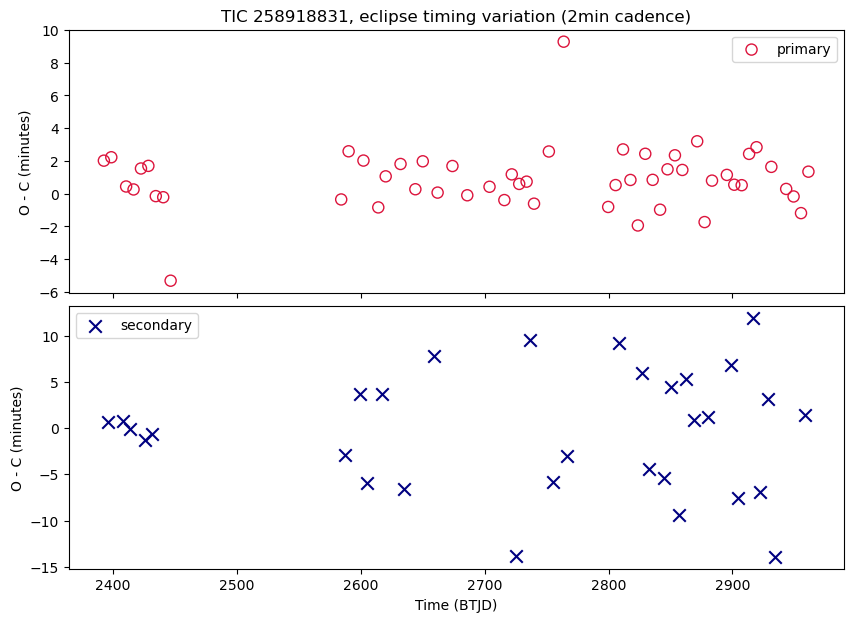

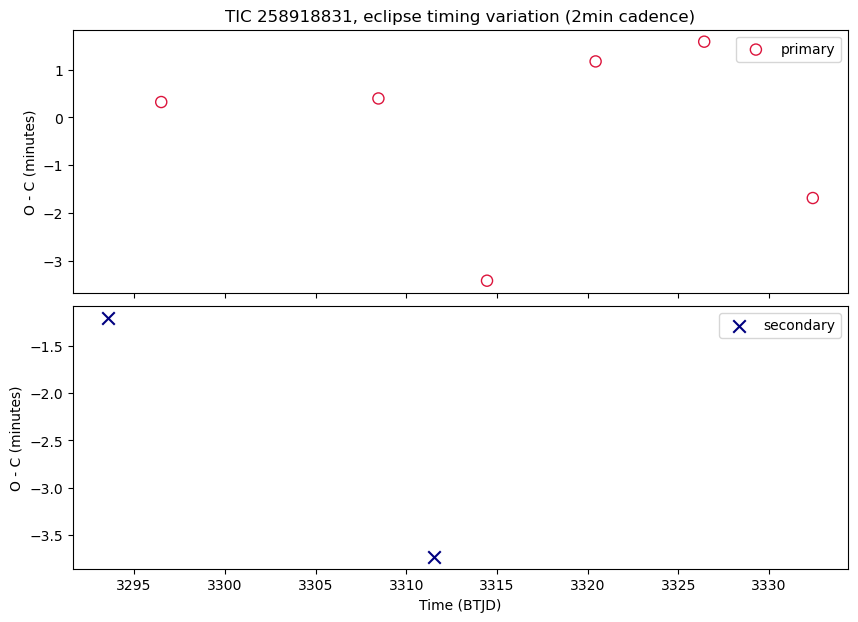

In [71]:
%matplotlib inline
# %matplotlib widget

zoom_ranges = [
    (1700, 1928),
    (1928, 2100),
    (2350, 3000),
    (3200, 3400),
]
title_suffix = "eclipse timing variation"

def tweak_axs_list(axs_list):
    # axs_list[0][1].set_ylim(-20, 30);
    # axs_list[1][0].set_ylim(None, 0.5);
    # axs_list[1][1].set_ylim(-5.5, 2);

    ax = axs_list[0][0]
    ax.set_title(f"{ax.get_title()} (30min cadence)")
    ax = axs_list[1][0]
    ax.set_title(f"{ax.get_title()} (2min cadence)")
    ax = axs_list[2][0]
    ax.set_title(f"{ax.get_title()} (2min cadence)")
    ax = axs_list[3][0]
    ax.set_title(f"{ax.get_title()} (2min cadence)")
    
    pass


def plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges):
    axs_list = []
    for zoom_start, zoom_end in zoom_ranges:
        num_rows = 2 if t0_secondary is not None else 1
        figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5
    
        fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
        if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
            axs = [axs]
        
        df_zoom = in_df_primary[(in_df_primary['epoch'] > zoom_start) & (in_df_primary['epoch'] < zoom_end)]
              
        axs[0].scatter(df_zoom['epoch'], df_zoom['shift_mins'], 
                       marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
        # axs[0].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'], 
        #                 lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")
        
        if in_df_secondary is not None:
            df_zoom = in_df_secondary[(in_df_secondary['epoch'] > zoom_start) & (in_df_secondary['epoch'] < zoom_end)]
        
            axs[1].scatter(df_zoom['epoch'], df_zoom['shift_mins'],
                           marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
            # axs[1].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'],
            #                 lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );
        
        for ax in axs:
            ax.set_ylabel("O - C (minutes)")
            ax.legend();
        
        axs[-1].set_xlabel("Time (BTJD)")
        axs[0].set_title(f"TIC {ticid}, {title_suffix}", fontsize=14)
        
        plt.subplots_adjust(hspace=0.05)
        axs_list.append(axs)
    return axs_list


axs_list = plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges)
tweak_axs_list(axs_list);

## make a periodogram 

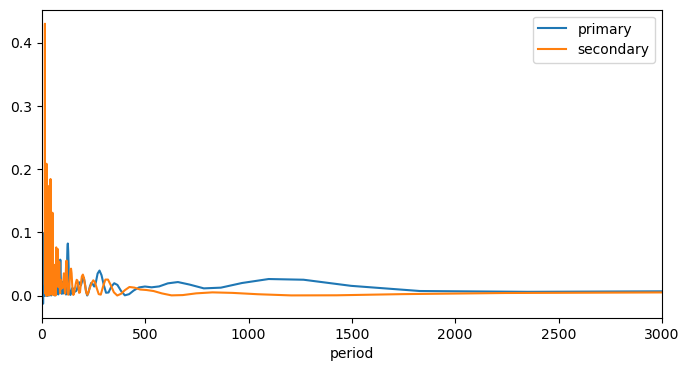

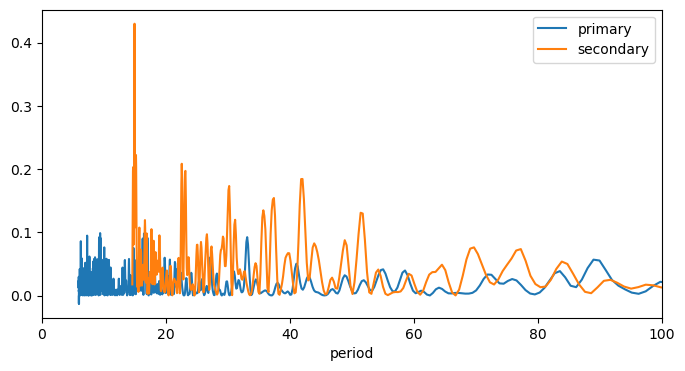

In [74]:
frequency, power = LombScargle(in_df_primary['epoch'], in_df_primary['shift_mins']).autopower()

fig, ax = plt.subplots(figsize=(8, 4))

plt.plot(1/frequency, power, label = 'primary')    

if t0_secondary is not None:
    frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()
    plt.plot(1/frequency_s, power_s, label = 'secondary')    

plt.xlabel("period")

plt.legend()
plt.xlim(0, 3000)
plt.show()


if True:
    fig, ax = plt.subplots(figsize=(8, 4))
    
    plt.plot(1/frequency, power, label = 'primary')    
    
    if t0_secondary is not None:
        frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()
        plt.plot(1/frequency_s, power_s, label = 'secondary')    
    
    plt.xlabel("period")
    
    plt.legend()
    plt.xlim(0, 100)
    plt.show()

## Results Summary

In [75]:
# FILL-IN the ETV results / comments
has_etv = "?"
comments = "Scattered O-C, with range of < 10 / 20 min . No apparent trend. The model might not be accurate enough: Tau does not converge, especially the secondary eclipses, (possibly due to U-shaped dips)."

# Eclipse depth from the model
depth_pct_p = round(-mean_alpha1 * 100, 2)
if t0_secondary is not None:
    depth_pct_s = round(-mean_alpha1_s * 100, 2)
else:
    depth_pct_s = None

summary = {
    "tic": ticid,
    "has_etv": has_etv,
    "comments": comments,
    "period": period,  # the period used in ETV analysis
    "depth_pct_p": depth_pct_p,
    "depth_pct_s": depth_pct_s,
    "epoch_p": t0_primary,
    "epoch_s": t0_secondary,
    "num_sectors": len(sr),
    "time_span": round(time[-1] - time[0], 2),
    "time_start": round(time[0], 2),
    "time_end": round(time[-1], 2),
}

summary = pd.DataFrame.from_dict(summary, orient="index")
with pd.option_context('display.max_colwidth', None, 'display.max_rows', 999, 'display.max_columns', 99):
    display(summary);

# Single line to be added to a CSV
print("")
print(summary.transpose().to_csv(
    index=False,
    header=True, 
))

0
tic                                                                                                                                                                                                   258918831
has_etv                                                                                                                                                                                                       ?
comments     Scattered O-C, with range of < 10 / 20 min . No apparent trend. The model might not be accurate enough: Tau does not converge, especially the secondary eclipses, (possibly due to U-shaped dips).
period                                                                                                                                                                                                 5.985592
depth_pct_p                                                                                                                                                                                                2.28
depth_pct_s                                                                                                                                                                                                0.27
epoch_p                                                                                                                                                                                             1686.370728
epoch_s                                                                                                                                                                                             1683.450728
num_sectors                                                                                                                                                                                                  30
time_span                                                                                                                                                                                                1656.2
time_start                                                                                                                                                                                              1683.36
time_end                                                                                                                                                                                                3339.57


tic,has_etv,comments,period,depth_pct_p,depth_pct_s,epoch_p,epoch_s,num_sectors,time_span,time_start,time_end
258918831,?,"Scattered O-C, with range of < 10 / 20 min . No apparent trend. The model might not be accurate enough: Tau does not converge, especially the secondary eclipses, (possibly due to U-shaped dips).",5.985592,2.28,0.27,1686.3707279999999,1683.4507279999998,30,1656.2,1683.36,3339.57

